# Cleaning Data

At this stage, it is important to clean the 100x100data. 

Several issues were highlighted throughout the process.

### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

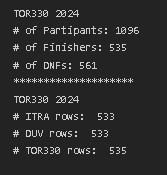

Furthermore, sometimes runners were given a status of not finished. THis was easily fixed by checking their timestamp at finish line (Courmayer). However, in that case, it was made sure that there was a timestamp for them between road Stages

### Life bases / Refugees

Several cleaning methods were deployed to clean this column. There were 'RITIRIO' in some values, so this needed to be stripped and kept in a different column 

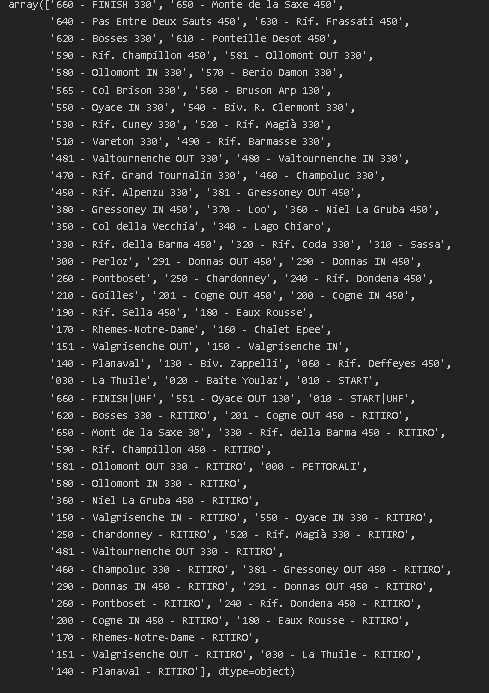


### 'Time' column
'Time' Column is one the most important columns in this process and needs to be meticulously cleaned for errors and inconsitencies!

The timesstamps had '+02:00' which was not necessary once inspected. 
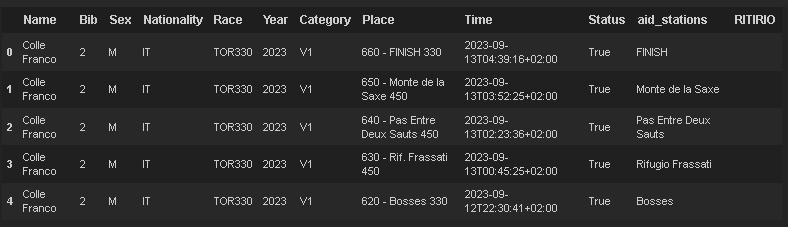


### Starting Time
Starting Times were also inaccurate. The starting time was set random times (who knows why?) but the times were changed to reflect wave start times!
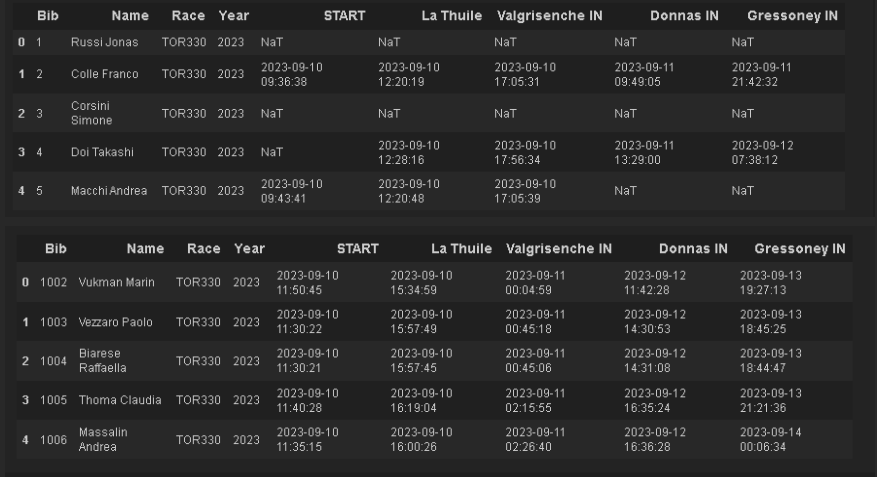

To deal with the Start Time, issue, DUV data was used to detect the start date for each year

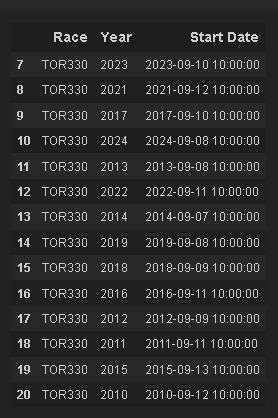

In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Start the timer
start_time = time.time()

In [ ]:
pipenv install  re
pipenv install  time
pipenv install  matplotlib.pyplot as plt
pipenv install  os
pipenv install  seaborn 
pipenv install numpy
pipenv install pandas

# Start the timer
start_time = time.time()

In [2]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

In [3]:
# def saving_tableau_df(df, name):
#     # Specify the file path
#     file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'

#     # Check if the file exists
#     if os.path.exists(file_path):
#         # Read the existing file into a DataFrame
#         existing_data = pd.read_excel(file_path)

#         # Reset the index to ensure no duplicate indices
#         existing_data.reset_index(drop=True, inplace=True)
#         df.reset_index(drop=True, inplace=True)
        
#         for num_column in ['Bib', 'Year']:
#             df[num_column] = df[num_column].astype('int')
#             df[num_column] = df[num_column].astype('str')

#         # Find rows in TOR450_dem that are not in the existing_data
#         new_rows = df[~df.apply(tuple, axis=1).isin(existing_data.apply(tuple, axis=1))]

#         if not new_rows.empty:
#             # Concatenate the new rows to the existing data, resetting the index afterward
#             updated_data = pd.concat([existing_data, new_rows], ignore_index=True)

#             # Save the updated data back to the file
#             updated_data.to_excel(file_path, index=False)
#             print("New rows added to the file.")
#         else:
#             print("No new rows to add. File remains unchanged.")
#     else:
#         # If the file doesn't exist, save the DataFrame as a new file
#         df.to_excel(file_path, index=False)
#         print(f"File created at {file_path}.")



def saving_tableau_df(df, name):
    for num_column in ['Bib', 'Year']:
            df[num_column] = df[num_column].astype('int')
            df[num_column] = df[num_column].astype('str')
    file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'
    df.to_excel(file_path, index=False)


In [4]:
def create_lifebase_checkpoint_and_aid_station_sub_df(df, column_list, column, dem_list, category_order):
    sub_df= df[column_list]

    # Pivot the data using melt
    melt_sub_df = sub_df.melt(id_vars= dem_list, 
                         var_name=column, 
                         value_name=f"Timestamp")

    # Set 'Finish Category' as a categorical column with the defined order
    melt_sub_df[column] = pd.Categorical(
        melt_sub_df[column],
        categories = category_order,
        ordered=True
    )
    
    melt_sub_df[column] = melt_sub_df[column].str.replace('Start Date','Start')

    return melt_sub_df

In [5]:
def fixing_negative_duration(df):
    # to replace all negative values with Nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Timestamp'] = pd.NaT
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration'] = np.nan


In [6]:
def calculating_banked_time(df, df_cut_offs_df, column):
    
    # Merge the datsets back together
    df = df.merge(
        df_cut_offs_df[[column, f'Running Total {column} Duration']], 
        right_on=[column],
        left_on=[column],
        how='left'
    )

    df['Banking Time'] = df[f'Running Total {column} Duration'] - df['Running Total Duration']
    df[f'Banking Time_seconds'] = pd.to_timedelta( df[f"Banking Time"], errors='coerce').dt.total_seconds()
    print(df[['Bib', column,\
              f'Running Total {column} Duration',\
              'Running Total Duration', 'Banking Time']][df['Bib'] == '1440'].head(5).transpose())
    return df


In [7]:
    
def place_into_stage(df, column):

    stages =[ Stage1, Stage2, Stage3, Stage4, Stage4_diversion ]
    stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 4 Diversion']
    for stage,  stage_str in zip(stages, stages_str):
        df.loc[df[column].isin(stage), 'Stage'] = f'{stage_str}'

    lifebase_time_spent = ['Cogne OUT','Donnas OUT','Gressoney OUT']

    for lifebase in lifebase_time_spent:
        lifebase_split = lifebase.split(' OUT')[0] 
        df.loc[df[column] == lifebase, 'Stage'] = f'Time Spent in {lifebase_split}'
    
    df['Stage'] = df['Stage'].fillna('Stage?')
        
    return df


In [8]:
lifebase_category_order = ['START',
            'Cogne IN', 'Cogne OUT', 
            'Donnas IN', 'Donnas OUT', 
            'Gressoney IN', 'Gressoney OUT', 
                           'FINISH' ]



In [9]:
checkpoint_category_order = [ 'START',
                        'Cogne IN', 'Cogne OUT',
                        'Donnas IN', 'Donnas OUT',
                        'Gressoney IN', 'Gressoney OUT', 
                        'Rifugio Champillon', 
                             'FINISH']

In [10]:
aid_station_category_order = ['START',  
    'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes',
    'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 
    'Rifugio Savoia', 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 
'Cogne IN', 'Cogne OUT',
    'Rifugio Grauson', 'Rifugio Miserin', 'Rifugio Dondena', 'Dortoir Retempio', 'Dortoir Crest', 'Rifugio Bonze', 
'Donnas IN', 'Donnas OUT',
    'Perloz','Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba','Loo',
'Gressoney IN', 'Gressoney OUT',
    'Rifugio Sitten', 'Rifugio Ferraro', 'Rifugio Guide di Frachey', 'Rifugio Duca degli Abruzzi',
    'Rifugio Perucca Vuillermoz', 'Rifugio Prarayer', 'Rifugio Crête Sèche',
    'Rifugio Champillon', 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati',
    'Pas Entre Deux Sauts', 'Monte de la Saxe','Parco Bollino',
    'FINISH']


In [11]:
weather_contigency_route  = ['START',  'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes',
 'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN',
 'Cogne OUT', 'Rifugio Grauson','Rifugio Dondena', 'Rifugio Miserin',  'Dortoir Crest','Dortoir Retempio',
 'Rifugio Bonze', 'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba','Loo', 'Gressoney IN', 'Gressoney OUT', 'Rifugio Sitten','Rifugio Ferraro',
 'Rifugio Guide di Frachey', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer', 'Rifugio Crête Sèche', 'Oyace', 'Oyace OUT', 'Bruson Arp',
 'Col Brison', 'Berio Damon', 'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati', 'Pas Entre Deux Sauts', 
 'Monte de la Saxe', 'Parco Bollino','FINISH']

In [12]:
Stage1 = [ 'START', 'Rifugio Maison Vieille', 'Rifugio Elisabetta',
 'Rifugio Deffeyes', 'Rifugio degli Angeli', 'Rifugio Bezzi',
 'Rifugio Benevolo', 'Rifugio Savoia', 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN']

Stage2 = [ 'Cogne OUT', 'Rifugio Grauson', 'Rifugio Dondena', 'Rifugio Miserin', 'Dortoir Crest',
 'Dortoir Retempio', 'Rifugio Bonze', 'Donnas IN']

Stage3 = [ 'Donnas OUT', 'Perloz','Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba',
 'Loo', 'Gressoney IN']

Stage4 =  ['Gressoney OUT', 'Rifugio Sitten', 'Rifugio Ferraro','Rifugio Guide di Frachey',
 'Rifugio Duca degli Abruzzi', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer', 'Rifugio Crête Sèche',
 'Rifugio Champillon', 'Ponteille Desot',
 'Hotel Italia', 'Rifugio Frassati',
 'Pas Entre Deux Sauts', 'Monte de la Saxe', 'Parco Bollino', 'FINISH'] 

Stage4_diversion =  [  'Oyace',  'Oyace OUT',
 'Bruson Arp', 'Col Brison',
 'Berio Damon', 'Ollomont IN',
 'Ollomont OUT']

DNF_areas =  [  'Champoluc', 'Valtourenche OUT', 'Bosses']

stages =[ Stage1, Stage2, Stage3, Stage4, Stage4_diversion, DNF_areas]
stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 4 Diversion', 'DNFed on TOR330 route' ]

## Looping through scraped data from 100X100trail

In [13]:
# races = ['TOR450']
race = 'TOR450'
years = [ 
    '2021',
    '2022',
    '2023', 
    '2024'
        ]

TORX_df = {}


for year in years:
    df = pd.read_excel(f'{race} Data/1. 100x100trail/{race}_{year}.xlsx',
                             dtype={'Start Date': 'string',
                                    'Year': 'string'})
    print(f'{race}_{year} {df.shape}')
    # Store the DataFrame in the dictionary with a key like 'TOR450_2021'
    TORX_df[f'{race}_{year}'] = df
    print('*'*50)

TOR450_2021 (1496, 10)
**************************************************
TOR450_2022 (3672, 10)
**************************************************
TOR450_2023 (5410, 10)
**************************************************
TOR450_2024 (4585, 10)
**************************************************


In [14]:
TORX_df_concat = pd.concat(TORX_df)

In [15]:
# TOR450 = TORX_df_concat[TORX_df_concat['Year'] == year]
TOR450 = TORX_df_concat.copy()
TOR450.reset_index(drop = True, inplace =  True )

In [16]:
def count_year_status(df, column):
    sub_df = df[['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category',column]].drop_duplicates(keep = 'first')
    year_status_count = sub_df.groupby(['Year', column])[column].count().to_frame('count').reset_index()

    year_status_count = year_status_count.pivot_table(
            index=column,
            columns='Year',  
            values='count',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
        ).reset_index()
    print(year_status_count)
count_year_status(TOR450, 'Status')

Year  Status  2021    2022    2023    2024  
0      False      25     103      97     117
1       True      31      46      90      68


### DUV and ITRA data


#### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

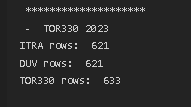


In [17]:
TORX_duv_df = pd.read_excel(f'{race} data/5. Clean Data for Data Visualisation/{race}_duv.xlsx',
                                     dtype={'Year': 'string'})

TORX_itra_no_DNF = pd.read_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_itra_no_DNF.xlsx',
                                     dtype={'Year': 'string'})

DUV_330 = pd.read_excel(f'TOR330 data/5. Clean Data for Data Visualisation/TOR330_duv.xlsx',
                                     dtype={'Year': 'string'})



In [18]:
def find_out_the_rows_difference_between_datasets(df):
    for year in years :
        if len(df['Name'][(df['Year'] == year)]) != 0:

            print(race, year)
#             print('# ITRA rows: ', TORX_itra_no_DNF[(TORX_itra_no_DNF['Year'] == year) &
#                               (TORX_itra_no_DNF['Race'] == race)].shape[0])
            print('# DUV rows: ',TORX_duv_df[(TORX_duv_df['Year'] == year) &
                              (TORX_duv_df['Race'] == race)].shape[0])

            print('# TOR450 rows: ', len(df['Name'][(df['Year'] == year) &
                                             (df['Race'] == race) &
                                             (df['Status'] == True)].unique()))
            print('\n', '*'*20)

#             if year == '2022':
#                 print(' - ','TOR450','2022')
#                 print(TORX_itra_no_DNF[(TORX_itra_no_DNF['Race'] == 'TOR450') &
#                       (TORX_itra_no_DNF['Year'] == '2022')].groupby(['Status'])['Status'].count())
#                 print('\n', '*'*20)
        else: 
            pass

In [19]:
count_year_status(TOR450, 'Status')
find_out_the_rows_difference_between_datasets(TOR450)
# counting_groupby_dataset(TOR450,  'Status')

Year  Status  2021    2022    2023    2024  
0      False      25     103      97     117
1       True      31      46      90      68
TOR450 2021
# DUV rows:  31
# TOR450 rows:  31

 ********************
TOR450 2022
# DUV rows:  46
# TOR450 rows:  46

 ********************
TOR450 2023
# DUV rows:  85
# TOR450 rows:  90

 ********************
TOR450 2024
# DUV rows:  68
# TOR450 rows:  68

 ********************


In [20]:
DUV_450 = TORX_duv_df.copy()
DUV_450.head()

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year
0,Raichon Sebastien,FRA,M,1972-01-01,4.770150,412141.0,TOR450,2023
1,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,4.868287,420620.0,TOR450,2023
2,Kienzl Peter,ITA,M,1975-01-01,5.041435,435580.0,TOR450,2023
3,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,5.090058,439781.0,TOR450,2024
4,Raichon Sebastien,FRA,M,1972-01-01,5.164792,446238.0,TOR450,2022


In [21]:
TOR450_dem = TOR450[['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category','Status']].drop_duplicates(keep = 'first').reset_index(drop = True)

In [22]:
TOR450_dem.groupby('Year')['Year'].count()

Year
2021     56
2022    149
2023    187
2024    185
Name: Year, dtype: int64

In [23]:
# # # Convert integer seconds to timedelta
DUV_450['Performance'] = pd.to_timedelta(DUV_450['Performance_Seconds'], unit='s')
# # # Convert integer seconds to timedelta
DUV_330['Performance'] = pd.to_timedelta(DUV_330['Performance_Seconds'], unit='s')


### 3 Datasets
- TOR450_dem: demographic data from 100x100 trail
- DUV_450: DUV data containing all the runners who finished TOR450
- DUV_330: DUV data containing all the runners who finished TOR330

In [24]:
DUV_330.head()

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year
0,Colle Franco Leo,ITA,M,1978-01-01,2 days 18:39:16,239956.0,TOR330,2023
1,Colle Franco Leo,ITA,M,1978-01-01,2 days 18:43:57,240237.0,TOR330,2021
2,Dominguez Ledo Javier,ESP,M,1974-01-01,2 days 19:52:15,244335.0,TOR330,2017
3,Russi Jonas,SUI,M,1985-01-01,2 days 21:03:00,248580.0,TOR330,2021
4,D Haene Francois,FRA,M,1985-01-01,2 days 21:08:32,248912.0,TOR330,2024


In [25]:
DUV_450.head()

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year
0,Raichon Sebastien,FRA,M,1972-01-01,4 days 18:29:01,412141.0,TOR450,2023
1,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,4 days 20:50:20,420620.0,TOR450,2023
2,Kienzl Peter,ITA,M,1975-01-01,5 days 00:59:40,435580.0,TOR450,2023
3,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,5 days 02:09:41,439781.0,TOR450,2024
4,Raichon Sebastien,FRA,M,1972-01-01,5 days 03:57:18,446238.0,TOR450,2022


In [26]:
TOR450_dem.head()

,Name,Bib,Sex,Nationality,Race,Year,Category,Status
0,Papi Luca,4001,M,FR,TOR450,2021,V1,True
1,Gabioud Jules Henry,4015,M,CH,TOR450,2021,SEN,True
2,Case Stephanie,4006,F,FR,TOR450,2021,SEN,True
3,Claudiu Beletoiu,4027,M,RO,TOR450,2021,SEN,True
4,Gonzalez Fernando,4011,M,ES,TOR450,2021,V1,True


In [27]:
DUV_450.columns

Index(['Name', 'DUV_ationality', 'Sex', 'DOB', 'Performance',
       'Performance_Seconds', 'Race', 'Year'],
      dtype='object')

In [28]:
DUV_330.columns

Index(['Name', 'DUV_ationality', 'Sex', 'DOB', 'Performance',
       'Performance_Seconds', 'Race', 'Year'],
      dtype='object')

### Cleaning Names to make sure they match

In [29]:

DUV_450['Name'] = DUV_450['Name'].str.replace('Kuhn Philip', 'Kuehn Philip')
DUV_450['Name'] = DUV_450['Name'].str.replace('Sylvain Oeillet', 'Oeillet Sylvain')
DUV_450['Name'] = DUV_450['Name'].str.replace('Gonzalez Rodriguez Fernando', 'Gonzalez Fernando')
DUV_450['Name'] = DUV_450['Name'].str.replace('Richard Yann', 'Yann Richard')


TOR450_dem['Name'] = TOR450_dem['Name'].str.replace('Sylvain Oeillet', 'Oeillet Sylvain')
TOR450_dem['Name'] = TOR450_dem['Name'].str.replace('Stephane Poulin', 'Poulin Stephane')
TOR450_dem['Name'] = TOR450_dem['Name'].str.replace('Beletoiu Claudiu Ionel', 'Claudiu Beletoiu')
TOR450_dem['Name'] = TOR450_dem['Name'].str.replace('Beletoiu Claudiu', 'Claudiu Beletoiu')

### Finding all TOR450 finishers' TOR330 times
This involves filtering DUV_330 by the names in the DUV_450

In [30]:
DUV_450.groupby('Year')['Year'].count()

Year
2019    40
2021    31
2022    46
2023    85
2024    68
Name: Year, dtype: int64

In [31]:
DUV_330.groupby('Year')['Year'].count()

Year
2010    179
2011    300
2012     73
2013    383
2014    444
2015      6
2016    446
2017    461
2018    534
2019    565
2021    431
2022    408
2023    621
2024    533
Name: Year, dtype: int64

In [32]:
DUV_finishers_450_list = list(DUV_450['Name'].unique())
print('The number of TOR450 unique finishers from 2021-2024: ',len(DUV_finishers_450_list))

DUV_finishers_330_list =  list(DUV_330['Name'].unique())
print('The number of TOR330 unique finishers from 2012-2024: ',len(DUV_finishers_330_list))

The number of TOR450 unique finishers from 2021-2024:  215
The number of TOR330 unique finishers from 2012-2024:  4179


In [33]:
n = 0
DUV_450_finisher_TOR330_time = []

for finisher in DUV_finishers_450_list:
    if finisher in DUV_finishers_330_list:
#         print(finisher)
        bib_df = DUV_330[DUV_330['Name'] == finisher]

        DUV_450_finisher_TOR330_time.append(bib_df)
                                
    else:
        n = n+1
        print(n, finisher)

1 Richard Victor
2 Fink Katja
3 Hjelmer Magnus
4 Das Neves Simao Diogo
5 Kuehn Philip


In [34]:
#### Struggled to find any trances of the previous runners
# 1 Richard Victor
# 3 Fink Katja
# 4 Hjelmer Magnus
# 5 Das Neves Simao Diogo

missed_list = [ 'Gonzalez Fernando', 'Yann Richard']
for missed in missed_list:
    bib_df = DUV_330[(DUV_330['Name'] == missed)  ]
    DUV_450_finisher_TOR330_time.append(bib_df)

In [35]:
DUV_450_finisher_TOR330_time = pd.concat(DUV_450_finisher_TOR330_time)

215 finishers completed Tor des Glacier. 

All except for 4 runners were found with their TOR330 finish times.  This is saved in a database called: DUV_450_finisher_TOR330_time

In [36]:
print(DUV_330[DUV_330['Name'].isin(list(DUV_450_finisher_TOR330_time['Name'].unique()))].shape)

(342, 8)


In [37]:
# Concatenate along columns (axis=1)
merged_df = pd.concat([DUV_450_finisher_TOR330_time, DUV_450])

merged_df['Race_Performance'] = merged_df['Race'] + ' ' + str(merged_df['Performance'])
pivoted_merged_df= merged_df.drop(columns= { 'Race'})
pivoted_merged_df = merged_df.pivot_table(
        index=['Name', 'DUV_ationality', 'Sex', 'DOB', ],
        columns='Year',  
        values='Race_Performance',
        aggfunc='first'  # Ensures only the first match is kept in case of duplicates
    ).reset_index()

# Display the merged DataFrame
pivoted_merged_df[pivoted_merged_df['Name']== 'Tierney Paul']

Year,Name,DUV_ationality,Sex,DOB,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024
200,Tierney Paul,IRL,M,1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOR330 118 3 days 14:25:33\n46 3 days 0...,TOR330 118 3 days 14:25:33\n46 3 days 0...,NaN,TOR330 118 3 days 14:25:33\n46 3 days 0...,TOR450 118 3 days 14:25:33\n46 3 days 0...,TOR450 118 3 days 14:25:33\n46 3 days 0...,NaN


In [38]:
merged_df[merged_df['Name']== 'Tierney Paul']

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year,Race_Performance
135,Tierney Paul,IRL,M,1982-01-01,3 days 16:05:51,317151.0,TOR330,2021,TOR330 118 3 days 14:25:33\n46 3 days 0...
226,Tierney Paul,IRL,M,1982-01-01,3 days 22:39:26,340766.0,TOR330,2018,TOR330 118 3 days 14:25:33\n46 3 days 0...
340,Tierney Paul,IRL,M,1982-01-01,4 days 03:09:44,356984.0,TOR330,2017,TOR330 118 3 days 14:25:33\n46 3 days 0...
11,Tierney Paul,IRL,M,1982-01-01,5 days 15:22:00,487320.0,TOR450,2023,TOR450 118 3 days 14:25:33\n46 3 days 0...
12,Tierney Paul,IRL,M,1982-01-01,5 days 16:23:20,491000.0,TOR450,2022,TOR450 118 3 days 14:25:33\n46 3 days 0...


### Paul Tierney

Ran TOR450 3 times, but DNFed once, which means his TOR330 times have been already found in the DUV_330 data.

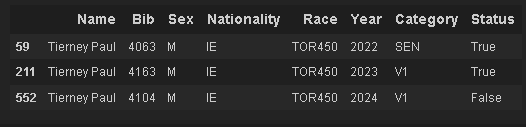

In [39]:
TOR450_dem[TOR450_dem['Name'] == 'Tierney Paul']

,Name,Bib,Sex,Nationality,Race,Year,Category,Status
59,Tierney Paul,4063,M,IE,TOR450,2022,SEN,True
211,Tierney Paul,4163,M,IE,TOR450,2023,V1,True
552,Tierney Paul,4104,M,IE,TOR450,2024,V1,False


In [40]:
for unique_name in list(TOR450_dem['Name'][TOR450_dem['Name'] == 'Tierney Paul'].unique()) :
    unique_name_df = TOR450_dem[(TOR450_dem['Name'] == unique_name)]
    unique_names_who_DNFed_and_finished_TOR450 = unique_name_df[(TOR450_dem['Status'] == True) |
               (TOR450_dem['Status'] == False)]
    print(unique_names_who_DNFed_and_finished_TOR450)

             Name   Bib Sex Nationality    Race  Year Category  Status
59   Tierney Paul  4063   M          IE  TOR450  2022      SEN    True
211  Tierney Paul  4163   M          IE  TOR450  2023       V1    True
552  Tierney Paul  4104   M          IE  TOR450  2024       V1   False


C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\1430468024.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_names_who_DNFed_and_finished_TOR450 = unique_name_df[(TOR450_dem['Status'] == True) |


In [41]:
TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list = list(TOR450_dem['Name'][TOR450_dem['Status'] == True].unique())
print('Number of uniquw names in TOR450_dem that finished TOR450 at least once: ',
      len(TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list))

Number of uniquw names in TOR450_dem that finished TOR450 at least once:  192


In [42]:
TOR450_dem_unique_names_of_never_finished_TOR450_list = list(TOR450_dem['Name'][~(TOR450_dem['Name'].isin(TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list))].unique())
print('Number of uniquw names in TOR450_dem that never finished TOR450: ', len(TOR450_dem_unique_names_of_never_finished_TOR450_list))

Number of uniquw names in TOR450_dem that never finished TOR450:  210


### Finding TOR330 times for everyone who NEVER finished TOR450 in 2021 - 2024

In [43]:
TOR450_dem_unique_names_of_never_finished_TOR450_list

['Szymik Marcin',
 'Romboletti Oscar',
 'Marzotto Ita Emanuela',
 'Rinaldo Alfio',
 'Belin Christophe',
 'Angel Andrade Julio Cesar',
 'Hjelmstrom Peter',
 'Puiati Stefano',
 'Jose Urizar',
 'Petersen Heine',
 'L Heureux Yvan',
 'Holst Benjamin',
 'Gaetani Elio',
 'Gallizia Michele',
 'Dufour Olivier',
 'Eric Jeanclaude',
 'Buzzolan Corrado',
 'Jan Kriska',
 'Ferrari Fabio',
 'Sanguineti Charlie',
 'Van Der Hoeven Jan Jilles',
 'Poupinet Benoit',
 'Candido Luca',
 'Madeira Luis',
 'Plantefeve Gaetan',
 'Guilera Sala Monica',
 'Paladin Tiziano',
 'Piazzo Mario',
 'Mallol Luc',
 'Dorne Franck',
 'Szramowiat Marek',
 'Hetmanski Adam',
 'Cestino Saez Enrique',
 'Gong Mingcheng',
 'Mrtinez Jose',
 'Ageorges Fabrice',
 'Gasparini Thierry',
 'Bracotto Giovanni Giuseppe',
 'Warchol Alexandre',
 'Pivert Jean Baptiste',
 'Noville Maurice',
 'Criado Toca Pablo',
 'Domnin Erard',
 'Defecinski Radoslaw',
 'Guerini Luca',
 'Cattaneo Martino',
 'Humphrey Andy',
 'Roig Josep',
 'Bremmers Paul',
 'Loca

In [44]:
# Whose names dont Match? 
names_dont_match = []
n = 0
for TOR450_DNF in TOR450_dem_unique_names_of_never_finished_TOR450_list:
    if TOR450_DNF in DUV_finishers_330_list:
        pass
    else:
        n = n + 1
        print(n , TOR450_DNF)
        
        names_dont_match.append(TOR450_DNF)
 

1 Marzotto Ita Emanuela
2 Jose Urizar
3 Petersen Heine
4 Eric Jeanclaude
5 Jan Kriska
6 Madeira Luis
7 Gong Mingcheng
8 Mrtinez Jose
9 Domnin Erard
10 Roig Josep
11 Geist Bill
12 Solari Paolo
13 Davico Claudio
14 Buitrago Javier
15 Iancu David
16 Ramos Mario
17 Gosney Melissa
18 Devine Keri
19 Riserva Riserva
20 Ong Soonseng
21 Rastelli Daniel
22 Compagnoni Gustavo
23 Timo Vogel
24 De Lahitte Hernan
25 Antonin Claudio
26 Perrone Carmelo
27 Madrigal Ligia
28 Chiri Duilio Fedele
29 Frederic Gil
30 Daniel Gloria
31 Obreza Marko
32 Herrero Albert
33 De Santiago Luis
34 Van Gheluwe Yannick
35 Jacobs Erik
36 Pierre Selva
37 Hayes Steve


### 37 Names in TOR450_dem (100x100 data) dont match the names of the DUV

In [45]:
n = 0
for name in names_dont_match:
    
    bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name}')]
    if not bib_df.empty:
        
        n = n+1
        print(n, name)
        print(bib_df['Name'].unique())
        print('*'*30)
    else:
        name_split = name.split(' ')[0]
        name_split_1 = name.split(' ')[1]
        bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name_split}')]
        if not bib_df.empty:
            
            n = n+1
            print(n, name)
            print(bib_df['Name'].unique())
            print('*'*30)
        else: 
            bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name_split_1}')]
            n = n+1
            print(n, name)
            print(bib_df['Name'].unique())
            print('*'*30)

1 Marzotto Ita Emanuela
['Marzotto Ita Emanuela Anna']
******************************
2 Jose Urizar
['Larrotcha Martinez Carrasco Juan Jose' 'De Los Angeles Segui Juan Jose'
 'Dorta Bello Dario Jose' 'Cabanas Coma Josep Maria'
 'Martinez Fernandez Jose Luis' 'Storc Joseph'
 'Muniz Estrada Jose Alejandro' 'Pera Vall Llosera Josep' 'Grant Joseph'
 'Santos Pose Jose Manuel' 'Figueroa Lago Jose Antonio'
 'Sousa Francisco Flavio Jose' 'Sanglas Ayats Josep'
 'Arderiu Viudes Josep' 'Martinez Rodriguez Jose' 'Samaniego Montero Jose'
 'D Alessio Davidson Joseph Anthony' 'Urizar Jose Lorenzo'
 'Roig Carcel Josep' 'Manterola Larraza Jose Ignacio'
 'Rodriguez Paredes Jose Manuel' 'Nasser Puga Miguel Jose'
 'Meana Busto Jose Manuel' 'Gonzalez Gonzalez Jose Manuel'
 'Del Valle Marco Jose' 'Compan Olmo Jose Manuel'
 'Gonzalez Garcia Jose Luis' 'Tani Stanghellini Jose Luis'
 'Normand Joseph' 'Zmatlo Josef' 'Rodriguez Sanchez Jose Angel'
 'Ruiz Aguilera Jose Antonio' 'Narvaiza Echevarria Joseba'
 'Herr

In [46]:
def clean_100x100_data_names(df):
    df['Name'] = df['Name'].str.replace('Mrtinez Jose', 'Martinez Jose')
    df['Name'] = df['Name'].str.replace('Marzotto Ita Emanuela', 'Marzotto Ita Emanuela Anna')
    df['Name'] = df['Name'].str.replace('Jose Urizar', 'Urizar Jose Lorenzo')
    df['Name'] = df['Name'].str.replace('Petersen Heine', 'Petersen Heine Hove')
    df['Name'] = df['Name'].str.replace('Madeira Luis', 'Picanco Madeira Luis Manuel')
    df['Name'] = df['Name'].str.replace('Devine Keri', 'Devine Keri Ann')
    df['Name'] = df['Name'].str.replace('Rastelli Daniel', 'Rastelli Daniel Fernando')
    df['Name'] = df['Name'].str.replace('Compagnoni Gustavo', 'Compagnoni Gustavo Fernando')
    df['Name'] = df['Name'].str.replace('De Lahitte Hernan', 'De Lahitte Hernan Roberto')
    df['Name'] = df['Name'].str.replace('Hayes Steve', 'Hayes Steven')
    df['Name'] = df['Name'].str.replace('Eric Jeanclaude', 'Jeanclaude Eric')
    df['Name'] = df['Name'].str.replace('Jan Kriska', 'Kriska Jan')
    df['Name'] = df['Name'].str.replace('Gong Mingcheng', 'Gong Ming Cheng (Tom)')
    df['Name'] = df['Name'].str.replace('Domnin Erard', 'Erard Domnin')
    df['Name'] = df['Name'].str.replace('Roig Josep', 'Roig Carcel Josep')
    df['Name'] = df['Name'].str.replace('Geist Bill', 'Geist William')
    df['Name'] = df['Name'].str.replace('Buitrago Javier', 'Buitrago Rodriguez Oscar Javier')
    df['Name'] = df['Name'].str.replace('Ramos Mario', 'Ramos Quispe Mario Wilbert')
    df['Name'] = df['Name'].str.replace('Gosney Melissa', 'Gosney Missy')
    df['Name'] = df['Name'].str.replace('Ong Soonseng', 'Ong Soon Seng (Steven)')
    df['Name'] = df['Name'].str.replace('Timo Vogel', 'Vogel Timo')
    df['Name'] = df['Name'].str.replace('Perrone Carmelo', 'Perrone Fodaro Carmelo')
    df['Name'] = df['Name'].str.replace('Madrigal Ligia', 'Madrigal Moya Ligia')
    df['Name'] = df['Name'].str.replace('Frederic Gil', 'Gil Frederic')
    df['Name'] = df['Name'].str.replace('Daniel Gloria', 'Gloria Daniel')
    df['Name'] = df['Name'].str.replace('Herrero Albert', 'Herrero Casas Albert')
    df['Name'] = df['Name'].str.replace('De Santiago Luis', 'De Santiago Iglesias Luis Angel')
    df['Name'] = df['Name'].str.replace('Pierre Selva', 'Selva Pierre')
    df['Name'] = df['Name'].str.replace('Antonin Claudio', 'Antonin Claudio Roger')
    df['Name'] = df['Name'].str.replace('Iancu David', 'Iancu David Traian')
clean_100x100_data_names(TOR450)
clean_100x100_data_names(TOR450_dem)


### Which Martinez Jose?

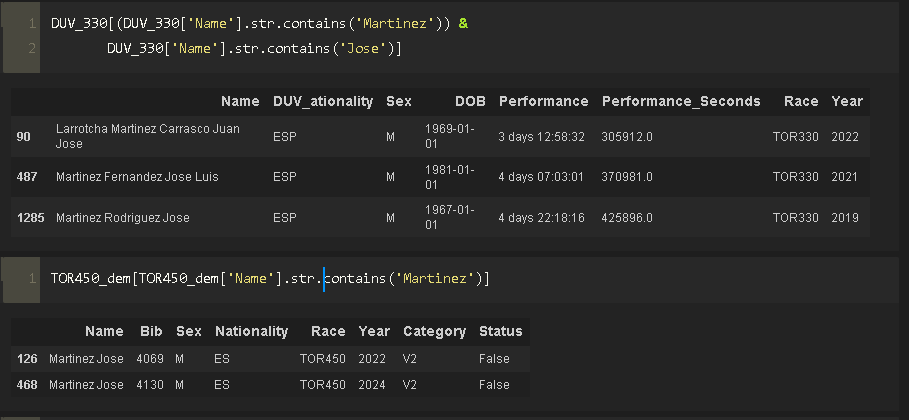

V2 is 50-59 years old, so it is definetely not the 1981 born...

In [47]:
DUV_330[(DUV_330['Name'].str.contains('Martinez')) &
       DUV_330['Name'].str.contains('Jose')]

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year
90,Larrotcha Martinez Carrasco Juan Jose,ESP,M,1969-01-01,3 days 12:58:32,305912.0,TOR330,2022
487,Martinez Fernandez Jose Luis,ESP,M,1981-01-01,4 days 07:03:01,370981.0,TOR330,2021
1285,Martinez Rodriguez Jose,ESP,M,1967-01-01,4 days 22:18:16,425896.0,TOR330,2019


In [48]:
TOR450_dem[TOR450_dem['Name'].str.contains('Martinez')]

,Name,Bib,Sex,Nationality,Race,Year,Category,Status
126,Martinez Jose,4069,M,ES,TOR450,2022,V2,False
468,Martinez Jose,4130,M,ES,TOR450,2024,V2,False


In [49]:
TOR450_dem['Name'] = TOR450_dem['Name'].str.replace('Martinez Jose', 'Martinez Rodriguez Jose')
TOR450['Name'] = TOR450['Name'].str.replace('Martinez Jose', 'Martinez Rodriguez Jose')

#### Seven TOR450 DNF

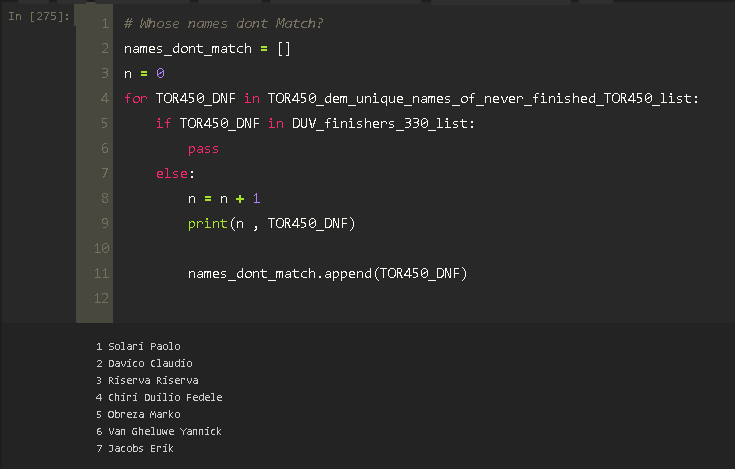

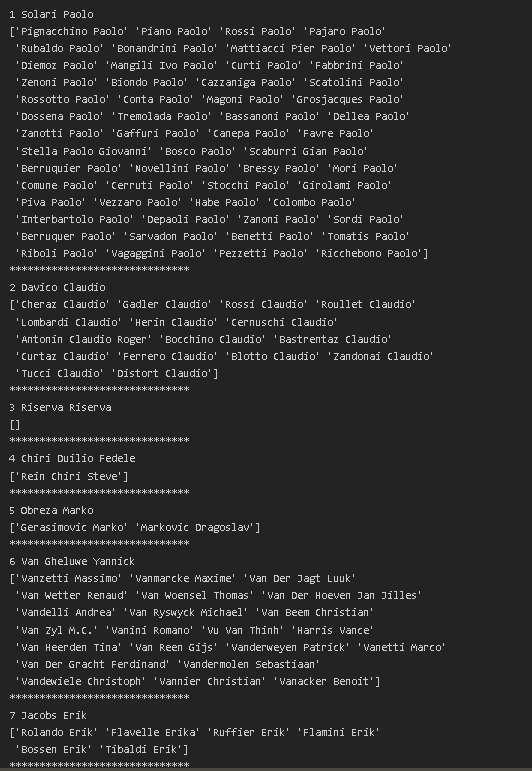

In [50]:
n = 0

DUV_330_never_finished_450 = []



for TOR450_DNF in TOR450_dem_unique_names_of_never_finished_TOR450_list:
    if TOR450_DNF in DUV_finishers_330_list:
        bib_df = DUV_330[DUV_330['Name'] == TOR450_DNF]
        if not bib_df.empty:
            DUV_330_never_finished_450.append(bib_df)
    else:
        n = n + 1
        print(n , TOR450_DNF)
        
        

1 Marzotto Ita Emanuela
2 Jose Urizar
3 Petersen Heine
4 Eric Jeanclaude
5 Jan Kriska
6 Madeira Luis
7 Gong Mingcheng
8 Mrtinez Jose
9 Domnin Erard
10 Roig Josep
11 Geist Bill
12 Solari Paolo
13 Davico Claudio
14 Buitrago Javier
15 Iancu David
16 Ramos Mario
17 Gosney Melissa
18 Devine Keri
19 Riserva Riserva
20 Ong Soonseng
21 Rastelli Daniel
22 Compagnoni Gustavo
23 Timo Vogel
24 De Lahitte Hernan
25 Antonin Claudio
26 Perrone Carmelo
27 Madrigal Ligia
28 Chiri Duilio Fedele
29 Frederic Gil
30 Daniel Gloria
31 Obreza Marko
32 Herrero Albert
33 De Santiago Luis
34 Van Gheluwe Yannick
35 Jacobs Erik
36 Pierre Selva
37 Hayes Steve


In [51]:
DUV_330_never_finished_450  = pd.concat(DUV_330_never_finished_450 )

DUV_330_never_finished_450.reset_index(drop = True, inplace = True)

### Adding TOR450 finishers' time to all those who never finished DNFs. 

In [52]:
# Everyone who finished TOR450 at least once!
DUV_450_finisher_TOR330_time.reset_index(drop = True, inplace = True)
DUV_450_finisher_TOR330_time

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year
0,Raichon Sebastien,FRA,M,1972-01-01,3 days 14:25:33,311133.0,TOR330,2019
1,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,3 days 08:18:24,289104.0,TOR330,2019
2,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,4 days 07:23:07,372187.0,TOR330,2018
3,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,5 days 06:13:32,454412.0,TOR330,2014
4,Kienzl Peter,ITA,M,1975-01-01,3 days 05:31:11,279071.0,TOR330,2018
...,...,...,...,...,...,...,...,...
340,Gay Jean Philippe,FRA,M,1974-01-01,5 days 02:33:05,441185.0,TOR330,2019
341,Shao Sebastien,FRA,M,1974-01-01,5 days 02:35:05,441305.0,TOR330,2022
342,Gonzalez Fernando,ESP,M,1966-01-01,4 days 00:51:25,348685.0,TOR330,2014
343,Gonzalez Fernando,ESP,M,1966-01-01,4 days 14:17:31,397051.0,TOR330,2012


In [53]:
# Everyone who never finished TOR450!
DUV_330_never_finished_450['TOR450'] = 'Never finished TOR450'
DUV_330_never_finished_450.head()

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year,TOR450
0,Szymik Marcin,POL,M,1973-01-01,5 days 03:34:32,444872.0,TOR330,2017,Never finished TOR450
1,Szymik Marcin,POL,M,1973-01-01,5 days 10:54:11,471251.0,TOR330,2018,Never finished TOR450
2,Szymik Marcin,POL,M,1973-01-01,6 days 02:45:06,528306.0,TOR330,2016,Never finished TOR450
3,Romboletti Oscar,ITA,M,1958-01-01,5 days 19:06:40,500800.0,TOR330,2011,Never finished TOR450
4,Rinaldo Alfio,ITA,M,1958-01-01,4 days 05:20:02,364802.0,TOR330,2014,Never finished TOR450


In [54]:
# Concatenate along columns (axis=1)
DUV330_all_who_started_TOR450 = pd.concat([DUV_450_finisher_TOR330_time, DUV_330_never_finished_450])
DUV330_all_who_started_TOR450.reset_index(drop = True , inplace = True)

In [55]:
DUV330_all_who_started_TOR450.sort_values(by = 'Performance', ascending = True )

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year,TOR450
4,Kienzl Peter,ITA,M,1975-01-01,3 days 05:31:11,279071.0,TOR330,2018,NaN
6,Gabioud Jules Henri,SUI,M,1987-01-01,3 days 07:58:26,287906.0,TOR330,2011,NaN
1,Erwee Christiaan Dirk (Tiaan),RSA,M,1987-01-01,3 days 08:18:24,289104.0,TOR330,2019,NaN
13,Ono Masahiro,JPN,M,1981-01-01,3 days 09:46:31,294391.0,TOR330,2013,NaN
14,Ono Masahiro,JPN,M,1981-01-01,3 days 11:04:15,299055.0,TOR330,2014,NaN
...,...,...,...,...,...,...,...,...,...
516,Trabucchi Pietro,ITA,M,1963-01-01,6 days 03:46:12,531972.0,TOR330,2019,Never finished TOR450
550,Distort Corrado,ITA,M,1967-01-01,6 days 03:48:36,532116.0,TOR330,2018,Never finished TOR450
39,Moyroud Nicolas,FRA,M,1969-01-01,6 days 04:09:52,533392.0,TOR330,2016,NaN
155,Beretta Marco,ITA,M,1960-01-01,6 days 04:46:01,535561.0,TOR330,2024,NaN


In [56]:
DUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Name'] == 'Gloria Daniel']

,Name,DUV_ationality,Sex,DOB,Performance,Performance_Seconds,Race,Year,TOR450


### Cleaning Place column

In [57]:
TOR450['Place'].unique()

array(['660 - FINISH - UHF', '650 - Mont de la Saxe 130|133.7|12388',
       '640 - Pas Entre Deux Sauts 330|335.6|30486',
       '630 - Rif. Frassati 130|118.9|11422',
       '600 - Hotel Italia - GSB|417|35131',
       '590 - Rif. Champillon 330|303.5|27681',
       '440 - Rif. Crête Sèche|374|31562',
       '430 - Rif. Prarayer|359|30170',
       '420 - Rif. Perucca Vuillermoz|352|29814',
       '410 - Rif. Duca degli Abruzzi|336|28541',
       '400 - Rif. Ferraro|314|26622', '390 - Rif. Sitten|301|25584',
       '381 - Gressoney 330 OUT|213.4|18300',
       '380 - Gressoney 330 IN|213.4|18300', '370 - Loo|206|18063',
       '360 - Niel - La Gruba 330|199.7|17166',
       '330 - Rif. della Balm 450a|255|21628',
       '320 - Rif. Coda 330|174.5|15024',
       '291 - Donnas 330 OUT|156.3|12242',
       '290 - Donnas 330 IN|156.3|12242', '280 - Rif. Bonze|217|17432',
       '270 - Dortoir Crest|206|15659',
       '240 - Rif. Dondena 330|132.9|11303',
       '230 - Rif. Miserin|180|139

In [58]:
# 030 - La Thuile - RITIRO
TOR450['aid_stations'] = TOR450['Place'].str.split(r'^\d+ - ').str.get(-1)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace(r'\d+', '', regex=True)
TOR450['aid_stations'] = TOR450['aid_stations'].str.split('|').str.get(0)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif.', 'Rifugio')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Biv.','Bivacco')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Niel - ','Niel ')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Oyace IN','Oyace')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('  ',' ')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Mont de la Saxe','Monte de la Saxe')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rifugio della Barmasse', 'Rifugio Barmasse')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Promoud','Bivacco Zappelli')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('FINISH - UHF','FINISH')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('START - MANUAL','START')
TOR450['aid_stations'] = TOR450['aid_stations'].str.strip()
TOR450['RITIRIO'] = np.where(
    TOR450['aid_stations'].str.contains('RITIRO', na=False), 
    TOR450['aid_stations'],  '')
# TOR450['RITIRIO] =TOR450['RITIRIO].str.replace('- RITIRO', '')
TOR450['aid_stations'] = TOR450['aid_stations'].str.split(' - RITIRO').str.get(0)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Hotel Italia - GSB', 'Hotel Italia')


TOR450 = TOR450[~(TOR450['aid_stations'] == '') ]
TOR450 = TOR450[~(TOR450['aid_stations'] == 'PETTORALI') ]
print(', '.join(list(TOR450['aid_stations'].unique())))


C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\3913618606.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\3913618606.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif.', 'Rifugio')
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\3913618606.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Biv.','Bivacco')


FINISH, Monte de la Saxe, Pas Entre Deux Sauts, Rifugio Frassati, Hotel Italia, Rifugio Champillon, Rifugio Crête Sèche, Rifugio Prarayer, Rifugio Perucca Vuillermoz, Rifugio Duca degli Abruzzi, Rifugio Ferraro, Rifugio Sitten, Gressoney OUT, Gressoney IN, Loo, Niel La Gruba, Rifugio della Barma, Rifugio Coda, Donnas OUT, Donnas IN, Rifugio Bonze, Dortoir Crest, Rifugio Dondena, Rifugio Miserin, Rifugio Grauson, Cogne OUT, Cogne IN, Rifugio Sella, Rifugio Chabod, Rifugio Vittorio Emanuele II, Rifugio Savoia, Rifugio Benevolo, Rifugio Bezzi, Rifugio degli Angeli, Rifugio Elisabetta, Rifugio Maison Vieille, Lago Chiaro, Sassa, START, Perloz, Ponteille Desot, Oyace, Rifugio Guide di Frachey, Col della Vecchia, Dortoir Retempio, Rifugio Deffeyes, Bosses, Chardonney, Hotel Stambecco, Parco Bollino, Col Brison, Bruson Arp, Oyace OUT, Champoluc, Berio Damon, Ollomont OUT, Ollomont IN, Valtournenche OUT


In [59]:
# copy the column to make a new column
for i in list(TOR450['RITIRIO'].unique()):
    print(i)


START - RITIRO
Donnas IN - RITIRO
Champoluc - RITIRO
Gressoney OUT - RITIRO
Rifugio della Barma - RITIRO
Donnas OUT - RITIRO
Cogne OUT - RITIRO
Rifugio Champillon - RITIRO
Ollomont OUT - RITIRO
Valtournenche OUT - RITIRO
Col della Vecchia - RITIRO
Perloz - RITIRO
Chardonney - RITIRO
Cogne IN - RITIRO
Rifugio Savoia - RITIRO


In [60]:
# copy the column to make a new column
all_aid_station_list = list(TOR450['aid_stations'].unique())
all_aid_station_list 

['FINISH',
 'Monte de la Saxe',
 'Pas Entre Deux Sauts',
 'Rifugio Frassati',
 'Hotel Italia',
 'Rifugio Champillon',
 'Rifugio Crête Sèche',
 'Rifugio Prarayer',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Duca degli Abruzzi',
 'Rifugio Ferraro',
 'Rifugio Sitten',
 'Gressoney OUT',
 'Gressoney IN',
 'Loo',
 'Niel La Gruba',
 'Rifugio della Barma',
 'Rifugio Coda',
 'Donnas OUT',
 'Donnas IN',
 'Rifugio Bonze',
 'Dortoir Crest',
 'Rifugio Dondena',
 'Rifugio Miserin',
 'Rifugio Grauson',
 'Cogne OUT',
 'Cogne IN',
 'Rifugio Sella',
 'Rifugio Chabod',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Savoia',
 'Rifugio Benevolo',
 'Rifugio Bezzi',
 'Rifugio degli Angeli',
 'Rifugio Elisabetta',
 'Rifugio Maison Vieille',
 'Lago Chiaro',
 'Sassa',
 'START',
 'Perloz',
 'Ponteille Desot',
 'Oyace',
 'Rifugio Guide di Frachey',
 'Col della Vecchia',
 'Dortoir Retempio',
 'Rifugio Deffeyes',
 'Bosses',
 'Chardonney',
 'Hotel Stambecco',
 'Parco Bollino',
 'Col Brison',
 'Bruson Arp',
 'Oyace OUT',
 

### Cleaning Time column

Column '2024-09-11T07:08:32+02:00' needs to be fixed into '2024-09-11 07:08:32' and turned into the datetime

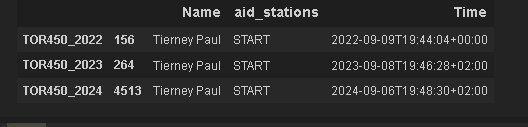

In [61]:
# 2024-09-11T07:08:32+02:00

# Split the 'Time' column to remove the timezone offset
TOR450['Timestamp'] = TOR450['Time'].str.split('+').str[0]


# # Add the 2-hour offset using timedelta
# # NO NEED!!!
# TOR450['Timestamp'] = TOR450['Timestamp'] + pd.to_timedelta('02:00:00')

# Preview the DataFrame
TOR450.head()

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
0,Papi Luca,4001,M,FR,TOR450,2021,V1,660 - FINISH - UHF,2021-09-16T14:18:00+00:00,True,FINISH,,2021-09-16T14:18:00
1,Papi Luca,4001,M,FR,TOR450,2021,V1,650 - Mont de la Saxe 130|133.7|12388,2021-09-16T13:26:33+00:00,True,Monte de la Saxe,,2021-09-16T13:26:33
2,Papi Luca,4001,M,FR,TOR450,2021,V1,640 - Pas Entre Deux Sauts 330|335.6|30486,2021-09-16T11:39:05+00:00,True,Pas Entre Deux Sauts,,2021-09-16T11:39:05
3,Papi Luca,4001,M,FR,TOR450,2021,V1,630 - Rif. Frassati 130|118.9|11422,2021-09-16T09:36:17+00:00,True,Rifugio Frassati,,2021-09-16T09:36:17
4,Papi Luca,4001,M,FR,TOR450,2021,V1,600 - Hotel Italia - GSB|417|35131,2021-09-16T06:36:00+00:00,True,Hotel Italia,,2021-09-16T06:36:00


In [62]:
TOR450[['Name', 'aid_stations', 'Time']][(TOR450['aid_stations'] == 'START') &
              (TOR450['Name'] == 'Tierney Paul')]

,Name,aid_stations,Time
1652,Tierney Paul,START,2022-09-09T19:44:04+00:00
5432,Tierney Paul,START,2023-09-08T19:46:28+02:00
15091,Tierney Paul,START,2024-09-06T19:48:30+02:00


In [63]:
bib_df = TOR450[['Name', 'aid_stations', 'Time']][(TOR450['Year'] == '2022') &
              (TOR450['Name'] == 'Tierney Paul')].sort_values(by = 'Time', ascending = True).reset_index(drop = True)


aid_stations_bib_df_list = list(bib_df['aid_stations'].unique())

aid_stations_bib_df_list

['START',
 'Rifugio Maison Vieille',
 'Rifugio Elisabetta',
 'Rifugio Deffeyes',
 'Rifugio degli Angeli',
 'Rifugio Bezzi',
 'Rifugio Benevolo',
 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod',
 'Rifugio Sella',
 'Cogne IN',
 'Cogne OUT',
 'Rifugio Grauson',
 'Rifugio Dondena',
 'Dortoir Retempio',
 'Rifugio Bonze',
 'Donnas IN',
 'Donnas OUT',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Lago Chiaro',
 'Col della Vecchia',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Sitten',
 'Rifugio Guide di Frachey',
 'Rifugio Duca degli Abruzzi',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer',
 'Rifugio Crête Sèche',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

### PIVOTING THE DATASET

In [64]:
# Pivot the data so that each participant has its own column

pivoted_TOR450 = TOR450.copy()

pivoted_TOR450['Time'] = pd.to_datetime(pivoted_TOR450['Timestamp'])

pivoted_TOR450 = pivoted_TOR450[['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' ,'aid_stations',  'Timestamp']]

pivoted_TOR450 = pivoted_TOR450.pivot_table(
    index=['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' , #'RITIRIO'
          ],
    columns='aid_stations',  
    values= 'Timestamp',
    aggfunc='first'  # Ensures only the first match is kept in case of duplicates
).reset_index()

# pivoted_TOR450 = pivoted_TOR450.sort_values(by = 'Bib', ascending = True)
pivoted_TOR450.head()

aid_stations,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Berio Damon,Bosses,...,Rifugio Prarayer,Rifugio Savoia,Rifugio Sella,Rifugio Sitten,Rifugio Vittorio Emanuele II,Rifugio degli Angeli,Rifugio della Barma,START,Sassa,Valtournenche OUT
0,Adam Eric,4052,M,AT,V1,TOR450,2022,True,NaN,NaN,...,NaN,2022-09-11T06:42:06,2022-09-11T19:54:33,2022-09-14T16:45:04,2022-09-11T11:05:53,2022-09-10T12:51:58,2022-09-13T21:06:44,2022-09-09T19:37:18,NaN,NaN
1,Adet Benoit,4141,M,FR,SEN,TOR450,2024,True,NaN,NaN,...,2024-09-12T20:37:26,2024-09-08T04:48:25,2024-09-08T17:57:04,2024-09-11T17:51:42,2024-09-08T09:07:46,2024-09-07T13:31:44,2024-09-10T18:43:09,2024-09-06T19:40:19,NaN,NaN
2,Ador Thierry,4005,M,FR,V2,TOR450,2022,False,NaN,NaN,...,NaN,2022-09-11T00:52:37,2022-09-11T15:28:33,NaN,2022-09-11T04:53:32,2022-09-10T11:46:06,NaN,2022-09-09T19:43:59,NaN,NaN
3,Ador Thierry,4077,M,FR,V2,TOR450,2023,False,NaN,NaN,...,NaN,2023-09-09T23:48:49,2023-09-10T11:02:58,NaN,2023-09-10T03:19:33,2023-09-09T10:41:24,2023-09-12T04:46:07,2023-09-08T19:30:40,NaN,NaN
4,Ador Thierry,4162,M,FR,V2,TOR450,2024,True,NaN,NaN,...,2024-09-12T03:41:16,2024-09-08T03:07:04,2024-09-08T14:42:15,2024-09-11T04:17:34,2024-09-08T07:49:19,2024-09-07T12:47:41,2024-09-10T10:06:27,2024-09-06T19:41:44,NaN,NaN


### Anomalies in 2023!

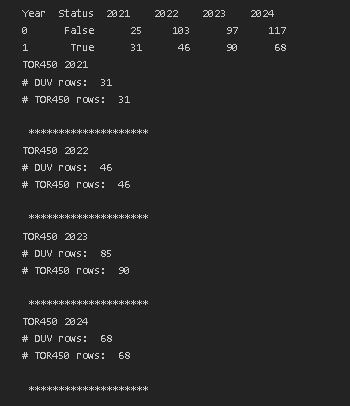

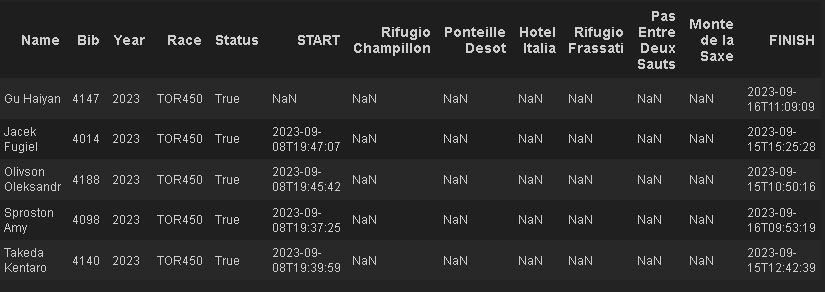

In [65]:
# Looking for runners who have FINISHED< BUT have missing values for all last 3 checkpoints!
anomalies_df = pivoted_TOR450[(pivoted_TOR450['Status'] == True) &
               (pivoted_TOR450['Bosses'].isna()) &                
               (pivoted_TOR450['Rifugio Frassati'].isna()) & 
               (pivoted_TOR450['Pas Entre Deux Sauts'].isna()) &
               (pivoted_TOR450['Monte de la Saxe'].isna())]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']].reset_index(drop = True)

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations,Name,Bib,Year,Race,Status,START,Rifugio Champillon,Ponteille Desot,Hotel Italia,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
0,Gu Haiyan,4147,2023,TOR450,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-16T11:09:09
1,Jacek Fugiel,4014,2023,TOR450,True,2023-09-08T19:47:07,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-15T15:25:28
2,Olivson Oleksandr,4188,2023,TOR450,True,2023-09-08T19:45:42,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-15T10:50:16
3,Sproston Amy,4098,2023,TOR450,True,2023-09-08T19:37:25,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-16T09:53:19
4,Takeda Kentaro,4140,2023,TOR450,True,2023-09-08T19:39:59,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-15T12:42:39


In [66]:
# # EXECUTING SOLUTION
for name in anomalies_df['Name'].unique():  
#     Fixing the code with .loc[] for proper assignment
    pivoted_TOR450.loc[(TOR450_dem['Name'] == name) & (pivoted_TOR450['Year'] == '2023'), 'FINISH'] = pd.NaT
    pivoted_TOR450.loc[(TOR450_dem['Name'] == name) & (pivoted_TOR450['Year'] == '2023'), 'Status'] = False
    
#     Fixing the code with .loc[] for proper assignment
    TOR450_dem.loc[(TOR450_dem['Name'] == name) & (TOR450_dem['Year'] == '2023'), 'Status'] = False
    
        # Fixing the code with .loc[] for proper assignment
    TOR450.loc[(TOR450['Name'] == name) & (TOR450['Year'] == '2023') &
               (TOR450['aid_stations'] == 'FINISH') 
               , 'Timestamp'] = pd.NaT
    
    TOR450.loc[TOR450['Name'] == name, :] = TOR450[(TOR450['Name'] == name) & (TOR450['aid_stations'] != 'FINISH')]

    TOR450.loc[(TOR450['Name'] == name) & (TOR450['Year'] == '2023'), 'Status'] = False

In [67]:
TOR450_dem[TOR450_dem['Name'].isin(list(anomalies_df['Name'].unique()))]

,Name,Bib,Sex,Nationality,Race,Year,Category,Status
15,Olivson Oleksandr,4026,M,UA,TOR450,2021,V2,True
140,Takeda Kentaro,4138,M,JP,TOR450,2022,V1,False
220,Olivson Oleksandr,4188,M,UA,TOR450,2023,V2,False
223,Takeda Kentaro,4140,M,JP,TOR450,2023,V1,False
230,Jacek Fugiel,4014,M,PL,TOR450,2023,V3,False
273,Sproston Amy,4098,F,US,TOR450,2023,V1,False
280,Gu Haiyan,4147,F,CN,TOR450,2023,V1,False
508,Gu Haiyan,4090,F,CN,TOR450,2024,V1,False
521,Takeda Kentaro,4074,M,JP,TOR450,2024,V1,False
544,Sproston Amy,4025,F,US,TOR450,2024,V2,False


In [68]:
# making sure the FINISH rows is dropped!!!
TOR450[(TOR450['Year'] == '2023') &
      (TOR450['Name'] == 'Sproston Amy')]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
7978,Sproston Amy,4098.0,F,US,TOR450,2023,V1,390 - Rif. Sitten,2023-09-13T09:49:16+02:00,False,Rifugio Sitten,,2023-09-13T09:49:16
7979,Sproston Amy,4098.0,F,US,TOR450,2023,V1,381 - Gressoney OUT 330,2023-09-13T06:40:50+02:00,False,Gressoney OUT,,2023-09-13T06:40:50
7980,Sproston Amy,4098.0,F,US,TOR450,2023,V1,380 - Gressoney IN 330,2023-09-13T03:20:19+02:00,False,Gressoney IN,,2023-09-13T03:20:19
7981,Sproston Amy,4098.0,F,US,TOR450,2023,V1,370 - Loo,2023-09-13T01:43:17+02:00,False,Loo,,2023-09-13T01:43:17
7982,Sproston Amy,4098.0,F,US,TOR450,2023,V1,360 - Niel La Gruba 450,2023-09-12T21:13:34+02:00,False,Niel La Gruba,,2023-09-12T21:13:34
7983,Sproston Amy,4098.0,F,US,TOR450,2023,V1,340 - Lago Chiaro,2023-09-12T17:04:04+02:00,False,Lago Chiaro,,2023-09-12T17:04:04
7984,Sproston Amy,4098.0,F,US,TOR450,2023,V1,330 - Rif. della Barma 450,2023-09-12T14:28:31+02:00,False,Rifugio della Barma,,2023-09-12T14:28:31
7985,Sproston Amy,4098.0,F,US,TOR450,2023,V1,320 - Rif. Coda 450,2023-09-12T11:29:32+02:00,False,Rifugio Coda,,2023-09-12T11:29:32
7986,Sproston Amy,4098.0,F,US,TOR450,2023,V1,291 - Donnas OUT 450,2023-09-11T23:10:54+02:00,False,Donnas OUT,,2023-09-11T23:10:54
7987,Sproston Amy,4098.0,F,US,TOR450,2023,V1,290 - Donnas IN 330,2023-09-11T19:55:29+02:00,False,Donnas IN,,2023-09-11T19:55:29


### Aid stations that are NOT on the list...
The thinking is that runner who DNFed would drop down lower to another TOR350 aid station that would safely mark them off the course!

In 2023 and 2024, part of the course was determined as unsafe and weather contigency routes were put in place. 

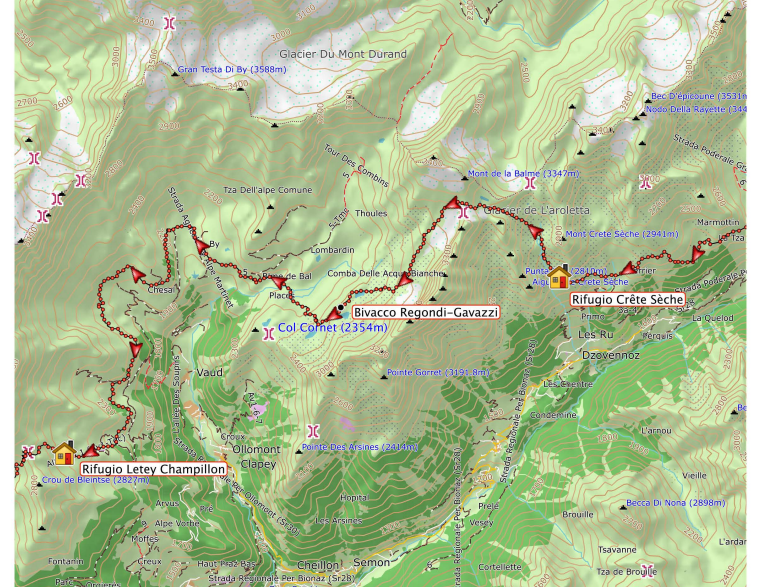


The runners at the front of the pack followed the pre-determined route (like Paul Tierney in 2023) while others ran the contigency route.

This makes analysis more difficult because the use of category order can not be applied and more reliance is put on the timestamp. However, as seen with TOR330, this is not always accurate. However, this is the last reserve. 


In [69]:
TOR450[['Name',
        'aid_stations',
        'Time', 
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Oyace')) &
                           (TOR450['Status'] == True) 
                          ].reset_index(drop =  True)

,Name,aid_stations,Time,Year,Status
0,Kuchimi Taro,Oyace,2023-09-14T06:03:39+02:00,2023,True
1,Pasta Dario,Oyace OUT,2023-09-14T09:55:50+02:00,2023,True
2,Pasta Dario,Oyace,2023-09-14T09:27:18+02:00,2023,True
3,Puit Javier,Oyace OUT,2023-09-14T13:32:21+02:00,2023,True
4,Puit Javier,Oyace,2023-09-14T12:42:06+02:00,2023,True
...,...,...,...,...,...
179,Raso Andrea,Oyace,2024-09-13T03:52:26+02:00,2024,True
180,Milani Diego,Oyace,2024-09-13T03:52:22+02:00,2024,True
181,Duranti Luca,Oyace,2024-09-12T23:51:48+02:00,2024,True
182,Giacchetta Stephane,Oyace,2024-09-13T03:05:06+02:00,2024,True


In [70]:
TOR450[['Name',
        'aid_stations', 
        'Time',
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Ollomont')) &
                           (TOR450['Status'] == True)] .reset_index(drop = True)

,Name,aid_stations,Time,Year,Status
0,Flavelle Erika,Ollomont OUT,2024-09-13T07:13:06+02:00,2024,True
1,Flavelle Erika,Ollomont IN,2024-09-13T05:35:51+02:00,2024,True


### Weather Conditions 2023

In [71]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Tierney Paul'))&
                           (TOR450['Year'].str.contains('2023'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

,Name,aid_stations,Timestamp,Year,Status
5432,Tierney Paul,START,2023-09-08T19:46:28,2023,True
5431,Tierney Paul,Rifugio Maison Vieille,2023-09-08T21:00:08,2023,True
5430,Tierney Paul,Rifugio Elisabetta,2023-09-08T22:39:53,2023,True
5429,Tierney Paul,Rifugio Deffeyes,2023-09-09T03:01:42,2023,True
5428,Tierney Paul,Rifugio degli Angeli,2023-09-09T09:20:18,2023,True
5427,Tierney Paul,Rifugio Bezzi,2023-09-09T13:46:21,2023,True
5426,Tierney Paul,Rifugio Benevolo,2023-09-09T17:41:56,2023,True
5425,Tierney Paul,Rifugio Savoia,2023-09-09T21:01:18,2023,True
5424,Tierney Paul,Rifugio Vittorio Emanuele II,2023-09-10T00:27:29,2023,True
5423,Tierney Paul,Rifugio Chabod,2023-09-10T03:33:44,2023,True


In [72]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Kuchimi Taro'))&
                           (TOR450['Year'].str.contains('2023'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

,Name,aid_stations,Timestamp,Year,Status
5593,Kuchimi Taro,START,2023-09-08T19:44:33,2023,True
5592,Kuchimi Taro,Rifugio Maison Vieille,2023-09-08T21:03:48,2023,True
5591,Kuchimi Taro,Rifugio Elisabetta,2023-09-08T22:46:24,2023,True
5590,Kuchimi Taro,Rifugio Deffeyes,2023-09-09T03:30:57,2023,True
5589,Kuchimi Taro,Rifugio degli Angeli,2023-09-09T10:06:07,2023,True
5588,Kuchimi Taro,Rifugio Bezzi,2023-09-09T14:22:54,2023,True
5587,Kuchimi Taro,Rifugio Benevolo,2023-09-09T17:33:07,2023,True
5586,Kuchimi Taro,Rifugio Savoia,2023-09-09T20:47:49,2023,True
5585,Kuchimi Taro,Rifugio Vittorio Emanuele II,2023-09-10T02:35:57,2023,True
5584,Kuchimi Taro,Rifugio Chabod,2023-09-10T04:27:22,2023,True


### Weather Conditions 2024

In [73]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Pettinato Filippo'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

,Name,aid_stations,Timestamp,Year,Status
12828,Pettinato Filippo,START,2024-09-06T19:49:26,2024,True
12827,Pettinato Filippo,Rifugio Maison Vieille,2024-09-06T21:15:35,2024,True
12826,Pettinato Filippo,Rifugio Elisabetta,2024-09-06T23:19:29,2024,True
12825,Pettinato Filippo,Rifugio Deffeyes,2024-09-07T06:03:13,2024,True
12824,Pettinato Filippo,Rifugio degli Angeli,2024-09-07T13:52:38,2024,True
12823,Pettinato Filippo,Rifugio Bezzi,2024-09-07T19:27:25,2024,True
12822,Pettinato Filippo,Rifugio Savoia,2024-09-08T04:22:43,2024,True
12821,Pettinato Filippo,Rifugio Vittorio Emanuele II,2024-09-08T09:43:19,2024,True
12820,Pettinato Filippo,Rifugio Chabod,2024-09-08T11:48:51,2024,True
12819,Pettinato Filippo,Rifugio Sella,2024-09-08T18:33:34,2024,True


In [74]:
# has OLLOMONT!!!
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Flavelle Erika'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

,Name,aid_stations,Timestamp,Year,Status
12060,Flavelle Erika,START,2024-09-06T19:50:05,2024,True
12059,Flavelle Erika,Rifugio Maison Vieille,2024-09-06T21:13:02,2024,True
12058,Flavelle Erika,Rifugio Elisabetta,2024-09-06T23:08:19,2024,True
12057,Flavelle Erika,Rifugio Deffeyes,2024-09-07T05:10:26,2024,True
12056,Flavelle Erika,Rifugio degli Angeli,2024-09-07T12:31:48,2024,True
12055,Flavelle Erika,Rifugio Bezzi,2024-09-07T17:36:07,2024,True
12054,Flavelle Erika,Rifugio Benevolo,2024-09-07T21:06:33,2024,True
12053,Flavelle Erika,Rifugio Savoia,2024-09-08T00:51:23,2024,True
12052,Flavelle Erika,Rifugio Vittorio Emanuele II,2024-09-08T06:38:39,2024,True
12051,Flavelle Erika,Rifugio Chabod,2024-09-08T08:39:25,2024,True


In [75]:
# has OLLOMONT!!!
erika_df = TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Flavelle Erika'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)


list(erika_df['aid_stations'].unique())
# Used to create weather_contigency_route order

['START',
 'Rifugio Maison Vieille',
 'Rifugio Elisabetta',
 'Rifugio Deffeyes',
 'Rifugio degli Angeli',
 'Rifugio Bezzi',
 'Rifugio Benevolo',
 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod',
 'Rifugio Sella',
 'Cogne IN',
 'Cogne OUT',
 'Rifugio Grauson',
 'Rifugio Miserin',
 'Dortoir Retempio',
 'Rifugio Bonze',
 'Donnas IN',
 'Donnas OUT',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Sitten',
 'Rifugio Guide di Frachey',
 'Hotel Stambecco',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer',
 'Rifugio Crête Sèche',
 'Oyace',
 'Bruson Arp',
 'Col Brison',
 'Berio Damon',
 'Ollomont IN',
 'Ollomont OUT',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

### Other places anomalies 
US runner Amy Sproston probably decided to call it a day in Rifugio Sitten, but decided to run down to Champoluc, and then got a timestamp in Courmayeur (to make sure she is safely in Courmayeur - cleaning is always easier than trying to find a missing runner).
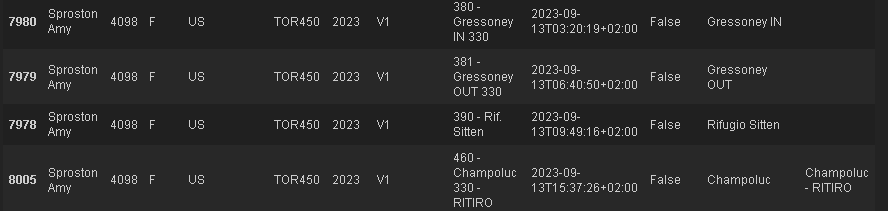

Other places that are not on the course that people DNFed at:
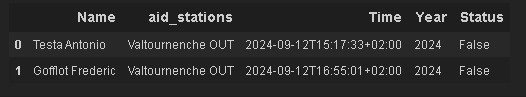


In [76]:
TOR450[(TOR450['Name'] == 'Sproston Amy') & (TOR450['Year'] == '2023')].sort_values(by = 'Timestamp', ascending  = True)

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
8003,Sproston Amy,4098.0,F,US,TOR450,2023,V1,010 - START,2023-09-08T19:37:25+02:00,False,START,,2023-09-08T19:37:25
8002,Sproston Amy,4098.0,F,US,TOR450,2023,V1,040 - Rif. Maison Vieille,2023-09-08T20:57:12+02:00,False,Rifugio Maison Vieille,,2023-09-08T20:57:12
8001,Sproston Amy,4098.0,F,US,TOR450,2023,V1,050 - Rif. Elisabetta,2023-09-08T22:33:59+02:00,False,Rifugio Elisabetta,,2023-09-08T22:33:59
8000,Sproston Amy,4098.0,F,US,TOR450,2023,V1,060 - Rif. Deffeyes 450,2023-09-09T02:57:29+02:00,False,Rifugio Deffeyes,,2023-09-09T02:57:29
7999,Sproston Amy,4098.0,F,US,TOR450,2023,V1,070 - Rif. degli Angeli,2023-09-09T10:02:08+02:00,False,Rifugio degli Angeli,,2023-09-09T10:02:08
7998,Sproston Amy,4098.0,F,US,TOR450,2023,V1,080 - Rif. Bezzi,2023-09-09T15:04:44+02:00,False,Rifugio Bezzi,,2023-09-09T15:04:44
7997,Sproston Amy,4098.0,F,US,TOR450,2023,V1,090 - Rif. Benevolo,2023-09-09T18:58:24+02:00,False,Rifugio Benevolo,,2023-09-09T18:58:24
7996,Sproston Amy,4098.0,F,US,TOR450,2023,V1,100 - Rif. Savoia,2023-09-09T23:15:16+02:00,False,Rifugio Savoia,,2023-09-09T23:15:16
7995,Sproston Amy,4098.0,F,US,TOR450,2023,V1,110 - Rif. Vittorio Emanuele II,2023-09-10T03:53:11+02:00,False,Rifugio Vittorio Emanuele II,,2023-09-10T03:53:11
7994,Sproston Amy,4098.0,F,US,TOR450,2023,V1,120 - Rif. Chabod,2023-09-10T06:10:50+02:00,False,Rifugio Chabod,,2023-09-10T06:10:50


In [77]:
TOR450[['Name',
        'aid_stations', 
        'Time',
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Valtournenche', na = False)) ].reset_index(drop = True)

,Name,aid_stations,Time,Year,Status
0,Testa Antonio,Valtournenche OUT,2024-09-12T15:17:33+02:00,2024,False
1,Gofflot Frederic,Valtournenche OUT,2024-09-12T16:55:01+02:00,2024,False


In [78]:
TOR450[(TOR450['Name'] == 'Testa Antonio') & 
       (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
13865,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,010 - START,2024-09-06T19:45:05+02:00,False,START,,2024-09-06T19:45:05
13864,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,040 - Rif. Maison Vieille,2024-09-06T21:13:05+02:00,False,Rifugio Maison Vieille,,2024-09-06T21:13:05
13863,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,050 - Rif. Elisabetta,2024-09-06T23:14:28+02:00,False,Rifugio Elisabetta,,2024-09-06T23:14:28
13862,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,060 - Rif. Deffeyes 450,2024-09-07T06:11:10+02:00,False,Rifugio Deffeyes,,2024-09-07T06:11:10
13861,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,070 - Rif. degli Angeli,2024-09-07T14:41:10+02:00,False,Rifugio degli Angeli,,2024-09-07T14:41:10
13860,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,080 - Rif. Bezzi,2024-09-07T20:37:53+02:00,False,Rifugio Bezzi,,2024-09-07T20:37:53
13859,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,100 - Rif. Savoia,2024-09-08T06:57:04+02:00,False,Rifugio Savoia,,2024-09-08T06:57:04
13858,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,110 - Rif. Vittorio Emanuele II,2024-09-08T11:05:46+02:00,False,Rifugio Vittorio Emanuele II,,2024-09-08T11:05:46
13857,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,120 - Rif. Chabod,2024-09-08T13:36:59+02:00,False,Rifugio Chabod,,2024-09-08T13:36:59
13856,Testa Antonio,4172.0,M,IT,TOR450,2024,V2,190 - Rif. Sella 450,2024-09-08T20:06:02+02:00,False,Rifugio Sella,,2024-09-08T20:06:02


In [79]:
TOR450[(TOR450['Name'] == 'Gofflot Frederic') & 
       (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
13894,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,010 - START,2024-09-06T19:38:39+02:00,False,START,,2024-09-06T19:38:39
13893,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,040 - Rif. Maison Vieille,2024-09-06T21:14:43+02:00,False,Rifugio Maison Vieille,,2024-09-06T21:14:43
13892,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,050 - Rif. Elisabetta,2024-09-06T23:17:31+02:00,False,Rifugio Elisabetta,,2024-09-06T23:17:31
13891,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,060 - Rif. Deffeyes 450,2024-09-07T06:05:31+02:00,False,Rifugio Deffeyes,,2024-09-07T06:05:31
13890,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,070 - Rif. degli Angeli,2024-09-07T14:19:13+02:00,False,Rifugio degli Angeli,,2024-09-07T14:19:13
13889,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,080 - Rif. Bezzi,2024-09-07T20:26:42+02:00,False,Rifugio Bezzi,,2024-09-07T20:26:42
13888,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,100 - Rif. Savoia,2024-09-08T08:16:25+02:00,False,Rifugio Savoia,,2024-09-08T08:16:25
13887,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,110 - Rif. Vittorio Emanuele II,2024-09-08T12:37:45+02:00,False,Rifugio Vittorio Emanuele II,,2024-09-08T12:37:45
13886,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,120 - Rif. Chabod,2024-09-08T15:01:38+02:00,False,Rifugio Chabod,,2024-09-08T15:01:38
13885,Gofflot Frederic,4047.0,M,BE,TOR450,2024,V2,190 - Rif. Sella 450,2024-09-08T22:02:38+02:00,False,Rifugio Sella,,2024-09-08T22:02:38


### Start Line Issues

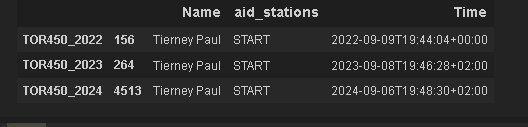

START times are all over the place and this is a MAJOR issue! 
It is important because if the start is not cleaned, it will affet the race finishing time and all the durations in between. 

### Especially 2021!!!
Some runners in 2021 had no starting times!

#### SOLUTION
1) Made a new TIME column from DUV dates

2) added start times based on the wave (based on the bib)


In [80]:
# Look at this runner who had no starting times!
TOR450[(TOR450['Name'] == 'Papi Luca') &
       (TOR450['Year'] == '2021')].sort_values(by = 'Timestamp', ascending = True)

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
7,Papi Luca,4001.0,M,FR,TOR450,2021,V1,430 - Rif. Prarayer|359|30170,2018-06-27T01:39:21+00:00,True,Rifugio Prarayer,,2018-06-27T01:39:21
35,Papi Luca,4001.0,M,FR,TOR450,2021,V1,040 - Rif. Maison Vieille|5.7|866,2021-09-10T21:02:52+00:00,True,Rifugio Maison Vieille,,2021-09-10T21:02:52
34,Papi Luca,4001.0,M,FR,TOR450,2021,V1,050 - Rif. Elisabetta|15.6|1579,2021-09-10T22:47:40+00:00,True,Rifugio Elisabetta,,2021-09-10T22:47:40
33,Papi Luca,4001.0,M,FR,TOR450,2021,V1,070 - Rif. degli Angeli|66|5976,2021-09-11T10:25:34+00:00,True,Rifugio degli Angeli,,2021-09-11T10:25:34
32,Papi Luca,4001.0,M,FR,TOR450,2021,V1,080 - Rif. Bezzi|87|7046,2021-09-11T14:58:41+00:00,True,Rifugio Bezzi,,2021-09-11T14:58:41
31,Papi Luca,4001.0,M,FR,TOR450,2021,V1,090 - Rif. Benevolo|98|7964,2021-09-11T17:53:42+00:00,True,Rifugio Benevolo,,2021-09-11T17:53:42
30,Papi Luca,4001.0,M,FR,TOR450,2021,V1,100 - Rif. Savoia|108|8882,2021-09-11T20:28:53+00:00,True,Rifugio Savoia,,2021-09-11T20:28:53
29,Papi Luca,4001.0,M,FR,TOR450,2021,V1,110 - Rif. Vittorio Emanuele II|121|9767,2021-09-11T23:54:38+00:00,True,Rifugio Vittorio Emanuele II,,2021-09-11T23:54:38
28,Papi Luca,4001.0,M,FR,TOR450,2021,V1,120 - Rif. Chabod|127|10111,2021-09-12T02:01:19+00:00,True,Rifugio Chabod,,2021-09-12T02:01:19
27,Papi Luca,4001.0,M,FR,TOR450,2021,V1,190 - Rif. Sella 450|142|11543,2021-09-12T08:02:26+00:00,True,Rifugio Sella,,2021-09-12T08:02:26


In [81]:
TOR450.columns

Index(['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category',
       'Place', 'Time', 'Status', 'aid_stations', 'RITIRIO', 'Timestamp'],
      dtype='object')

In [82]:
pivoted_TOR450[['Year','Name', 'Status', 'START', 'FINISH']][pivoted_TOR450['Year'] == '2021']

aid_stations,Year,Name,Status,START,FINISH
10,2021,Alvarez Perez Miguel,True,2021-09-10T19:47:22,2021-09-17T16:20:51
11,2021,Anderson John,False,NaN,NaN
15,2021,Angel Andrade Julio Cesar,False,NaN,NaN
36,2021,Bedhet Guillaume,True,NaN,2021-09-18T05:36:09
38,2021,Belin Christophe,False,NaN,NaN
56,2021,Bombenger Jean Francois,True,NaN,2021-09-17T12:14:17
71,2021,Buche Jean Pascal,False,2021-09-10T19:39:53,NaN
78,2021,Buzzolan Corrado,False,NaN,NaN
89,2021,Case Stephanie,True,NaN,2021-09-17T07:06:55
109,2021,Claudiu Beletoiu,True,NaN,2021-09-17T10:24:23


In [83]:
file = f'TORX DUV dates/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date'])    

# making sure both columns are years!
pivoted_TOR450['Year'] = pivoted_TOR450['Year'].astype('str')
dates_duv_df['Year'] = dates_duv_df['Year'].astype('str')

# have I dropped any rows?
print( pivoted_TOR450.shape)

# Merging on two columns: 'Race' and 'Year'
pivoted_TOR450_dates = pd.merge( pivoted_TOR450, dates_duv_df, on=['Race', 'Year'], how='inner')

# have I dropped any rows?
print( pivoted_TOR450_dates.shape)

pivoted_TOR450_dates['Start Date'] = pd.to_datetime(pivoted_TOR450_dates['Start Date'])
pivoted_TOR450_dates['FINISH'] = pd.to_datetime(pivoted_TOR450_dates['FINISH'])

# Calculate Duration
pivoted_TOR450_dates['Duration'] = pivoted_TOR450_dates['FINISH'] - pivoted_TOR450_dates['Start Date'] 

# # Sort the DataFrame by the 'Duration' column
# pivoted_TOR330_dates = pivoted_TOR330_dates.sort_values(by='Duration')
pivoted_TOR450_dates.head()

(557, 66)
(557, 67)


,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Berio Damon,Bosses,...,Rifugio Sella,Rifugio Sitten,Rifugio Vittorio Emanuele II,Rifugio degli Angeli,Rifugio della Barma,START,Sassa,Valtournenche OUT,Start Date,Duration
0,Adam Eric,4052,M,AT,V1,TOR450,2022,True,NaN,NaN,...,2022-09-11T19:54:33,2022-09-14T16:45:04,2022-09-11T11:05:53,2022-09-10T12:51:58,2022-09-13T21:06:44,2022-09-09T19:37:18,NaN,NaN,2022-09-09 20:00:00,7 days 13:01:00
1,Ador Thierry,4005,M,FR,V2,TOR450,2022,False,NaN,NaN,...,2022-09-11T15:28:33,NaN,2022-09-11T04:53:32,2022-09-10T11:46:06,NaN,2022-09-09T19:43:59,NaN,NaN,2022-09-09 20:00:00,NaT
2,Ageorges Fabrice,4025,M,FR,V1,TOR450,2022,False,NaN,NaN,...,2022-09-11T18:23:02,2022-09-14T19:22:42,2022-09-11T09:15:54,2022-09-10T13:19:58,2022-09-13T20:36:56,2022-09-09T19:43:20,NaN,NaN,2022-09-09 20:00:00,NaT
3,Anderson John,4072,M,US,V1,TOR450,2022,True,NaN,NaN,...,2022-09-11T12:17:21,2022-09-14T03:19:22,2022-09-11T02:13:48,2022-09-10T11:04:05,2022-09-13T11:06:55,2022-09-09T19:43:14,NaN,NaN,2022-09-09 20:00:00,6 days 17:33:50
4,Angel Andrade Julio Cesar,4137,M,MX,V2,TOR450,2022,False,NaN,2022-09-17T09:50:30,...,2022-09-11T16:01:00,2022-09-14T16:21:02,2022-09-11T07:08:40,2022-09-10T12:09:41,2022-09-13T18:23:29,2022-09-09T19:49:30,NaN,NaN,2022-09-09 20:00:00,NaT


In [84]:
pivoted_TOR450_dates[['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Start Date', 'FINISH', 'Duration']][pivoted_TOR450_dates['Year'] == '2021']

,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Start Date,FINISH,Duration
501,Alvarez Perez Miguel,4050,M,ES,V2,TOR450,2021,True,2021-09-10 20:00:00,2021-09-17 16:20:51,6 days 20:20:51
502,Anderson John,4009,M,US,V1,TOR450,2021,False,2021-09-10 20:00:00,NaT,NaT
503,Angel Andrade Julio Cesar,4044,M,MX,V2,TOR450,2021,False,2021-09-10 20:00:00,NaT,NaT
504,Bedhet Guillaume,4024,M,FR,V1,TOR450,2021,True,2021-09-10 20:00:00,2021-09-18 05:36:09,7 days 09:36:09
505,Belin Christophe,4025,M,FR,V2,TOR450,2021,False,2021-09-10 20:00:00,NaT,NaT
506,Bombenger Jean Francois,4048,M,FR,V1,TOR450,2021,True,2021-09-10 20:00:00,2021-09-17 12:14:17,6 days 16:14:17
507,Buche Jean Pascal,4030,M,BE,V1,TOR450,2021,False,2021-09-10 20:00:00,NaT,NaT
508,Buzzolan Corrado,4059,M,IT,V2,TOR450,2021,False,2021-09-10 20:00:00,NaT,NaT
509,Case Stephanie,4006,F,FR,SEN,TOR450,2021,True,2021-09-10 20:00:00,2021-09-17 07:06:55,6 days 11:06:55
510,Claudiu Beletoiu,4027,M,RO,SEN,TOR450,2021,True,2021-09-10 20:00:00,2021-09-17 10:24:23,6 days 14:24:23



### Other time issues - Time travel - 3 years!!
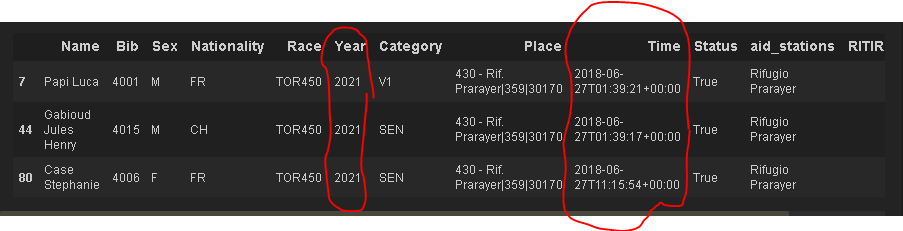

#### SOLUTION
1) change the timestamp to NAT

In [85]:
TOR450['Timestamp'] = pd.to_datetime(TOR450['Timestamp']) 

TOR450[(TOR450['aid_stations'] == 'Rifugio Prarayer') &
                       (TOR450['Timestamp'] <pd.to_datetime('2021-09-10 20:00:00'))]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
7,Papi Luca,4001.0,M,FR,TOR450,2021,V1,430 - Rif. Prarayer|359|30170,2018-06-27T01:39:21+00:00,True,Rifugio Prarayer,,2018-06-27 01:39:21
44,Gabioud Jules Henry,4015.0,M,CH,TOR450,2021,SEN,430 - Rif. Prarayer|359|30170,2018-06-27T01:39:17+00:00,True,Rifugio Prarayer,,2018-06-27 01:39:17
80,Case Stephanie,4006.0,F,FR,TOR450,2021,SEN,430 - Rif. Prarayer|359|30170,2018-06-27T11:15:54+00:00,True,Rifugio Prarayer,,2018-06-27 11:15:54


In [86]:
TOR450.loc[(TOR450['aid_stations'] == 'Rifugio Prarayer') &
       (TOR450['Timestamp'] <pd.to_datetime('2021-09-10 20:00:00')), 'Timestamp'] = pd.NaT

## TOR450 DEM

In [87]:
TOR450_dem = pivoted_TOR450_dates[['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Duration']]


# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_hours'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours

# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_seconds'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce'
).dt.total_seconds()



C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\1843216237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_hours'] = pd.to_timedelta(
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\1843216237.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_seconds'] = pd.to_timedelta(


### Examining Duration

In [88]:
TOR450_dem[~pd.isna(TOR450_dem['Duration']) &
           (TOR450_dem['Status'] == True)].reset_index(drop = True)

,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Duration,Duration_hours,Duration_seconds
0,Adam Eric,4052,M,AT,V1,TOR450,2022,True,7 days 13:01:00,181.016667,651660.0
1,Anderson John,4072,M,US,V1,TOR450,2022,True,6 days 17:33:50,161.563889,581630.0
2,Anthonioz Pierre,4014,M,FR,V1,TOR450,2022,True,7 days 13:14:15,181.237500,652455.0
3,Arbel Yannick,4135,M,CH,V1,TOR450,2022,True,7 days 15:16:05,183.268056,659765.0
4,Barmasse Piero,4016,M,IT,V2,TOR450,2022,True,6 days 19:40:51,163.680833,589251.0
...,...,...,...,...,...,...,...,...,...,...,...
229,Sylvain Oeillet,4028,M,FR,V1,TOR450,2021,True,7 days 15:05:51,183.097500,659151.0
230,Teuscher Christof,4014,M,US,V1,TOR450,2021,True,7 days 15:01:05,183.018056,658865.0
231,Traina Christophe,4034,M,BE,V1,TOR450,2021,True,7 days 17:00:24,185.006667,666024.0
232,Tribolo Philippe,4039,M,FR,V1,TOR450,2021,True,7 days 16:24:31,184.408611,663871.0


C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\3255039443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration'] = pd.to_timedelta(TOR450_dem['Duration'])


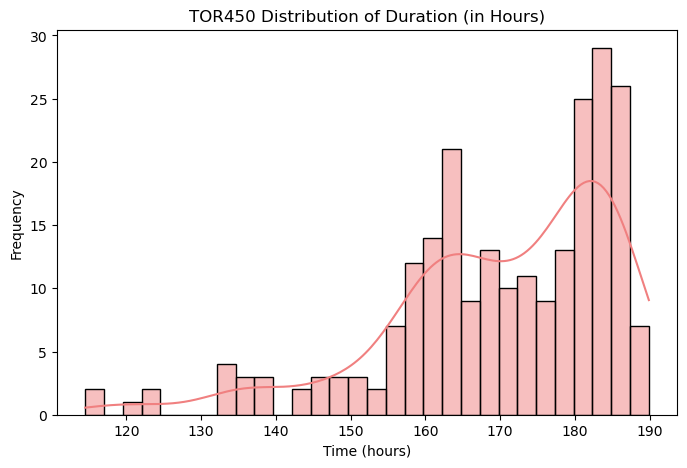

In [89]:
TOR450_dem['Duration'] = pd.to_timedelta(TOR450_dem['Duration'])

# Drop NaN values for histogram visualization
data_to_plot = TOR450_dem['Duration_hours'].dropna()
#     print(data_to_plot.head())
# print(data_to_plot['Name'].count())
# print(round(data_to_plot['Duration_hours'].min(), 2),' ', data_to_plot['Duration'].min())
# print(round(data_to_plot['Duration_hours'].max(), 2),' ', data_to_plot['Duration'].max())


# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"TOR450 Distribution of Duration (in Hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()


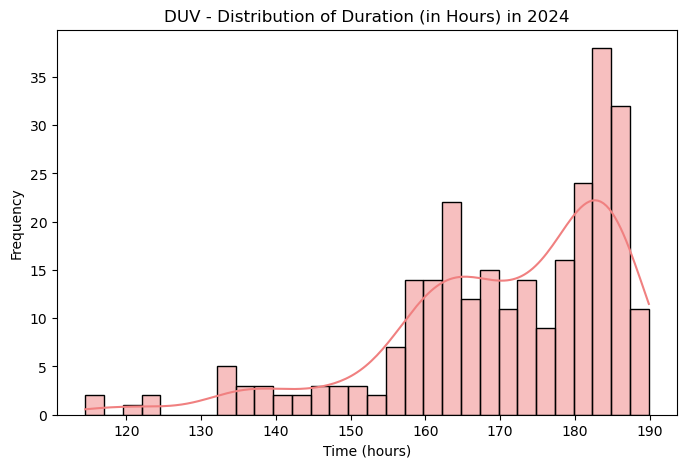

In [90]:
# Convert to timedelta and get total hours (handling NaT)
DUV_450['Duration_hours'] = pd.to_timedelta(
    DUV_450['Performance'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours


# Drop NaN values for histogram visualization
data_to_plot = DUV_450['Duration_hours'].dropna()
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"DUV - Distribution of Duration (in Hours) in {year}")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()
    

### Fixing the Start Date in long database 

Some runners didnt have 2021 START Date row in the LONG database so I had to add that row in and then pop it back into the full database

In [91]:
TORX_list = [ ]
TOR450 = TOR450[TOR450['aid_stations'] != 'START']
for year in years:
    
    TOR450_year_starters = TOR450[['Name', 'Bib', 'Sex', 
                                   'Nationality', 'Category',
                                   'Race', 'Year','Status']][TOR450['Year'] == year].drop_duplicates(keep = 'first')
    TOR450_year_starters['aid_stations'] = 'START'

    DUV_start_date = dates_duv_df['Start Date'][(dates_duv_df['Year'] == year) &
                (dates_duv_df['Race'] == 'TOR450')].values[0]
    print(year)
    print(DUV_start_date)

    TOR450_year_starters['Timestamp'] = DUV_start_date
    TORX_list.append(TOR450_year_starters)
    
TOR450_year_starters = pd.concat(TORX_list)

# Concatenate along columns (axis=1)
TOR450= pd.concat([TOR450, TOR450_year_starters])

# Look at this runner who had no starting times!
TOR450[(TOR450['Bib'] == '4063') &
       (TOR450['Year'] == '2021')].sort_values(by = 'Timestamp', ascending = True)


2021
2021-09-10T20:00:00.000000000
2022
2022-09-09T20:00:00.000000000
2023
2023-09-08T20:00:00.000000000
2024
2024-09-06T20:00:00.000000000


,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp


In [92]:

# TOR450_fixed_start_date = [ ]
# for n, (year, unique_bib) in enumerate(
#     [(y, b) for y in ['2021', '2022', '2023', '2024'] 
#      for b in TOR450.query("Year == @y")['Bib'].unique()],
#     start=1):
    
#     bib_df = TOR450.query("Year == @year and Bib == @unique_bib")
    
#     DUV_start_date = dates_duv_df['Start Date'][(dates_duv_df['Year'] == year) &
#             (dates_duv_df['Race'] == 'TOR450')].values[0]
    
#     bib_df.loc[bib_df['aid_stations'] == 'START', 'Timestamp'] =DUV_start_date
#     TOR450_fixed_start_date.append(bib_df)
# TOR450_fixed_start_date = pd.concat(TOR450_fixed_start_date)
# TOR450_fixed_start_date.reset_index(drop = True, inplace = True)

In [93]:
TOR450[(TOR450['Name'] == 'Tierney Paul') &
                       (TOR450['aid_stations'] == 'START')]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
1613,Tierney Paul,4063.0,M,IE,TOR450,2022,SEN,NaN,NaN,True,START,NaN,2022-09-09 20:00:00
5394,Tierney Paul,4163.0,M,IE,TOR450,2023,V1,NaN,NaN,True,START,NaN,2023-09-08 20:00:00
15088,Tierney Paul,4104.0,M,IE,TOR450,2024,V1,NaN,NaN,False,START,NaN,2024-09-06 20:00:00


In [94]:
TOR450['Timestamp'] = pd.to_datetime(TOR450['Timestamp'])

### RITIRIO

Although every attempt was tried to include RITIRIO column in the dataset, it came to light that some people were twice marked retired. 

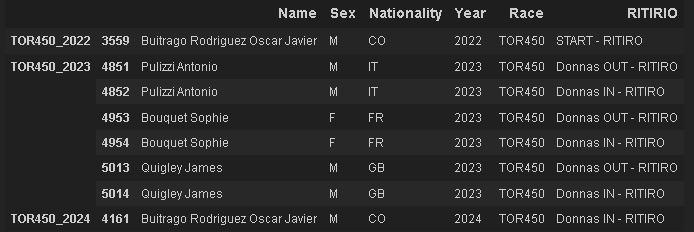

#### Solution
Do nothing?

In [95]:
ritirio_df = TOR450[~(pd.isna(TOR450['RITIRIO'])) &
                    ~(TOR450['RITIRIO'] == '') 
                   ]
# ritirio_df = ritirio_df[['Bib', 'RITIRIO']]
ritirio_df

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,aid_stations,RITIRIO,Timestamp
6160,Jacek Fugiel,4014.0,M,PL,TOR450,2023,V3,290 - Donnas IN 330 - RITIRO,2023-09-12T13:21:52+02:00,False,Donnas IN,Donnas IN - RITIRO,2023-09-12 13:21:52
8005,Sproston Amy,4098.0,F,US,TOR450,2023,V1,460 - Champoluc 330 - RITIRO,2023-09-13T15:37:26+02:00,False,Champoluc,Champoluc - RITIRO,2023-09-13 15:37:26
9610,Guasina Giorgio,4013.0,M,IT,TOR450,2023,V3,381 - Gressoney OUT 330 - RITIRO,2023-09-13T12:43:04+02:00,False,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-13 12:43:04
9638,Burgin Freddy,4015.0,M,CH,TOR450,2023,V3,381 - Gressoney OUT 330 - RITIRO,2023-09-13T14:22:08+02:00,False,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-13 14:22:08
9664,Argelich Torra Enrique,4011.0,M,ES,TOR450,2023,V3,381 - Gressoney OUT 330 - RITIRO,2023-09-13T18:30:24+02:00,False,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-13 18:30:24
9744,De Biase Anna,4096.0,F,IT,TOR450,2023,V2,381 - Gressoney OUT 330 - RITIRO,2023-09-13T23:08:41+02:00,False,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-13 23:08:41
9772,Taguchi Minori,4139.0,M,JP,TOR450,2023,V1,381 - Gressoney OUT 330 - RITIRO,2023-09-14T03:19:11+02:00,False,Gressoney OUT,Gressoney OUT - RITIRO,2023-09-14 03:19:11
9944,Incerti Thierry,4060.0,M,FR,TOR450,2023,V2,330 - Rif. della Barma 450 - RITIRO,2023-09-13T11:27:47+02:00,False,Rifugio della Barma,Rifugio della Barma - RITIRO,2023-09-13 11:27:47
9963,Braccialini Matteo,4128.0,M,IT,TOR450,2023,V1,291 - Donnas OUT 450 - RITIRO,2023-09-12T06:23:08+02:00,False,Donnas OUT,Donnas OUT - RITIRO,2023-09-12 06:23:08
9981,Michelotti Giuseppe,4052.0,M,IT,TOR450,2023,V2,291 - Donnas OUT 450 - RITIRO,2023-09-12T06:26:27+02:00,False,Donnas OUT,Donnas OUT - RITIRO,2023-09-12 06:26:27


In [96]:
# Get a list of duplicate names
duplicate_list = ritirio_df['Name'][ritirio_df['Name'].duplicated()].unique()

# Filter the DataFrame to only rows where 'Name' is in the duplicate list
duplicates_in_dataframe = ritirio_df[ritirio_df['Name'].isin(duplicate_list)]

# Display or process the result
duplicates_in_dataframe[['Name', 'Sex', 'Nationality', 'Year', 'Race', 'RITIRIO' ]]


,Name,Sex,Nationality,Year,Race,RITIRIO
10019,Pulizzi Antonio,M,IT,2023,TOR450,Donnas OUT - RITIRO
10020,Pulizzi Antonio,M,IT,2023,TOR450,Donnas IN - RITIRO
10121,Bouquet Sophie,F,FR,2023,TOR450,Donnas OUT - RITIRO
10122,Bouquet Sophie,F,FR,2023,TOR450,Donnas IN - RITIRO
10181,Quigley James,M,GB,2023,TOR450,Donnas OUT - RITIRO
10182,Quigley James,M,GB,2023,TOR450,Donnas IN - RITIRO


In [97]:
ritirio_df['Name'].nunique()

50

In [98]:
count_year_status(TOR450, 'Status')

Year  Status  2021    2022    2023    2024  
0      False      25      85      88     101
1       True      31      46      85      68


In [99]:
# # Merge the datsets back after pivoting
# pivoted_TOR450 = pivoted_TOR450.merge(
#     ritirio_df[['Bib', 'RITIRIO']].drop_duplicates(),  # Ensure no duplicates in 'Bib' and 'RITIRIO'
#     on='Bib',
#     how='left'
# )

### FINISHER'S Missing Timestamps
From time to time, timestamps are missing, even for finishers. Here is the missing values count for all finishers. 

THis is could be for several issues:
1) Participant's Fatigue - they forget to ask to be scanned

2) Volunteer's Fatigue - they forget to scan participants /  they thought they had already scanned the runer

3) Technology Failure - something goes wrong... ?

This is just a screenshot, more can be seen below!

### What is the last place that DNFers reached?
#### Issues with Last location Detected
Some people who too far of a distance between last lifebase /  refuge / checkpoint for it to be an accurate representation of their last location.

2021
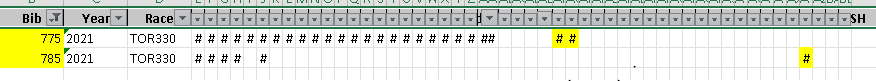

2023
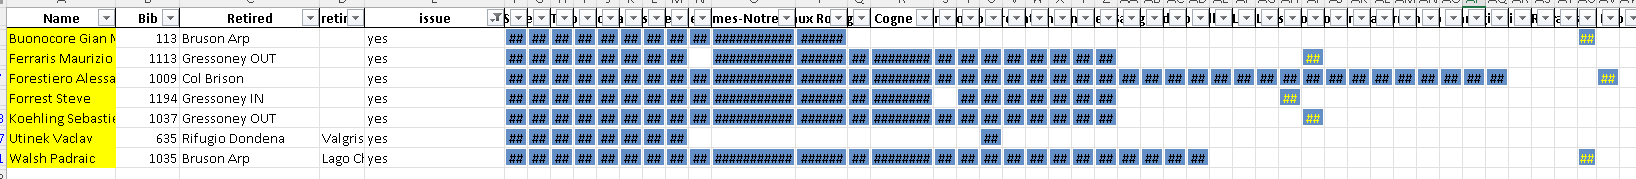

2024

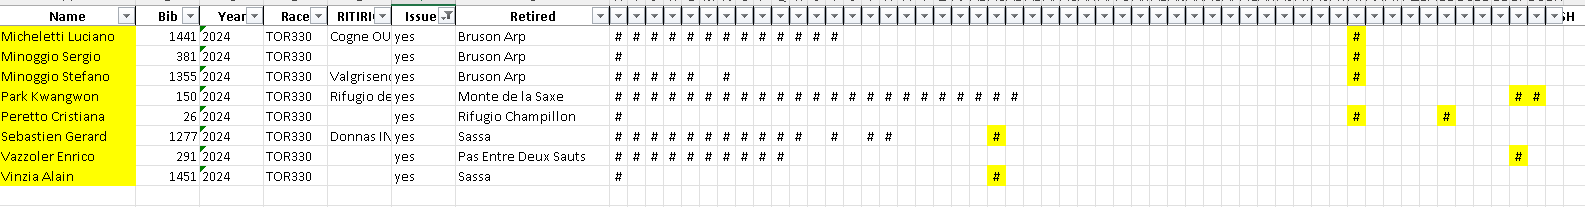

##### Solution
Create a loop that would clean those timestamps.

In [100]:
TORX_list_bib_df = []

TOR450['Status1'] =  TOR450['Status'].astype('str')
TOR450 = TOR450.rename(columns={"Timestamp": "Timestamp"}) 
TOR450 = TOR450.rename(columns={"aid_stations": "Aid Station"}) 
# 
for year in years:
    year_TOR450 = TOR450[TOR450['Year'] == year]
    for unique_bib in year_TOR450['Bib'].unique():
        bib_df = year_TOR450[year_TOR450['Bib'] == unique_bib]
        bib_df = bib_df.sort_values(by='Timestamp', ascending = True).reset_index(drop = True)

        # Check if runner has DNF status
        if bib_df.loc[0, 'Status1'] == 'False':
            n = 0  # Reset counter for missing timestamps

            for idx, row in bib_df.iterrows():
                if pd.isna(row['Timestamp']):
                    n += 1
                    if n > 5 and idx + 1 < len(bib_df):  # Ensure index is in bounds
                        bib_df.at[idx + 1, 'Timestamp'] = pd.NaT
                else:
                    n = 0  # Reset counter if a timestamp appears again

            # Find the last valid aid station with a timestamp
            last_valid_indices = bib_df[bib_df['Timestamp'].notna()].groupby('Bib').tail(1)

            if not last_valid_indices.empty:
                last_aid_station = last_valid_indices['Aid Station'].values[0]
                print(f"Bib {unique_bib}: Retired at {last_aid_station}")

                # Assign the retired location to the entire bib_df
                bib_df['Retired'] = last_aid_station
            else:
                print(f"Warning: No valid aid station found for Bib {unique_bib}")

        else:
            print(f"Bib {unique_bib}: Finished the race")

        # Append processed data
        TORX_list_bib_df.append(bib_df)

# Concatenate all processed bib dataframes
melt_TOR450 = pd.concat(TORX_list_bib_df, ignore_index=True)

melt_TOR450['Bib'] = melt_TOR450['Bib'].astype('int')
melt_TOR450['Bib'] = melt_TOR450['Bib'].astype('str')
melt_TOR450['PK'] = melt_TOR450['Race'] + '_' + melt_TOR450['Year'] + '_'+ melt_TOR450['Bib'] 


Bib 4001.0: Finished the race
Bib 4015.0: Finished the race
Bib 4006.0: Finished the race
Bib 4027.0: Finished the race
Bib 4011.0: Finished the race
Bib 4048.0: Finished the race
Bib 4017.0: Finished the race
Bib 4050.0: Finished the race
Bib 4065.0: Finished the race
Bib 4037.0: Finished the race
Bib 4003.0: Finished the race
Bib 4032.0: Finished the race
Bib 4064.0: Finished the race
Bib 4004.0: Finished the race
Bib 4043.0: Finished the race
Bib 4026.0: Finished the race
Bib 4024.0: Finished the race
Bib 4019.0: Finished the race
Bib 4042.0: Finished the race
Bib 4014.0: Finished the race
Bib 4028.0: Finished the race
Bib 4012.0: Finished the race
Bib 4063.0: Finished the race
Bib 4040.0: Finished the race
Bib 4039.0: Finished the race
Bib 4031.0: Finished the race
Bib 4034.0: Finished the race
Bib 4035.0: Finished the race
Bib 4021.0: Finished the race
Bib 4046.0: Finished the race
Bib 4047.0: Finished the race
Bib 4061.0: Retired at Rifugio Champillon
Bib 4030.0: Retired at Oyace

Bib 4121.0: Finished the race
Bib 4116.0: Finished the race
Bib 4079.0: Finished the race
Bib 4045.0: Finished the race
Bib 4061.0: Finished the race
Bib 4132.0: Finished the race
Bib 4098.0: Retired at Champoluc
Bib 4164.0: Finished the race
Bib 4166.0: Finished the race
Bib 4104.0: Finished the race
Bib 4057.0: Finished the race
Bib 4084.0: Finished the race
Bib 4181.0: Finished the race
Bib 4147.0: Retired at Oyace OUT
Bib 4178.0: Finished the race
Bib 4050.0: Finished the race
Bib 4179.0: Finished the race
Bib 4070.0: Finished the race
Bib 4134.0: Finished the race
Bib 4118.0: Finished the race
Bib 4075.0: Finished the race
Bib 4078.0: Finished the race
Bib 4097.0: Finished the race
Bib 4035.0: Finished the race
Bib 4010.0: Finished the race
Bib 4038.0: Finished the race
Bib 4042.0: Finished the race
Bib 4100.0: Finished the race
Bib 4006.0: Retired at Parco Bollino
Bib 4093.0: Retired at Rifugio Champillon
Bib 4088.0: Retired at Oyace OUT
Bib 4029.0: Retired at Oyace
Bib 4108.0: R

Bib 4006.0: Retired at Chardonney
Bib 4016.0: Retired at Rifugio Miserin
Bib 4001.0: Retired at Rifugio Miserin
Bib 4069.0: Retired at Rifugio Grauson
Bib 4148.0: Retired at Cogne OUT
Bib 4044.0: Retired at Cogne OUT
Bib 4109.0: Retired at Cogne OUT
Bib 4075.0: Retired at Cogne OUT
Bib 4132.0: Retired at Cogne IN
Bib 4149.0: Retired at Cogne IN
Bib 4034.0: Retired at Cogne IN
Bib 4029.0: Retired at Cogne IN
Bib 4031.0: Retired at Rifugio Chabod
Bib 4062.0: Retired at Rifugio Savoia
Bib 4094.0: Retired at Rifugio Savoia
Bib 4085.0: Retired at Rifugio Savoia
Bib 4012.0: Retired at Rifugio Bezzi
Bib 4079.0: Retired at Rifugio Bezzi
Bib 4099.0: Retired at Rifugio Bezzi
Bib 4017.0: Retired at Rifugio Bezzi
Bib 4112.0: Retired at Rifugio Bezzi
Bib 4025.0: Retired at Rifugio degli Angeli
Bib 4147.0: Retired at Rifugio degli Angeli
Bib 4066.0: Retired at Rifugio degli Angeli
Bib 4089.0: Retired at Rifugio degli Angeli
Bib 4174.0: Retired at Rifugio degli Angeli
Bib 4076.0: Retired at Rifugio d

In [101]:
melt_TOR450.groupby(['Retired'])

In [102]:
melt_TOR450[(melt_TOR450['Name'] == 'Tierney Paul') &
           (melt_TOR450['Year'] == '2024')]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,Aid Station,RITIRIO,Timestamp,Status1,Retired,PK
14723,Tierney Paul,4104,M,IE,TOR450,2024,V1,NaN,NaN,False,START,NaN,2024-09-06 20:00:00,False,Rifugio Deffeyes,TOR450_2024_4104
14724,Tierney Paul,4104,M,IE,TOR450,2024,V1,040 - Rif. Maison Vieille,2024-09-06T21:00:21+02:00,False,Rifugio Maison Vieille,,2024-09-06 21:00:21,False,Rifugio Deffeyes,TOR450_2024_4104
14725,Tierney Paul,4104,M,IE,TOR450,2024,V1,050 - Rif. Elisabetta,2024-09-06T22:32:53+02:00,False,Rifugio Elisabetta,,2024-09-06 22:32:53,False,Rifugio Deffeyes,TOR450_2024_4104
14726,Tierney Paul,4104,M,IE,TOR450,2024,V1,060 - Rif. Deffeyes 450,2024-09-07T03:31:19+02:00,False,Rifugio Deffeyes,,2024-09-07 03:31:19,False,Rifugio Deffeyes,TOR450_2024_4104


###  Unpredictable Weather of 2022 
In 2022, due to the weather,  the race directors decided to stop the race at Bosses and Refuge Frassati.  

In [103]:

for year in years:
    if year == '2022':
        
        for retired_location in melt_TOR450['Retired'].unique():
            if pd.isna(retired_location):
                # Update 'Status1' for year 2022
                melt_TOR450.loc[
                    melt_TOR450['Year'] == year, 'Status1'
                ] = melt_TOR450.loc[
                    melt_TOR450['Year'] == year, 'Status1'
                ].str.replace('True', 'Finished at Courmayeur')
                
            elif retired_location == 'Rifugio Frassati' or retired_location == 'Bosses'\
                or retired_location == 'Hotel Italia':
                # For finishers at Rifugio Frassati
                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Status1'
                ] = melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Status1'
                ].str.replace('False', f'Finished at {retired_location}')

                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Retired'
                ] = np.nan
                
            else:
                # Allother DNFs
                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year)
                    & ~(melt_TOR450['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ] = melt_TOR450.loc[
                    (melt_TOR450['Year'] == year)
                    & ~(melt_TOR450['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ].str.replace('False', 'DNF')

    else:
        
        print(year)
        # Update 'Status1' for years other than 2022
        melt_TOR450.loc[melt_TOR450['Year'] == year, 'Status1'] = (
            melt_TOR450.loc[melt_TOR450['Year'] == year, 'Status1']
            .str.replace('True', 'Finished at Courmayeur')
            .str.replace('False', 'DNF')
        )
        print(melt_TOR450['Status1'].unique())

2021
['Finished at Courmayeur' 'DNF' 'True' 'False']
2023
['Finished at Courmayeur' 'DNF' 'Finished at Bosses' 'True' 'False']
2024
['Finished at Courmayeur' 'DNF' 'Finished at Bosses']


In [104]:
count_year_status(melt_TOR450, 'Status1')

Year                 Status1  2021     2022     2023     2024   
0                        DNF     25.0     76.0     88.0    101.0
1         Finished at Bosses      NaN      9.0      NaN      NaN
2     Finished at Courmayeur     31.0     46.0     85.0     68.0


### Where did the DNFs occur?

In [105]:
for stage,  stage_str in zip(stages, stages_str):
    print(stage_str, stage)
    melt_TOR450.loc[melt_TOR450['Retired'].isin(stage), 'Retired_Stage'] = f'{stage_str}'
        
melt_TOR450.loc[melt_TOR450['Retired'] == 'START', 'Retired_Stage'] = 'DNS'

Stage 1 ['START', 'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes', 'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 'Rifugio Savoia', 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN']
Stage 2 ['Cogne OUT', 'Rifugio Grauson', 'Rifugio Dondena', 'Rifugio Miserin', 'Dortoir Crest', 'Dortoir Retempio', 'Rifugio Bonze', 'Donnas IN']
Stage 3 ['Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda', 'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba', 'Loo', 'Gressoney IN']
Stage 4 ['Gressoney OUT', 'Rifugio Sitten', 'Rifugio Ferraro', 'Rifugio Guide di Frachey', 'Rifugio Duca degli Abruzzi', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz', 'Rifugio Prarayer', 'Rifugio Crête Sèche', 'Rifugio Champillon', 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati', 'Pas Entre Deux Sauts', 'Monte de la Saxe', 'Parco Bollino', 'FINISH']
Stage 4 Diversion ['Oyace', 'Oyace OUT', 'Bruson Arp', 'Col Brison', 'Berio Damon', 'Ollomon

In [106]:
melt_TOR450['Retired'] = melt_TOR450['Retired'].str.replace(' IN', '')
melt_TOR450['Retired'] = melt_TOR450['Retired'].str.replace(' OUT', '')

## Diversion?

In [107]:
TORX_list = []
for year in years:
    n = 0
    year_df = melt_TOR450[melt_TOR450['Year'] == year]
    print('*'*50, '\n', year)
    for unique_bib in year_df['Bib'].unique(): 
        # Filter the dataframe for the current unique_bib
        bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)
        bib_df = bib_df.sort_values(by = 'Timestamp', ascending =  True)
        bib_df_aid_station_list = list(bib_df['Aid Station'].unique())
        n = n+1


        for route in Stage4_diversion:
            if any(checkpoint in bib_df_aid_station_list for checkpoint in Stage4_diversion):
                print(f'{n}, stage4 diversion: {route}')
                bib_df['Diversion'] = 'Stage 4 Weather Contingency Route'


                
        # Append the processed DataFrame to the list
        TORX_list.append(bib_df)
                
if TORX_list:
    melt_TOR450 = pd.concat(TORX_list, ignore_index=True)
    print("Combined DataFrame created.")
else:
    melt_TOR450 = pd.DataFrame()
    print("No DataFrames were processed.")

print(melt_TOR450.columns)
melt_TOR450['Diversion'] = melt_TOR450['Diversion'].fillna('As Planned Route')

************************************************** 
 2021
33, stage4 diversion: Oyace
33, stage4 diversion: Oyace OUT
33, stage4 diversion: Bruson Arp
33, stage4 diversion: Col Brison
33, stage4 diversion: Berio Damon
33, stage4 diversion: Ollomont IN
33, stage4 diversion: Ollomont OUT
************************************************** 
 2022
************************************************** 
 2023
8, stage4 diversion: Oyace
8, stage4 diversion: Oyace OUT
8, stage4 diversion: Bruson Arp
8, stage4 diversion: Col Brison
8, stage4 diversion: Berio Damon
8, stage4 diversion: Ollomont IN
8, stage4 diversion: Ollomont OUT
9, stage4 diversion: Oyace
9, stage4 diversion: Oyace OUT
9, stage4 diversion: Bruson Arp
9, stage4 diversion: Col Brison
9, stage4 diversion: Berio Damon
9, stage4 diversion: Ollomont IN
9, stage4 diversion: Ollomont OUT
10, stage4 diversion: Oyace
10, stage4 diversion: Oyace OUT
10, stage4 diversion: Bruson Arp
10, stage4 diversion: Col Brison
10, stage4 diversion: Berio

57, stage4 diversion: Oyace
57, stage4 diversion: Oyace OUT
57, stage4 diversion: Bruson Arp
57, stage4 diversion: Col Brison
57, stage4 diversion: Berio Damon
57, stage4 diversion: Ollomont IN
57, stage4 diversion: Ollomont OUT
58, stage4 diversion: Oyace
58, stage4 diversion: Oyace OUT
58, stage4 diversion: Bruson Arp
58, stage4 diversion: Col Brison
58, stage4 diversion: Berio Damon
58, stage4 diversion: Ollomont IN
58, stage4 diversion: Ollomont OUT
59, stage4 diversion: Oyace
59, stage4 diversion: Oyace OUT
59, stage4 diversion: Bruson Arp
59, stage4 diversion: Col Brison
59, stage4 diversion: Berio Damon
59, stage4 diversion: Ollomont IN
59, stage4 diversion: Ollomont OUT
60, stage4 diversion: Oyace
60, stage4 diversion: Oyace OUT
60, stage4 diversion: Bruson Arp
60, stage4 diversion: Col Brison
60, stage4 diversion: Berio Damon
60, stage4 diversion: Ollomont IN
60, stage4 diversion: Ollomont OUT
61, stage4 diversion: Oyace
61, stage4 diversion: Oyace OUT
61, stage4 diversion: Br

************************************************** 
 2024
27, stage4 diversion: Oyace
27, stage4 diversion: Oyace OUT
27, stage4 diversion: Bruson Arp
27, stage4 diversion: Col Brison
27, stage4 diversion: Berio Damon
27, stage4 diversion: Ollomont IN
27, stage4 diversion: Ollomont OUT
28, stage4 diversion: Oyace
28, stage4 diversion: Oyace OUT
28, stage4 diversion: Bruson Arp
28, stage4 diversion: Col Brison
28, stage4 diversion: Berio Damon
28, stage4 diversion: Ollomont IN
28, stage4 diversion: Ollomont OUT
29, stage4 diversion: Oyace
29, stage4 diversion: Oyace OUT
29, stage4 diversion: Bruson Arp
29, stage4 diversion: Col Brison
29, stage4 diversion: Berio Damon
29, stage4 diversion: Ollomont IN
29, stage4 diversion: Ollomont OUT
30, stage4 diversion: Oyace
30, stage4 diversion: Oyace OUT
30, stage4 diversion: Bruson Arp
30, stage4 diversion: Col Brison
30, stage4 diversion: Berio Damon
30, stage4 diversion: Ollomont IN
30, stage4 diversion: Ollomont OUT
31, stage4 diversion: Oyac

70, stage4 diversion: Oyace
70, stage4 diversion: Oyace OUT
70, stage4 diversion: Bruson Arp
70, stage4 diversion: Col Brison
70, stage4 diversion: Berio Damon
70, stage4 diversion: Ollomont IN
70, stage4 diversion: Ollomont OUT
71, stage4 diversion: Oyace
71, stage4 diversion: Oyace OUT
71, stage4 diversion: Bruson Arp
71, stage4 diversion: Col Brison
71, stage4 diversion: Berio Damon
71, stage4 diversion: Ollomont IN
71, stage4 diversion: Ollomont OUT
72, stage4 diversion: Oyace
72, stage4 diversion: Oyace OUT
72, stage4 diversion: Bruson Arp
72, stage4 diversion: Col Brison
72, stage4 diversion: Berio Damon
72, stage4 diversion: Ollomont IN
72, stage4 diversion: Ollomont OUT
73, stage4 diversion: Oyace
73, stage4 diversion: Oyace OUT
73, stage4 diversion: Bruson Arp
73, stage4 diversion: Col Brison
73, stage4 diversion: Berio Damon
73, stage4 diversion: Ollomont IN
73, stage4 diversion: Ollomont OUT
74, stage4 diversion: Oyace
74, stage4 diversion: Oyace OUT
74, stage4 diversion: Br

In [108]:
melt_TOR450[(melt_TOR450['Name'] =='Flavelle Erika')]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,Aid Station,RITIRIO,Timestamp,Status1,Retired,PK,Retired_Stage,Diversion
11775,Flavelle Erika,4045,F,CA,TOR450,2024,V1,NaN,NaN,True,START,NaN,2024-09-06 20:00:00,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11776,Flavelle Erika,4045,F,CA,TOR450,2024,V1,040 - Rif. Maison Vieille,2024-09-06T21:13:02+02:00,True,Rifugio Maison Vieille,,2024-09-06 21:13:02,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11777,Flavelle Erika,4045,F,CA,TOR450,2024,V1,050 - Rif. Elisabetta,2024-09-06T23:08:19+02:00,True,Rifugio Elisabetta,,2024-09-06 23:08:19,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11778,Flavelle Erika,4045,F,CA,TOR450,2024,V1,060 - Rif. Deffeyes 450,2024-09-07T05:10:26+02:00,True,Rifugio Deffeyes,,2024-09-07 05:10:26,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11779,Flavelle Erika,4045,F,CA,TOR450,2024,V1,070 - Rif. degli Angeli,2024-09-07T12:31:48+02:00,True,Rifugio degli Angeli,,2024-09-07 12:31:48,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11780,Flavelle Erika,4045,F,CA,TOR450,2024,V1,080 - Rif. Bezzi,2024-09-07T17:36:07+02:00,True,Rifugio Bezzi,,2024-09-07 17:36:07,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11781,Flavelle Erika,4045,F,CA,TOR450,2024,V1,090 - Rif. Benevolo,2024-09-07T21:06:33+02:00,True,Rifugio Benevolo,,2024-09-07 21:06:33,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11782,Flavelle Erika,4045,F,CA,TOR450,2024,V1,100 - Rif. Savoia,2024-09-08T00:51:23+02:00,True,Rifugio Savoia,,2024-09-08 00:51:23,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11783,Flavelle Erika,4045,F,CA,TOR450,2024,V1,110 - Rif. Vittorio Emanuele II,2024-09-08T06:38:39+02:00,True,Rifugio Vittorio Emanuele II,,2024-09-08 06:38:39,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route
11784,Flavelle Erika,4045,F,CA,TOR450,2024,V1,120 - Rif. Chabod,2024-09-08T08:39:25+02:00,True,Rifugio Chabod,,2024-09-08 08:39:25,Finished at Courmayeur,NaN,TOR450_2024_4045,NaN,Stage 4 Weather Contingency Route


### Sub-Finish Category

I labelled the Finisher's Sub-130 Finish times
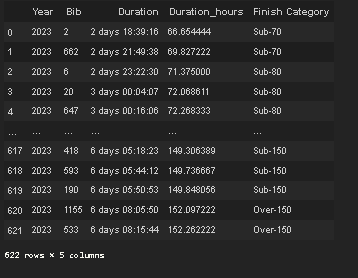

In [109]:
# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_hours'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce').dt.total_seconds() / 3600  # Convert seconds to hours


# Create a new column 'Finish Category'
def categorize_duration(hours):
    if pd.isna(hours):
        return 'DNF'  # Handle NaT values
    elif hours < 120:
        return 'Sub-120'
    elif hours <= 190:
        return f'Sub-{int(hours // 10) * 10 + 10}'  # Round to nearest 10 up to 150
    else:
        return 'Over-150'
    
# Apply categorization with proper indexing
if year == '2022':
    mask = TOR450_dem['Status1'].str.contains('Courmayeur', na=False)
    TOR450_dem.loc[mask, 'Finish Category'] = TOR450_dem.loc[mask, 'Duration_hours'].apply(categorize_duration)
else:
    TOR450_dem['Finish Category'] = TOR450_dem['Duration_hours'].apply(categorize_duration)


# Define the desired order of categories
finish_category_order = [
     'Sub-120', 'Sub-130', 'Sub-140', 'Sub-150', 
    'Sub-160', 'Sub-170', 'Sub-180', 'Sub-190', 
    'Over-190', 'DNF'
]

# Set 'Finish Category' as a categorical column with the defined order
TOR450_dem['Finish Category'] = pd.Categorical(
    TOR450_dem['Finish Category'],
    categories = finish_category_order,
    ordered = True
)


TOR450_dem['Bib'] = TOR450_dem['Bib'].astype('int')
TOR450_dem['Bib'] = TOR450_dem['Bib'].astype('str')
TOR450_dem['PK'] = TOR450_dem['Race'] + '_' + melt_TOR450['Year'] + '_'+ melt_TOR450['Bib'] 



# Display the DataFrame
# TOR450_dem[['Year','Bib', 'Duration', 'Duration_hours', 'Finish Category']]
# TOR450_dem.groupby(['Year', 'Finish Category'])['Finish Category'].count()
count_year_status(TOR450_dem, 'Finish Category')

C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2955472203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_hours'] = pd.to_timedelta(
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2955472203.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Finish Category'] = TOR450_dem['Duration_hours'].apply(categorize_duration)
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2955472203.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Year Finish Category  2021  2022  2023  2024
0            Sub-120     0     0     2     0
1            Sub-130     0     1     1     1
2            Sub-140     2     3     4     1
3            Sub-150     0     4     3     1
4            Sub-160     3     3     7    13
5            Sub-170     7    14    26    10
6            Sub-180     6    11    14    11
7            Sub-190    13    10    32    31
8           Over-190     0     0     0     0
9                DNF    25    97    84   117


# Demographic data

In [110]:
TOR450_more_info = melt_TOR450[['PK', 'Race', 'Year', 'Bib', 'Name', 'Sex', 'Nationality','Category',
       'Status1', 'Retired', 'Retired_Stage', 'Diversion']].drop_duplicates(keep='first')

# Merge the datsets back together
TOR450_dem = TOR450_dem.merge(
    TOR450_more_info[['PK', 'Name', 'Bib', 'Sex', 'Nationality',
                     'Race', 'Year', 'Category',
                     'Status1', 'Retired', 'Retired_Stage', 'Diversion']], 
    on=['PK', 'Name', 'Bib', 'Sex', 'Nationality',
        'Race', 'Year', 'Category'],
    how='left'
)


TOR450_dem = TOR450_dem.reset_index(drop = True)

TOR450_dem[TOR450_dem['Name'] == 'Tierney Paul']

,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Duration,Duration_hours,Duration_seconds,Finish Category,PK,Status1,Retired,Retired_Stage,Diversion
134,Tierney Paul,4063,M,IE,SEN,TOR450,2022,True,5 days 16:23:20,136.388889,491000.0,Sub-140,TOR450_2021_4027,NaN,NaN,NaN,NaN
315,Tierney Paul,4104,M,IE,V1,TOR450,2024,False,NaT,NaN,NaN,DNF,TOR450_2021_4065,NaN,NaN,NaN,NaN
488,Tierney Paul,4163,M,IE,V1,TOR450,2023,True,5 days 15:22:00,135.366667,487320.0,Sub-140,TOR450_2021_4004,NaN,NaN,NaN,NaN


In [111]:
TOR450_dem.groupby('Retired')['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [112]:
TOR450_dem.groupby('Retired_Stage')['Retired_Stage'].count()

Series([], Name: Retired_Stage, dtype: int64)

In [113]:
TOR450_dem.groupby([ 'Retired_Stage', 'Retired'])['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [114]:
melt_TOR450['Retired'] = melt_TOR450['Retired'].fillna('')
melt_TOR450['Retired_Stage'] = melt_TOR450['Retired_Stage'].fillna('')


In [115]:
melt_TOR450 [(melt_TOR450 ['Name'].str.contains('Erika')) &
                   (melt_TOR450 ['Year'] == '2024')
                  ]

,Name,Bib,Sex,Nationality,Race,Year,Category,Place,Time,Status,Aid Station,RITIRIO,Timestamp,Status1,Retired,PK,Retired_Stage,Diversion
11775,Flavelle Erika,4045,F,CA,TOR450,2024,V1,NaN,NaN,True,START,NaN,2024-09-06 20:00:00,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11776,Flavelle Erika,4045,F,CA,TOR450,2024,V1,040 - Rif. Maison Vieille,2024-09-06T21:13:02+02:00,True,Rifugio Maison Vieille,,2024-09-06 21:13:02,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11777,Flavelle Erika,4045,F,CA,TOR450,2024,V1,050 - Rif. Elisabetta,2024-09-06T23:08:19+02:00,True,Rifugio Elisabetta,,2024-09-06 23:08:19,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11778,Flavelle Erika,4045,F,CA,TOR450,2024,V1,060 - Rif. Deffeyes 450,2024-09-07T05:10:26+02:00,True,Rifugio Deffeyes,,2024-09-07 05:10:26,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11779,Flavelle Erika,4045,F,CA,TOR450,2024,V1,070 - Rif. degli Angeli,2024-09-07T12:31:48+02:00,True,Rifugio degli Angeli,,2024-09-07 12:31:48,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11780,Flavelle Erika,4045,F,CA,TOR450,2024,V1,080 - Rif. Bezzi,2024-09-07T17:36:07+02:00,True,Rifugio Bezzi,,2024-09-07 17:36:07,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11781,Flavelle Erika,4045,F,CA,TOR450,2024,V1,090 - Rif. Benevolo,2024-09-07T21:06:33+02:00,True,Rifugio Benevolo,,2024-09-07 21:06:33,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11782,Flavelle Erika,4045,F,CA,TOR450,2024,V1,100 - Rif. Savoia,2024-09-08T00:51:23+02:00,True,Rifugio Savoia,,2024-09-08 00:51:23,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11783,Flavelle Erika,4045,F,CA,TOR450,2024,V1,110 - Rif. Vittorio Emanuele II,2024-09-08T06:38:39+02:00,True,Rifugio Vittorio Emanuele II,,2024-09-08 06:38:39,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route
11784,Flavelle Erika,4045,F,CA,TOR450,2024,V1,120 - Rif. Chabod,2024-09-08T08:39:25+02:00,True,Rifugio Chabod,,2024-09-08 08:39:25,Finished at Courmayeur,,TOR450_2024_4045,,Stage 4 Weather Contingency Route


In [116]:
sub_TOR45_dem = ['PK', 'Race', 'Year', 'Bib', 'Name', 
                 'Status1', 'Status', 'Retired', 'Retired_Stage', 'Diversion']

## Lifebase Data

In [117]:
melt_lifebase_df = melt_TOR450[melt_TOR450['Aid Station'].isin(lifebase_category_order)]

melt_lifebase_df = melt_lifebase_df[ sub_TOR45_dem + [ 'Aid Station', 'Timestamp']]

melt_lifebase_df = melt_lifebase_df.rename(columns={"Aid Station": "Lifebase"}) 

pivot_lifebase_df = melt_lifebase_df.pivot_table(
            index = sub_TOR45_dem,
            columns= 'Lifebase',  
            values='Timestamp',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
    
        ).reset_index()

print(sub_TOR45_dem)
pivot_lifebase_df= pivot_lifebase_df [sub_TOR45_dem + lifebase_category_order ]


melt_lifebase_df = pivot_lifebase_df.melt(id_vars = sub_TOR45_dem, 
                         var_name='Lifebase',   
                         value_name="Timestamp")


# Set 'Finish Category' as a categorical column with the defined order
melt_lifebase_df['Lifebase'] = pd.Categorical(
        melt_lifebase_df['Lifebase'],
        categories = lifebase_category_order,
        ordered = True)

melt_lifebase_df= place_into_stage(melt_lifebase_df, 'Lifebase')

melt_lifebase_df[(melt_lifebase_df['Name'] == 'Tierney Paul') &
                   (melt_lifebase_df['Year'] == '2023')]


['PK', 'Race', 'Year', 'Bib', 'Name', 'Status1', 'Status', 'Retired', 'Retired_Stage', 'Diversion']


,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,Lifebase,Timestamp,Stage
336,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,START,2023-09-08 20:00:00,Stage 1
865,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne IN,NaT,Stage 1
1394,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne OUT,2023-09-10 13:03:53,Time Spent in Cogne
1923,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas IN,2023-09-11 09:22:33,Stage 2
2452,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas OUT,2023-09-11 10:09:28,Time Spent in Donnas
2981,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney IN,2023-09-12 06:43:33,Stage 3
3510,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney OUT,2023-09-12 08:32:19,Time Spent in Gressoney
4039,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,FINISH,2023-09-14 11:22:00,Stage 4


In [118]:
melt_lifebase_df[(melt_lifebase_df['Name'] == 'Tierney Paul')]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,Lifebase,Timestamp,Stage
115,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,START,2022-09-09 20:00:00,Stage 1
336,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,START,2023-09-08 20:00:00,Stage 1
453,TOR450_2024_4104,TOR450,2024,4104,Tierney Paul,DNF,False,Rifugio Deffeyes,Stage 1,As Planned Route,START,2024-09-06 20:00:00,Stage 1
644,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne IN,2022-09-11 12:04:23,Stage 1
865,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne IN,NaT,Stage 1
982,TOR450_2024_4104,TOR450,2024,4104,Tierney Paul,DNF,False,Rifugio Deffeyes,Stage 1,As Planned Route,Cogne IN,NaT,Stage 1
1173,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne OUT,2022-09-11 13:04:11,Time Spent in Cogne
1394,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne OUT,2023-09-10 13:03:53,Time Spent in Cogne
1511,TOR450_2024_4104,TOR450,2024,4104,Tierney Paul,DNF,False,Rifugio Deffeyes,Stage 1,As Planned Route,Cogne OUT,NaT,Time Spent in Cogne
1702,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas IN,2022-09-12 09:38:28,Stage 2


### Checkpoints

In [119]:
melt_checkpoint_df = melt_TOR450[melt_TOR450['Aid Station'].isin(checkpoint_category_order)]

melt_checkpoint_df = melt_checkpoint_df[ sub_TOR45_dem+[ 'Aid Station', 'Timestamp']]

melt_checkpoint_df = melt_checkpoint_df.rename(columns={"Aid Station": "Checkpoint"}) 

pivot_checkpoint_df = melt_checkpoint_df.pivot_table(
            index = sub_TOR45_dem,
            columns= 'Checkpoint',  
            values='Timestamp',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
    
        ).reset_index()

pivot_checkpoint_df= pivot_checkpoint_df [sub_TOR45_dem + checkpoint_category_order]

melt_checkpoint_df = pivot_checkpoint_df.melt(id_vars= sub_TOR45_dem, 
                         var_name='Checkpoint',   
                         value_name="Timestamp")


# Set 'Finish Category' as a categorical column with the defined order
melt_checkpoint_df['Checkpoint'] = pd.Categorical(
        melt_checkpoint_df['Checkpoint'],
        categories = checkpoint_category_order,
        ordered = True)


melt_checkpoint_df = place_into_stage(melt_checkpoint_df, 'Checkpoint')

melt_checkpoint_df[(melt_checkpoint_df['Name'] == 'Tierney Paul') &
                   (melt_checkpoint_df['Year'] == '2023')
                  ]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,Checkpoint,Timestamp,Stage
336,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,START,2023-09-08 20:00:00,Stage 1
865,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne IN,NaT,Stage 1
1394,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne OUT,2023-09-10 13:03:53,Time Spent in Cogne
1923,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas IN,2023-09-11 09:22:33,Stage 2
2452,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas OUT,2023-09-11 10:09:28,Time Spent in Donnas
2981,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney IN,2023-09-12 06:43:33,Stage 3
3510,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney OUT,2023-09-12 08:32:19,Time Spent in Gressoney
4039,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Rifugio Champillon,2023-09-13 20:19:44,Stage 4
4568,TOR450_2023_4163,TOR450,2023,4163,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,FINISH,2023-09-14 11:22:00,Stage 4


## Who missed the Checkpoint Cut OFFs?

## Cutoffs
The cutoffs table was used to establish whether individuals missed the cutoffs or not.


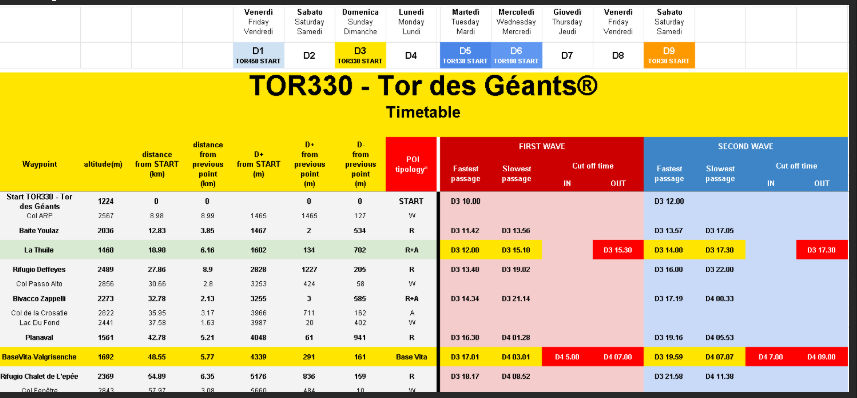


#### Stage Cutoffs
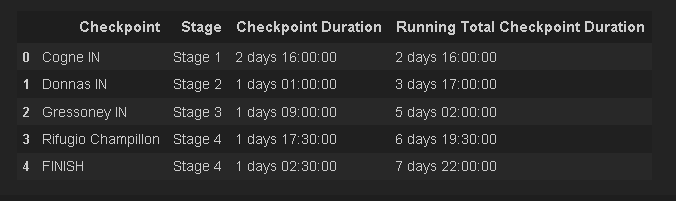
After cleaning the CSV and attaching dates instead of D1/ D2/ D3 etc, this is what the cut off talbe looks like:

#### Dates Cutoffs
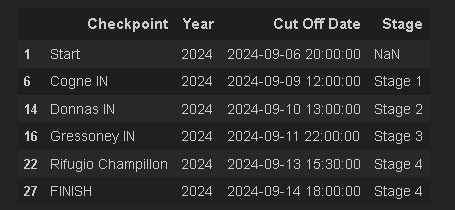

In [120]:
# Saving this 
lifebase_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_lifebase_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Lifebase Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Running Total Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Running Total Lifebase Duration_seconds'], unit='s')

lifebase_cut_offs_df = lifebase_cut_offs_df[['Lifebase',  'Lifebase Duration','Running Total Lifebase Duration']]
lifebase_cut_offs_df


,Lifebase,Lifebase Duration,Running Total Lifebase Duration
0,Cogne IN,2 days 16:00:00,2 days 16:00:00
1,Donnas IN,1 days 01:00:00,3 days 17:00:00
2,Gressoney IN,1 days 09:00:00,5 days 02:00:00
3,FINISH,2 days 20:00:00,7 days 22:00:00


In [121]:
# # Saving this # Saving this 
# aid_station_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_aid_station_cut_offs_df.xlsx')

# # # # # Convert integer seconds to timedelta
# aid_station_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # # Convert integer seconds to timedelta
# aid_station_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

# aid_station_cut_offs_df = aid_station_cut_offs_df[['Checkpoint', 'Stage', 'Checkpoint Duration','Running Total Checkpoint Duration']]
# aid_station_cut_offs_df



In [122]:
# Saving this 
checkpoints_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_checkpoint_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

checkpoints_cut_offs_df = checkpoints_cut_offs_df[['Checkpoint',  'Checkpoint Duration','Running Total Checkpoint Duration']]
checkpoints_cut_offs_df


,Checkpoint,Checkpoint Duration,Running Total Checkpoint Duration
0,Cogne IN,2 days 16:00:00,2 days 16:00:00
1,Donnas IN,1 days 01:00:00,3 days 17:00:00
2,Gressoney IN,1 days 09:00:00,5 days 02:00:00
3,Rifugio Champillon,1 days 17:30:00,6 days 19:30:00
4,FINISH,1 days 02:30:00,7 days 22:00:00


In [123]:
cutoffs_df_pivot = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_aid_station_for_each_year_cut_offs_df.xlsx')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('int')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('str')

    
cutoffs_df_pivot = cutoffs_df_pivot[['Checkpoint', 'Year', 'Cut Off Date']]
cutoffs_df_pivot[cutoffs_df_pivot['Year'] == '2024']

,Checkpoint,Year,Cut Off Date
1,Start,2024,2024-09-06 20:00:00
6,Cogne IN,2024,2024-09-09 12:00:00
14,Donnas IN,2024,2024-09-10 13:00:00
16,Gressoney IN,2024,2024-09-11 22:00:00
22,Rifugio Champillon,2024,2024-09-13 15:30:00
27,FINISH,2024,2024-09-14 18:00:00


### Looking for the Polish Fella!

When I ran TOR 2023, I distingly remember running into a Polish fella as I was leaving Gressoney. I was hiking with him from Rifugio Barma, he was in Wave 1. I remember running up to him at the lifebase, all excited "Hey, you made it!"

The reply I recieved was "WHat are you talking about? I missed the cutoff"

So I began looking for him to find out why I dont have more people who missed the cut off!

Here I am leaving Gressoney!

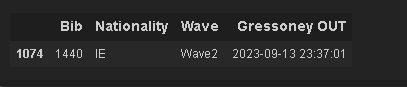

This is the cut off times
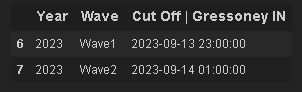

I looked for all the Poles that DNFed the race

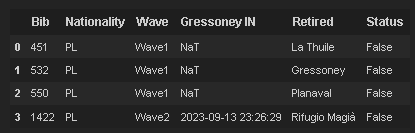

It is clear that he DNFed at 'Gressoney OUT - RITIRIO' 
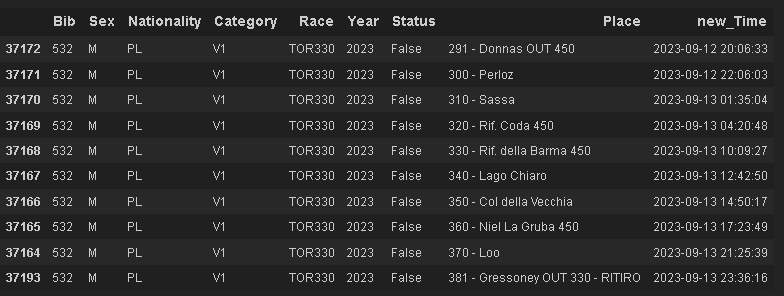
This is what is causing my heartache!



### SOLUTION
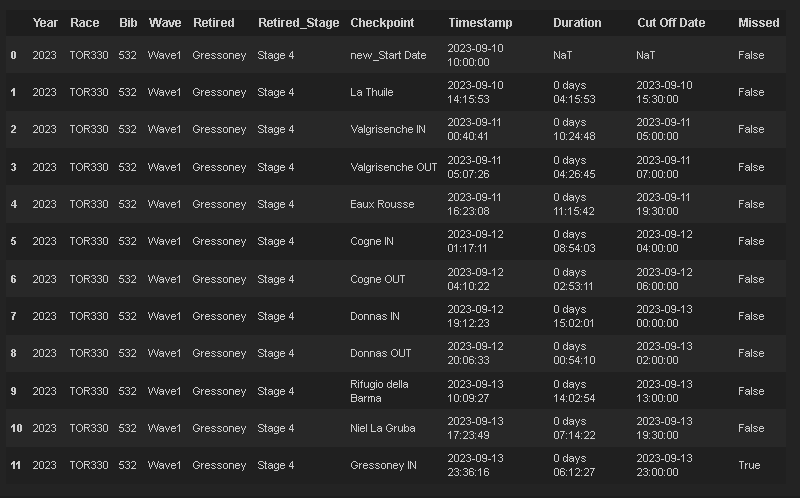


## Missed Cut Off - Function

In [124]:

def checking_cut_offs(df, column, stats_cut_offs_df, category_order):
    # Examining only finishers
    TORX_list = []
    n=0

    for year in years:
        year_df = df[df['Year'] == year]
        print('*'*50, '\n', year)
        for unique_bib in year_df['Bib'].unique(): 

            # Filter the dataframe for the current unique_bib
            bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)


            # Set 'Finish Category' as a categorical column with the defined order
            bib_df[column] = pd.Categorical(
                bib_df[column],
                categories = category_order,
                ordered=True)
            bib_df = bib_df.sort_values(by = column,  ascending =  True)
            

            retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
            n = n+1
            print(n, f'Processing Bib: {unique_bib}')
            # Ensure retired_location is not NaN
            if pd.isna(retired_location):
        #         print(retired_location)
                # Example: Calculating duration for finished participants
                bib_df['Duration'] = bib_df['Timestamp'].diff()
            else:

                # FIxing the Polish fella issue!
                retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
        #         print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
        #         print(bib_df[column].nunique())


                # Iterate over the rows to process the data
                for idx, row in bib_df.iterrows():
                    checkpoint = bib_df.at[idx, column]

                    ############ FIXING THE POLISH MAN 532 issue!
                    if retired_location in checkpoint:
                        # Check if the checkpoint does not contain 'OUT' or 'IN'
                        if 'OUT' in  checkpoint or 'IN' in checkpoint:

                            # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                            if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                                # Locate the 'OUT' checkpoint row
                                out_row = bib_df[bib_df[column] == f"{retired_location} OUT"]
                                # Use the Timestamp from 'OUT'
                                bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]

                                # Make the next Timestamp Nan
                                bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                                print(idx, idx+1)

            bib_df['Duration'] = bib_df['Timestamp'].diff()    

            bib_df['Duration_seconds'] = pd.to_timedelta( bib_df['Duration'], errors='coerce').dt.total_seconds()

            # Extract the start date timestamp
            bib_start_date = bib_df.loc[bib_df[column] == "START", 'Timestamp'].values[0]

            # Calculate running total duration
            bib_df['Running Total Duration'] = bib_df['Timestamp'] - bib_start_date

            # Convert duration to seconds
            bib_df['Running Total Duration_seconds'] = pd.to_timedelta(
                bib_df['Running Total Duration'], errors='coerce'
            ).dt.total_seconds()

            # Append the processed DataFrame to the list
            TORX_list.append(bib_df)
        #     print(f"Processed {n} Bib(s).", unique_bib)

    # Combine all results into one DataFrame
    if TORX_list:
        final_df = pd.concat(TORX_list, ignore_index=True)
        print("Combined DataFrame created.")
    else:
        final_df = pd.DataFrame()
        print("No DataFrames were processed.")

    print(final_df.columns)
    print(cutoffs_df_pivot.columns)

    if column == 'Checkpoint':

        final_df = final_df.merge(
            cutoffs_df_pivot,
            on=[column,  'Year'],
            how='left')


        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Checkpoint'] == final_df['Retired'] + ' IN') |
            (final_df['Checkpoint'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 

        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')    
        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 

        print( '\n', final_df[final_df['Bib'] == 1], '\n')



    elif column == 'Lifebase':
        final_df = final_df.rename(columns={"Lifebase": "Checkpoint"}) 

        print(f'column == {column}')
        final_df = final_df.merge(
            cutoffs_df_pivot,
            right_on=['Checkpoint',  'Year'],
            left_on=['Checkpoint',  'Year'],
            how='left')       
        final_df = final_df.rename(columns={"Checkpoint": "Lifebase"}) 

        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Lifebase'] == final_df['Retired'] + ' IN') |
            (final_df['Lifebase'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 

        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')  

        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 



    else:
        print('BOo')


            # Compare 'Timestamp' with the cutoff
    final_df['Missed'] = final_df['Timestamp'] >   final_df['Cut Off Date']
    final_df['Missed Diff'] = np.where(
        final_df['Timestamp'] > final_df['Cut Off Date'],
        final_df['Timestamp'] - final_df['Cut Off Date'],
        pd.NaT  # Ensure missing values are compatible with timedelta64
    )

    print(final_df[final_df['Timestamp'] > final_df['Cut Off Date']])

    # Explicitly cast 'Missed Diff' to timedelta64[ns] to enforce the type
    final_df['Missed Diff'] = final_df['Missed Diff'].astype('timedelta64[ns]')
#     final_df['Missed Last Checkpoint'] = final_df['Missed Last Checkpoint'].fillna(False)


    # tableau prep
    final_df['Missed Diff_seconds'] = pd.to_timedelta(
        final_df['Missed Diff'], errors='coerce').dt.total_seconds()

    if column  == 'Checkpoint':
        final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &
                            ~(final_df['Retired'].isna()) &
                            ~(final_df['Checkpoint' ].str.contains(' OUT')) &
                            ~(final_df['Checkpoint' ].str.contains(' IN')) &
                            ( final_df['Checkpoint' ] ==  final_df['Retired'])] = True  

    return final_df

### Checkpoints

In [125]:
melt_checkpoint_df[(melt_checkpoint_df['Name'] == 'Tierney Paul') &
                  (melt_checkpoint_df['Year'] == '2022')]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,Checkpoint,Timestamp,Stage
115,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,START,2022-09-09 20:00:00,Stage 1
644,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne IN,2022-09-11 12:04:23,Stage 1
1173,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Cogne OUT,2022-09-11 13:04:11,Time Spent in Cogne
1702,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas IN,2022-09-12 09:38:28,Stage 2
2231,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Donnas OUT,2022-09-12 10:39:37,Time Spent in Donnas
2760,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney IN,2022-09-13 07:50:47,Stage 3
3289,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Gressoney OUT,2022-09-13 09:50:18,Time Spent in Gressoney
3818,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,Rifugio Champillon,2022-09-14 20:39:10,Stage 4
4347,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,FINISH,2022-09-15 12:23:20,Stage 4


In [126]:
checkpoints_bib_df = checking_cut_offs(melt_checkpoint_df, 'Checkpoint', 
                                       checkpoints_cut_offs_df , checkpoint_category_order)

************************************************** 
 2021
1 Processing Bib: 4001
2 Processing Bib: 4003
3 Processing Bib: 4004
4 Processing Bib: 4005
5 Processing Bib: 4006
6 Processing Bib: 4008
7 Processing Bib: 4009
8 Processing Bib: 4010
9 Processing Bib: 4011
10 Processing Bib: 4012
11 Processing Bib: 4014
12 Processing Bib: 4015
13 Processing Bib: 4016
14 Processing Bib: 4017
15 Processing Bib: 4018
16 Processing Bib: 4019
17 Processing Bib: 4020
18 Processing Bib: 4021
19 Processing Bib: 4023
20 Processing Bib: 4024
21 Processing Bib: 4025
22 Processing Bib: 4026
23 Processing Bib: 4027
24 Processing Bib: 4028
25 Processing Bib: 4029
26 Processing Bib: 4030
27 Processing Bib: 4031
28 Processing Bib: 4032
29 Processing Bib: 4034
30 Processing Bib: 4035
31 Processing Bib: 4036
32 Processing Bib: 4037
33 Processing Bib: 4038
34 Processing Bib: 4039
35 Processing Bib: 4040
36 Processing Bib: 4042
37 Processing Bib: 4043
38 Processing Bib: 4044
39 Processing Bib: 4045
40 Processing B

336 Processing Bib: 4162
337 Processing Bib: 4163
338 Processing Bib: 4164
339 Processing Bib: 4165
340 Processing Bib: 4166
341 Processing Bib: 4167
342 Processing Bib: 4168
343 Processing Bib: 4169
344 Processing Bib: 4170
345 Processing Bib: 4171
346 Processing Bib: 4172
347 Processing Bib: 4173
348 Processing Bib: 4174
349 Processing Bib: 4175
350 Processing Bib: 4176
351 Processing Bib: 4177
352 Processing Bib: 4178
353 Processing Bib: 4179
354 Processing Bib: 4180
355 Processing Bib: 4181
356 Processing Bib: 4182
357 Processing Bib: 4185
358 Processing Bib: 4186
359 Processing Bib: 4187
360 Processing Bib: 4188
************************************************** 
 2024
361 Processing Bib: 4001
362 Processing Bib: 4002
363 Processing Bib: 4003
364 Processing Bib: 4004
365 Processing Bib: 4006
366 Processing Bib: 4007
367 Processing Bib: 4008
368 Processing Bib: 4009
369 Processing Bib: 4010
370 Processing Bib: 4011
371 Processing Bib: 4012
372 Processing Bib: 4013
373 Processing Bi

C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\608151596.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &


In [127]:
checkpoints_bib_df['Missed Last Checkpoint'].unique()

array([False,  True])

In [128]:
checkpoints_bib_df.columns

Index(['PK', 'Race', 'Year', 'Bib', 'Name', 'Status1', 'Status', 'Retired',
       'Retired_Stage', 'Diversion', 'Checkpoint', 'Timestamp', 'Stage',
       'Duration', 'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds'],
      dtype='object')

In [129]:
checkpoints_bib_df[(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                  (checkpoints_bib_df['Year'] == '2022')]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
1035,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,NaN,0 days 00:00:00,0.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
1036,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,144263.0,1 days 16:04:23,144263.0,2022-09-12 12:00:00,False,2 days 16:00:00,Within Allocated Time,False,NaT,NaN
1037,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,3588.0,1 days 17:04:11,147851.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
1038,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,74057.0,2 days 13:38:28,221908.0,2022-09-13 13:00:00,False,1 days 01:00:00,Within Allocated Time,False,NaT,NaN
1039,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,3669.0,2 days 14:39:37,225577.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
1040,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,76270.0,3 days 11:50:47,301847.0,2022-09-14 22:00:00,False,1 days 09:00:00,Within Allocated Time,False,NaT,NaN
1041,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,7171.0,3 days 13:50:18,309018.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
1042,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,125332.0,5 days 00:39:10,434350.0,2022-09-16 15:30:00,False,1 days 17:30:00,Within Allocated Time,False,NaT,NaN
1043,TOR450_2022_4063,TOR450,2022,4063,Tierney Paul,Finished at Courmayeur,True,,,As Planned Route,...,56650.0,5 days 16:23:20,491000.0,2022-09-17 18:00:00,False,1 days 02:30:00,Within Allocated Time,False,NaT,NaN


In [130]:
tierney_df = checkpoints_bib_df[(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                  (checkpoints_bib_df['Year'] == '2022')]
# tierney_df['DIFF'] = tierney_df['Timestamp'].diff()
tierney_df[['Name', 'Bib', 'Race', 'Year', 'Status', 'Checkpoint', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds',  'Stage',
      'Checkpoint Duration']]

,Name,Bib,Race,Year,Status,Checkpoint,Timestamp,Duration,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Stage,Checkpoint Duration
1035,Tierney Paul,4063,TOR450,2022,True,START,2022-09-09 20:00:00,NaT,NaN,0 days 00:00:00,0.0,Stage 1,NaT
1036,Tierney Paul,4063,TOR450,2022,True,Cogne IN,2022-09-11 12:04:23,1 days 16:04:23,144263.0,1 days 16:04:23,144263.0,Stage 1,2 days 16:00:00
1037,Tierney Paul,4063,TOR450,2022,True,Cogne OUT,2022-09-11 13:04:11,0 days 00:59:48,3588.0,1 days 17:04:11,147851.0,Time Spent in Cogne,NaT
1038,Tierney Paul,4063,TOR450,2022,True,Donnas IN,2022-09-12 09:38:28,0 days 20:34:17,74057.0,2 days 13:38:28,221908.0,Stage 2,1 days 01:00:00
1039,Tierney Paul,4063,TOR450,2022,True,Donnas OUT,2022-09-12 10:39:37,0 days 01:01:09,3669.0,2 days 14:39:37,225577.0,Time Spent in Donnas,NaT
1040,Tierney Paul,4063,TOR450,2022,True,Gressoney IN,2022-09-13 07:50:47,0 days 21:11:10,76270.0,3 days 11:50:47,301847.0,Stage 3,1 days 09:00:00
1041,Tierney Paul,4063,TOR450,2022,True,Gressoney OUT,2022-09-13 09:50:18,0 days 01:59:31,7171.0,3 days 13:50:18,309018.0,Time Spent in Gressoney,NaT
1042,Tierney Paul,4063,TOR450,2022,True,Rifugio Champillon,2022-09-14 20:39:10,1 days 10:48:52,125332.0,5 days 00:39:10,434350.0,Stage 4,1 days 17:30:00
1043,Tierney Paul,4063,TOR450,2022,True,FINISH,2022-09-15 12:23:20,0 days 15:44:10,56650.0,5 days 16:23:20,491000.0,Stage 4,1 days 02:30:00


### Time Travel Issues
I filtered the data to spot any time travel moments!

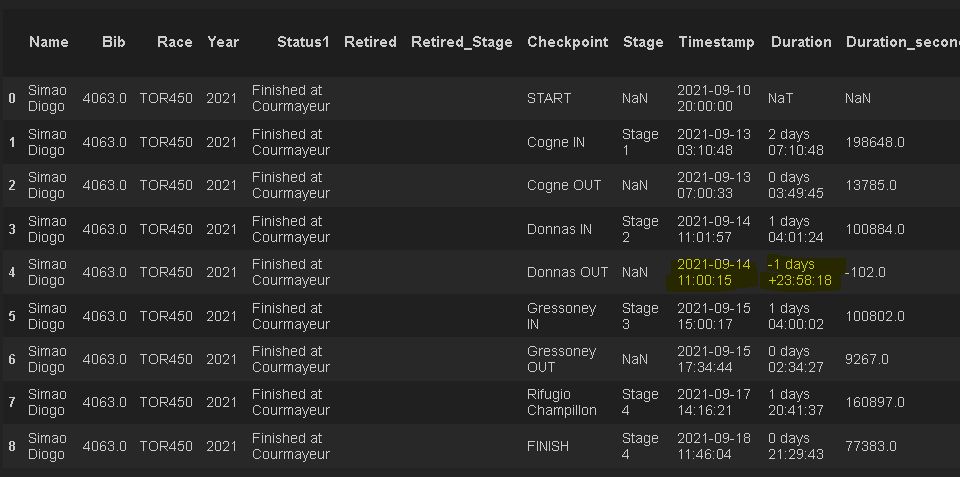

### Solution
Replacing the negative value with NAN
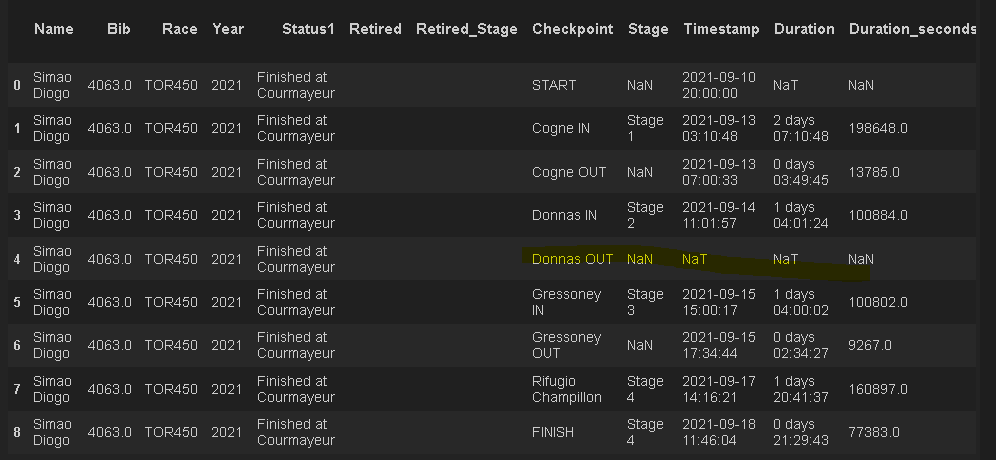

##### Time Travel issues in Checkpoint

In [131]:
unique_bibs_with_negative_values_in_checkpoints_bib_df = list(checkpoints_bib_df['Bib'][checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_checkpoints_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_checkpoints_bib_df]

checkpoints_bib_df[checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
481,TOR450_2021_4063,TOR450,2021,4063,Simao Diogo,Finished at Courmayeur,True,,,As Planned Route,...,-102.0,3 days 15:00:15,313215.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN


In [132]:
unique_bibs_with_negative_values_in_checkpoints_bib_df

[4063]

In [133]:

checkpoints_bib_df[['Name', 'Bib', 'Race', 'Year', 'Status1', 'Retired',
       'Retired_Stage', 'Checkpoint','Stage', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds']][(checkpoints_bib_df['Bib'] == '4063') & 
                                          (checkpoints_bib_df['Year'] == '2021')].reset_index(drop = True)

,Name,Bib,Race,Year,Status1,Retired,Retired_Stage,Checkpoint,Stage,Timestamp,Duration,Duration_seconds,Running Total Duration,Running Total Duration_seconds
0,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,START,Stage 1,2021-09-10 20:00:00,NaT,NaN,0 days 00:00:00,0.0
1,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Cogne IN,Stage 1,2021-09-13 03:10:48,2 days 07:10:48,198648.0,2 days 07:10:48,198648.0
2,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Cogne OUT,Time Spent in Cogne,2021-09-13 07:00:33,0 days 03:49:45,13785.0,2 days 11:00:33,212433.0
3,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Donnas IN,Stage 2,2021-09-14 11:01:57,1 days 04:01:24,100884.0,3 days 15:01:57,313317.0
4,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Donnas OUT,Time Spent in Donnas,2021-09-14 11:00:15,-1 days +23:58:18,-102.0,3 days 15:00:15,313215.0
5,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Gressoney IN,Stage 3,2021-09-15 15:00:17,1 days 04:00:02,100802.0,4 days 19:00:17,414017.0
6,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Gressoney OUT,Time Spent in Gressoney,2021-09-15 17:34:44,0 days 02:34:27,9267.0,4 days 21:34:44,423284.0
7,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Rifugio Champillon,Stage 4,2021-09-17 14:16:21,1 days 20:41:37,160897.0,6 days 18:16:21,584181.0
8,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,FINISH,Stage 4,2021-09-18 11:46:04,0 days 21:29:43,77383.0,7 days 15:46:04,661564.0


In [134]:
fixing_negative_duration(checkpoints_bib_df)

In [135]:
checkpoints_bib_df =  calculating_banked_time(checkpoints_bib_df, checkpoints_cut_offs_df, 'Checkpoint')
checkpoints_bib_df.head(20)

Empty DataFrame
Columns: []
Index: [Bib, Checkpoint, Running Total Checkpoint Duration, Running Total Duration, Banking Time]


,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Cut Off Date,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Checkpoint Duration,Banking Time,Banking Time_seconds
0,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
1,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2021-09-13 12:00:00,False,2 days 16:00:00,Within Allocated Time,False,NaT,NaN,2 days 16:00:00,0 days 23:33:30,84810.0
2,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
3,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2021-09-14 13:00:00,False,1 days 01:00:00,Within Allocated Time,False,NaT,NaN,3 days 17:00:00,1 days 00:41:13,88873.0
4,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
5,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2021-09-15 22:00:00,False,1 days 09:00:00,Within Allocated Time,False,NaT,NaN,5 days 02:00:00,1 days 11:27:36,127656.0
6,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
7,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2021-09-17 15:30:00,False,1 days 17:30:00,Within Allocated Time,False,NaT,NaN,6 days 19:30:00,1 days 16:36:36,146196.0
8,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2021-09-18 18:00:00,False,1 days 02:30:00,Within Allocated Time,False,NaT,NaN,7 days 22:00:00,2 days 03:42:00,186120.0
9,TOR450_2021_4003,TOR450,2021,4003,Plavan Marina,Finished at Courmayeur,True,,,As Planned Route,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN


In [136]:
checkpoints_bib_df[['Name', 'Bib', 'Race', 'Year', 'Checkpoint', 'Stage', 'Status1', 'Status', 'Retired',
       'Retired_Stage', 'Diversion', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds', 'Running Total Checkpoint Duration',
       'Banking Time', 'Banking Time_seconds']].head(20)

,Name,Bib,Race,Year,Checkpoint,Stage,Status1,Status,Retired,Retired_Stage,...,Cut Off Date,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Checkpoint Duration,Banking Time,Banking Time_seconds
0,Papi Luca,4001,TOR450,2021,START,Stage 1,Finished at Courmayeur,True,,,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
1,Papi Luca,4001,TOR450,2021,Cogne IN,Stage 1,Finished at Courmayeur,True,,,...,2021-09-13 12:00:00,False,2 days 16:00:00,Within Allocated Time,False,NaT,NaN,2 days 16:00:00,0 days 23:33:30,84810.0
2,Papi Luca,4001,TOR450,2021,Cogne OUT,Time Spent in Cogne,Finished at Courmayeur,True,,,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
3,Papi Luca,4001,TOR450,2021,Donnas IN,Stage 2,Finished at Courmayeur,True,,,...,2021-09-14 13:00:00,False,1 days 01:00:00,Within Allocated Time,False,NaT,NaN,3 days 17:00:00,1 days 00:41:13,88873.0
4,Papi Luca,4001,TOR450,2021,Donnas OUT,Time Spent in Donnas,Finished at Courmayeur,True,,,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
5,Papi Luca,4001,TOR450,2021,Gressoney IN,Stage 3,Finished at Courmayeur,True,,,...,2021-09-15 22:00:00,False,1 days 09:00:00,Within Allocated Time,False,NaT,NaN,5 days 02:00:00,1 days 11:27:36,127656.0
6,Papi Luca,4001,TOR450,2021,Gressoney OUT,Time Spent in Gressoney,Finished at Courmayeur,True,,,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN
7,Papi Luca,4001,TOR450,2021,Rifugio Champillon,Stage 4,Finished at Courmayeur,True,,,...,2021-09-17 15:30:00,False,1 days 17:30:00,Within Allocated Time,False,NaT,NaN,6 days 19:30:00,1 days 16:36:36,146196.0
8,Papi Luca,4001,TOR450,2021,FINISH,Stage 4,Finished at Courmayeur,True,,,...,2021-09-18 18:00:00,False,1 days 02:30:00,Within Allocated Time,False,NaT,NaN,7 days 22:00:00,2 days 03:42:00,186120.0
9,Plavan Marina,4003,TOR450,2021,START,Stage 1,Finished at Courmayeur,True,,,...,NaT,False,NaT,Within Allocated Time,False,NaT,NaN,NaT,NaT,NaN


### Adding information related to the last missed cut off to TOR450 Dem

In [137]:
# Merge the datsets back after pivoting
TOR450_dem = TOR450_dem.merge(
    checkpoints_bib_df[[ 'Year', 'Race',  'Bib',  'Missed Last Checkpoint',
                        'Missed Diff',  'Missed Diff_seconds']][(checkpoints_bib_df['Missed Last Checkpoint'] == True)],
    on=['Year', 'Race','Bib'],
    how='left')


TOR450_dem = TOR450_dem.reset_index(drop = True)

TOR450_dem

,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Duration,Duration_hours,Duration_seconds,Finish Category,PK,Status1,Retired,Retired_Stage,Diversion,Missed Last Checkpoint,Missed Diff,Missed Diff_seconds
0,Adam Eric,4052,M,AT,V1,TOR450,2022,True,7 days 13:01:00,181.016667,651660.0,Sub-190,TOR450_2021_4001,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,Ador Thierry,4005,M,FR,V2,TOR450,2022,False,NaT,NaN,NaN,DNF,TOR450_2021_4001,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,Ageorges Fabrice,4025,M,FR,V1,TOR450,2022,False,NaT,NaN,NaN,DNF,TOR450_2021_4001,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,Anderson John,4072,M,US,V1,TOR450,2022,True,6 days 17:33:50,161.563889,581630.0,Sub-170,TOR450_2021_4001,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,Angel Andrade Julio Cesar,4137,M,MX,V2,TOR450,2022,False,NaT,NaN,NaN,DNF,TOR450_2021_4001,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Traina Christophe,4034,M,BE,V1,TOR450,2021,True,7 days 17:00:24,185.006667,666024.0,Sub-190,TOR450_2021_4026,NaN,NaN,NaN,NaN,NaN,NaT,NaN
553,Tribolo Philippe,4039,M,FR,V1,TOR450,2021,True,7 days 16:24:31,184.408611,663871.0,Sub-190,TOR450_2021_4026,NaN,NaN,NaN,NaN,NaN,NaT,NaN
554,Urizar Jose Lorenzo,4051,M,GT,V2,TOR450,2021,False,NaT,NaN,NaN,DNF,TOR450_2021_4026,NaN,NaN,NaN,NaN,NaN,NaT,NaN
555,Van Der Hoeven Jan Jilles,4016,M,AE,V2,TOR450,2021,False,NaT,NaN,NaN,DNF,TOR450_2021_4026,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [138]:
TOR450_dem.groupby('Retired')['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [139]:
TOR450_dem.groupby('Diversion')['Diversion'].count()

Diversion
As Planned Route    1
Name: Diversion, dtype: int64

In [140]:
TOR450_dem.groupby(['Retired_Stage'])['Retired_Stage'].count()

Series([], Name: Retired_Stage, dtype: int64)

#### Which Finishers missed the cut off?

In [141]:
checkpoints_bib_df[(checkpoints_bib_df['Missed'] == True) &
                  (checkpoints_bib_df['Retired'].isna())]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Cut Off Date,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Checkpoint Duration,Banking Time,Banking Time_seconds


### Lifebase DF

In [142]:
lifebase_bib_df = checking_cut_offs(melt_lifebase_df, 'Lifebase', lifebase_cut_offs_df, lifebase_category_order )
lifebase_bib_df.head(20)

************************************************** 
 2021
1 Processing Bib: 4001
2 Processing Bib: 4003
3 Processing Bib: 4004
4 Processing Bib: 4005
5 Processing Bib: 4006
6 Processing Bib: 4008
7 Processing Bib: 4009
8 Processing Bib: 4010
9 Processing Bib: 4011
10 Processing Bib: 4012
11 Processing Bib: 4014
12 Processing Bib: 4015
13 Processing Bib: 4016
14 Processing Bib: 4017
15 Processing Bib: 4018
16 Processing Bib: 4019
17 Processing Bib: 4020
18 Processing Bib: 4021
19 Processing Bib: 4023
20 Processing Bib: 4024
21 Processing Bib: 4025
22 Processing Bib: 4026
23 Processing Bib: 4027
24 Processing Bib: 4028
25 Processing Bib: 4029
26 Processing Bib: 4030
27 Processing Bib: 4031
28 Processing Bib: 4032
29 Processing Bib: 4034
30 Processing Bib: 4035
31 Processing Bib: 4036
32 Processing Bib: 4037
33 Processing Bib: 4038
34 Processing Bib: 4039
35 Processing Bib: 4040
36 Processing Bib: 4042
37 Processing Bib: 4043
38 Processing Bib: 4044
39 Processing Bib: 4045
40 Processing B

331 Processing Bib: 4157
332 Processing Bib: 4158
333 Processing Bib: 4159
334 Processing Bib: 4160
335 Processing Bib: 4161
336 Processing Bib: 4162
337 Processing Bib: 4163
338 Processing Bib: 4164
339 Processing Bib: 4165
340 Processing Bib: 4166
341 Processing Bib: 4167
342 Processing Bib: 4168
343 Processing Bib: 4169
344 Processing Bib: 4170
345 Processing Bib: 4171
346 Processing Bib: 4172
347 Processing Bib: 4173
348 Processing Bib: 4174
349 Processing Bib: 4175
350 Processing Bib: 4176
351 Processing Bib: 4177
352 Processing Bib: 4178
353 Processing Bib: 4179
354 Processing Bib: 4180
355 Processing Bib: 4181
356 Processing Bib: 4182
357 Processing Bib: 4185
358 Processing Bib: 4186
359 Processing Bib: 4187
360 Processing Bib: 4188
************************************************** 
 2024
361 Processing Bib: 4001
362 Processing Bib: 4002
363 Processing Bib: 4003
364 Processing Bib: 4004
365 Processing Bib: 4006
366 Processing Bib: 4007
367 Processing Bib: 4008
368 Processing Bi

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
0,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,NaN,0 days 00:00:00,0.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
1,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,145590.0,1 days 16:26:30,145590.0,2021-09-13 12:00:00,False,2 days 16:00:00,Within Allocated Time,False,NaT,NaN
2,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2909.0,1 days 17:14:59,148499.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
3,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,83028.0,2 days 16:18:47,231527.0,2021-09-14 13:00:00,False,1 days 01:00:00,Within Allocated Time,False,NaT,NaN
4,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,2769.0,2 days 17:04:56,234296.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
5,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,77248.0,3 days 14:32:24,311544.0,2021-09-15 22:00:00,False,1 days 09:00:00,Within Allocated Time,False,NaT,NaN
6,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,4018.0,3 days 15:39:22,315562.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
7,TOR450_2021_4001,TOR450,2021,4001,Papi Luca,Finished at Courmayeur,True,,,As Planned Route,...,182318.0,5 days 18:18:00,497880.0,2021-09-18 18:00:00,False,2 days 20:00:00,Within Allocated Time,False,NaT,NaN
8,TOR450_2021_4003,TOR450,2021,4003,Plavan Marina,Finished at Courmayeur,True,,,As Planned Route,...,NaN,0 days 00:00:00,0.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN
9,TOR450_2021_4003,TOR450,2021,4003,Plavan Marina,Finished at Courmayeur,True,,,As Planned Route,...,170973.0,1 days 23:29:33,170973.0,2021-09-13 12:00:00,False,2 days 16:00:00,Within Allocated Time,False,NaT,NaN


##### Time Travel issues in Lifebase DF 

In [143]:
unique_bibs_with_negative_values_in_lifebase_bib_df = list(lifebase_bib_df['Bib'][lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_lifebase_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_lifebase_bib_df]

lifebase_bib_df[lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
428,TOR450_2021_4063,TOR450,2021,4063,Simao Diogo,Finished at Courmayeur,True,,,As Planned Route,...,-102.0,3 days 15:00:15,313215.0,NaT,False,NaT,Within Allocated Time,False,NaT,NaN


In [144]:
lifebase_bib_df[['Name', 'Bib', 'Race', 'Year', 'Status1', 'Retired',
       'Retired_Stage', 'Lifebase','Stage', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds']][(lifebase_bib_df['Bib'] == '4063') & 
                                          (lifebase_bib_df['Year'] == '2021')].reset_index(drop = True)

,Name,Bib,Race,Year,Status1,Retired,Retired_Stage,Lifebase,Stage,Timestamp,Duration,Duration_seconds,Running Total Duration,Running Total Duration_seconds
0,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,START,Stage 1,2021-09-10 20:00:00,NaT,NaN,0 days 00:00:00,0.0
1,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Cogne IN,Stage 1,2021-09-13 03:10:48,2 days 07:10:48,198648.0,2 days 07:10:48,198648.0
2,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Cogne OUT,Time Spent in Cogne,2021-09-13 07:00:33,0 days 03:49:45,13785.0,2 days 11:00:33,212433.0
3,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Donnas IN,Stage 2,2021-09-14 11:01:57,1 days 04:01:24,100884.0,3 days 15:01:57,313317.0
4,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Donnas OUT,Time Spent in Donnas,2021-09-14 11:00:15,-1 days +23:58:18,-102.0,3 days 15:00:15,313215.0
5,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Gressoney IN,Stage 3,2021-09-15 15:00:17,1 days 04:00:02,100802.0,4 days 19:00:17,414017.0
6,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,Gressoney OUT,Time Spent in Gressoney,2021-09-15 17:34:44,0 days 02:34:27,9267.0,4 days 21:34:44,423284.0
7,Simao Diogo,4063,TOR450,2021,Finished at Courmayeur,,,FINISH,Stage 4,2021-09-18 11:46:04,2 days 18:11:20,238280.0,7 days 15:46:04,661564.0


In [145]:
fixing_negative_duration(lifebase_bib_df)

lifebase_bib_df[(lifebase_bib_df['Bib'].isin(unique_bibs_with_negative_values_in_lifebase_bib_df ))]

,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Duration_seconds,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds


In [146]:
lifebase_bib_df = calculating_banked_time(lifebase_bib_df, lifebase_cut_offs_df, 'Lifebase')
lifebase_bib_df.head(20)
lifebase_bib_df[lifebase_bib_df['Banking Time']  < pd.to_timedelta('00:00:00')] 


Empty DataFrame
Columns: []
Index: [Bib, Lifebase, Running Total Lifebase Duration, Running Total Duration, Banking Time]


,PK,Race,Year,Bib,Name,Status1,Status,Retired,Retired_Stage,Diversion,...,Cut Off Date,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Lifebase Duration,Banking Time,Banking Time_seconds
851,TOR450_2022_4054,TOR450,2022,4054,Rovelli Roberto,DNF,False,Sassa,Stage 3,As Planned Route,...,2022-09-13 13:00:00,False,1 days 01:00:00,Outside Allocated Time,True,0 days 00:33:44,2024.0,3 days 17:00:00,-1 days +23:26:16,-2024.0
971,TOR450_2022_4069,TOR450,2022,4069,Martinez Rodriguez Jose,DNF,False,Rifugio Prarayer,Stage 4,As Planned Route,...,2022-09-13 13:00:00,False,1 days 01:00:00,Outside Allocated Time,True,0 days 00:02:56,176.0,3 days 17:00:00,-1 days +23:57:04,-176.0
1019,TOR450_2022_4076,TOR450,2022,4076,Locatelli Michele Oriele,DNF,False,Sassa,Stage 3,As Planned Route,...,2022-09-13 13:00:00,False,1 days 01:00:00,Outside Allocated Time,True,0 days 00:33:54,2034.0,3 days 17:00:00,-1 days +23:26:06,-2034.0
1035,TOR450_2022_4079,TOR450,2022,4079,Cirla Marco,DNF,False,Donnas,Stage 2,As Planned Route,...,2022-09-13 13:00:00,True,1 days 01:00:00,Within Allocated Time,True,0 days 01:57:00,7020.0,3 days 17:00:00,-1 days +22:03:00,-7020.0
1595,TOR450_2023_4014,TOR450,2023,4014,Jacek Fugiel,DNF,False,Donnas,Stage 2,As Planned Route,...,2023-09-12 13:00:00,True,1 days 01:00:00,Outside Allocated Time,True,0 days 00:21:52,1312.0,3 days 17:00:00,-1 days +23:38:08,-1312.0
1667,TOR450_2023_4023,TOR450,2023,4023,Hacking Hugh,DNF,False,Donnas,Stage 2,As Planned Route,...,2023-09-12 13:00:00,True,1 days 01:00:00,Outside Allocated Time,True,0 days 06:08:04,22084.0,3 days 17:00:00,-1 days +17:51:56,-22084.0
1771,TOR450_2023_4037,TOR450,2023,4037,Kinsbergen Robin,DNF,False,Donnas,Stage 2,As Planned Route,...,2023-09-12 13:00:00,True,1 days 01:00:00,Outside Allocated Time,True,0 days 00:16:09,969.0,3 days 17:00:00,-1 days +23:43:51,-969.0
2099,TOR450_2023_4085,TOR450,2023,4085,Compagnoni Gustavo Fernando,DNF,False,Donnas,Stage 2,As Planned Route,...,2023-09-12 13:00:00,True,1 days 01:00:00,Outside Allocated Time,True,0 days 02:54:26,10466.0,3 days 17:00:00,-1 days +21:05:34,-10466.0
2179,TOR450_2023_4096,TOR450,2023,4096,De Biase Anna,DNF,False,Gressoney,Stage 4,As Planned Route,...,2023-09-12 13:00:00,False,1 days 01:00:00,Outside Allocated Time,True,0 days 01:03:27,3807.0,3 days 17:00:00,-1 days +22:56:33,-3807.0
2525,TOR450_2023_4139,TOR450,2023,4139,Taguchi Minori,DNF,False,Gressoney,Stage 4,As Planned Route,...,2023-09-13 22:00:00,True,1 days 09:00:00,Outside Allocated Time,True,0 days 00:40:00,2400.0,5 days 02:00:00,-1 days +23:20:00,-2400.0


### Aid Station DF

In [147]:

def checking_aid_stations(df, column):
    # Examining only finishers
    TORX_list = []
    n=0
    
    for year in years:
        year_df = df[df['Year'] == year]
        print('*'*50, '\n', year)
        for unique_bib in year_df['Bib'].unique(): 

            # Filter the dataframe for the current unique_bib
            bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)
            bib_df = bib_df.sort_values(by = 'Timestamp', ascending =  True)
            bib_df[f'{column}_copy'] = bib_df[column].copy()
            n = n+1
            
            retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
            diversion = year_df['Diversion'][year_df['Bib'] == unique_bib].values[0]

            print('*'*30)
            print(unique_bib, year, diversion)
            if diversion  == 'Stage 4 Weather Contigency Route' :
                
                print(n, f'Processing Bib: {unique_bib}')

                # Set 'Finish Category' as a categorical column with the defined order
                bib_df[column] = pd.Categorical(
                    bib_df[column],
                    categories = weather_contigency_route,
                    ordered=True)

            elif diversion  == 'As Planned Route':
#                 print(bib_df[column].unique())
                # Set 'Finish Category' as a categorical column with the defined order
                bib_df[column] = pd.Categorical(
                    bib_df[column],
                    categories = aid_station_category_order,
                    ordered=True)
            else:
                print('diverstion didnt work!')
                print(bib_df[column].unique())
                bib_df_columns = list(bib_df[column].unique())
                
                for bib_df_column in bib_df_columns:
                    if bib_df_column in weather_contigency_route:
                        pass
                    elif bib_df_column in aid_station_category_order:
                        pass
                    else:
                        print(bib_df_column)
            
            # Ensure retired_location is not NaN
            if pd.isna(retired_location):
        #         print(retired_location)
                # Example: Calculating duration for finished participants
                bib_df['Duration'] = bib_df['Timestamp'].diff()
            else:

                # FIxing the Polish fella issue!
                retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
#                 print(retired_location)
        #         print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
        #         print(bib_df[column].nunique())


                # Iterate over the rows to process the data
                for idx, row in bib_df.iterrows():
#                     print( bib_df.at[idx, column])
                    checkpoint = bib_df.at[idx, column]


                    ############ FIXING THE POLISH MAN 532 issue!
                    if pd.isna(checkpoint):
                        pass
                    elif retired_location in checkpoint:
                        # Check if the checkpoint does not contain 'OUT' or 'IN'
                        if 'OUT' in  checkpoint or 'IN' in checkpoint:

                            # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                            if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                                # Locate the 'OUT' checkpoint row
                                out_row = bib_df[bib_df[column] == f"{retired_location} OUT"]
                                # Use the Timestamp from 'OUT'
                                bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]

                                # Make the next Timestamp Nan
                                bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                                print(idx, idx+1)

            bib_df['Duration'] = bib_df['Timestamp'].diff()    

            bib_df['Duration_seconds'] = pd.to_timedelta( bib_df['Duration'], errors='coerce').dt.total_seconds()

            # Extract the start date timestamp
            bib_start_date = bib_df.loc[bib_df[column] == "START", 'Timestamp'].values[0]

            # Calculate running total duration
            bib_df['Running Total Duration'] = bib_df['Timestamp'] - bib_start_date

            # Convert duration to seconds
            bib_df['Running Total Duration_seconds'] = pd.to_timedelta(
                bib_df['Running Total Duration'], errors='coerce'
            ).dt.total_seconds()

            # Append the processed DataFrame to the list
            TORX_list.append(bib_df)
        #     print(f"Processed {n} Bib(s).", unique_bib)

    # Combine all results into one DataFrame
    if TORX_list:
        final_df = pd.concat(TORX_list, ignore_index=True)
        print("Combined DataFrame created.")
    else:
        final_df = pd.DataFrame()
        print("No DataFrames were processed.")

    print(final_df.columns)

    return final_df


all_aid_station_bib_df = checking_aid_stations(melt_TOR450, 'Aid Station')

************************************************** 
 2021
******************************
4001 2021 As Planned Route
******************************
4015 2021 As Planned Route
******************************
4006 2021 As Planned Route
******************************
4027 2021 As Planned Route
******************************
4011 2021 As Planned Route
******************************
4048 2021 As Planned Route
******************************
4017 2021 As Planned Route
******************************
4050 2021 As Planned Route
******************************
4065 2021 As Planned Route
******************************
4037 2021 As Planned Route
******************************
4003 2021 As Planned Route
******************************
4032 2021 As Planned Route
******************************
4064 2021 As Planned Route
******************************
4004 2021 As Planned Route
******************************
4043 2021 As Planned Route
******************************
4026 2021 As Planned Route
**************

******************************
4057 2022 As Planned Route
******************************
4083 2022 As Planned Route
******************************
4038 2022 As Planned Route
******************************
4140 2022 As Planned Route
******************************
4011 2022 As Planned Route
******************************
4126 2022 As Planned Route
******************************
4058 2022 As Planned Route
******************************
4027 2022 As Planned Route
******************************
4060 2022 As Planned Route
******************************
4138 2022 As Planned Route
******************************
4120 2022 As Planned Route
******************************
4046 2022 As Planned Route
******************************
4018 2022 As Planned Route
******************************
4044 2022 As Planned Route
******************************
4076 2022 As Planned Route
******************************
4054 2022 As Planned Route
******************************
4023 2022 As Planned Route
**************

******************************
4082 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Elisabetta' 'Rifugio Deffeyes' 'Rifugio degli Angeli'
 'Rifugio Bezzi' 'Rifugio Benevolo' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin' 'Dortoir Retempio'
 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT' 'Rifugio Coda'
 'Rifugio della Barma' 'Lago Chiaro' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Oyace OUT' 'Bruson Arp' 'Col Brison' 'Rifugio Champillon'
 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4168 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli'

******************************
4014 2023 As Planned Route
******************************
4122 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro' 'Niel La Gruba' 'Loo'
 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4028 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifu

******************************
4110 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN'
 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro'
 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4021 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta'

******************************
4074 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN'
 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro'
 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4145 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffey

******************************
4057 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Elisabetta' 'Rifugio Deffeyes' 'Rifugio degli Angeli'
 'Rifugio Bezzi' 'Rifugio Benevolo' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin' 'Dortoir Retempio'
 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT' 'Rifugio Coda'
 'Rifugio della Barma' 'Lago Chiaro' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Oyace OUT' 'Bruson Arp' 'Col Brison' 'Rifugio Champillon'
 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4084 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli'

******************************
4038 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson'
 'Rifugio Miserin' 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze'
 'Donnas IN' 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma'
 'Lago Chiaro' 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT'
 'Rifugio Sitten' 'Rifugio Guide di Frachey' 'Hotel Stambecco'
 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace' 'Oyace OUT'
 'Bruson Arp' 'Col Brison' 'Rifugio Champillon' 'Ponteille Desot'
 'Hotel Italia' 'Rifugio Frassati' 'Pas Entre Deux Sauts'
 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4042 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio

******************************
4017 2023 As Planned Route
******************************
4130 2023 As Planned Route
******************************
4059 2023 As Planned Route
******************************
4054 2023 As Planned Route
******************************
4031 2023 As Planned Route
******************************
4090 2023 As Planned Route
******************************
4066 2023 As Planned Route
******************************
4107 2023 As Planned Route
******************************
4091 2023 As Planned Route
******************************
4009 2023 As Planned Route
************************************************** 
 2024
******************************
4182 2024 As Planned Route
******************************
4179 2024 As Planned Route
******************************
4128 2024 As Planned Route
******************************
4139 2024 As Planned Route
******************************
4156 2024 As Planned Route
******************************
4030 2024 As Planned Route
**************

******************************
4150 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT' 'Rifugio Coda'
 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer'
 'Rifugio Crête Sèche' 'Bruson Arp' 'Col Brison' 'Hotel Italia'
 'Rifugio Frassati' 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4045 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittori

['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Miserin' 'Dortoir Retempio'
 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT' 'Rifugio Coda'
 'Rifugio della Barma' 'Niel La Gruba' 'Gressoney IN' 'Gressoney OUT'
 'Rifugio Sitten' 'Rifugio Guide di Frachey' 'Hotel Stambecco'
 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace' 'Bruson Arp'
 'Col Brison' 'Rifugio Champillon' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4141 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dorto

******************************
4130 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Bruson Arp' 'Col Brison' 'Berio Damon' 'Ollomont OUT']
******************************
4158 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Co

******************************
4043 2024 As Planned Route
******************************
4173 2024 As Planned Route
******************************
4108 2024 As Planned Route
******************************
4033 2024 As Planned Route
******************************
4090 2024 As Planned Route
******************************
4152 2024 As Planned Route
******************************
4122 2024 As Planned Route
******************************
4057 2024 As Planned Route
******************************
4116 2024 As Planned Route
******************************
4107 2024 As Planned Route
******************************
4059 2024 As Planned Route
******************************
4068 2024 As Planned Route
******************************
4046 2024 As Planned Route
******************************
4117 2024 As Planned Route
******************************
4023 2024 As Planned Route
******************************
4138 2024 As Planned Route
******************************
4002 2024 As Planned Route
**************

In [148]:
TOR450_dem['Diversion'][(TOR450_dem['Year'] == '2023') &
                      (TOR450_dem['Bib'] == '4143')].values[0]

nan

In [149]:
all_aid_station_bib_df[['Bib', 'Race', 'Year', 'Status',#'Status_1',
                        'Aid Station','Aid Station_copy', 
                        'Duration', 'Duration_seconds', 
                        'Running Total Duration', 'Running Total Duration_seconds',
                       ]][(all_aid_station_bib_df['Name'].str.contains('Erika')) &
                      (all_aid_station_bib_df['Year'] == '2024')]

,Bib,Race,Year,Status,Aid Station,Aid Station_copy,Duration,Duration_seconds,Running Total Duration,Running Total Duration_seconds
11775,4045,TOR450,2024,True,START,START,NaT,NaN,0 days 00:00:00,0.0
11776,4045,TOR450,2024,True,Rifugio Maison Vieille,Rifugio Maison Vieille,0 days 01:13:02,4382.0,0 days 01:13:02,4382.0
11777,4045,TOR450,2024,True,Rifugio Elisabetta,Rifugio Elisabetta,0 days 01:55:17,6917.0,0 days 03:08:19,11299.0
11778,4045,TOR450,2024,True,Rifugio Deffeyes,Rifugio Deffeyes,0 days 06:02:07,21727.0,0 days 09:10:26,33026.0
11779,4045,TOR450,2024,True,Rifugio degli Angeli,Rifugio degli Angeli,0 days 07:21:22,26482.0,0 days 16:31:48,59508.0
11780,4045,TOR450,2024,True,Rifugio Bezzi,Rifugio Bezzi,0 days 05:04:19,18259.0,0 days 21:36:07,77767.0
11781,4045,TOR450,2024,True,Rifugio Benevolo,Rifugio Benevolo,0 days 03:30:26,12626.0,1 days 01:06:33,90393.0
11782,4045,TOR450,2024,True,Rifugio Savoia,Rifugio Savoia,0 days 03:44:50,13490.0,1 days 04:51:23,103883.0
11783,4045,TOR450,2024,True,Rifugio Vittorio Emanuele II,Rifugio Vittorio Emanuele II,0 days 05:47:16,20836.0,1 days 10:38:39,124719.0
11784,4045,TOR450,2024,True,Rifugio Chabod,Rifugio Chabod,0 days 02:00:46,7246.0,1 days 12:39:25,131965.0


In [150]:
all_aid_station_bib_df[['Aid Station','Aid Station_copy' ]][(pd.isna(all_aid_station_bib_df['Aid Station']))].drop_duplicates(keep='first')

,Aid Station,Aid Station_copy
3314,NaN,Bosses
4936,NaN,Chardonney
5210,NaN,Hotel Stambecco
7916,NaN,Champoluc
13573,NaN,Valtournenche OUT


### Saving All Dataframes

In [151]:
TOR450_dem['Missed Last Checkpoint'] = TOR450_dem['Missed Last Checkpoint'].fillna('False')
TOR450_dem['Missed Last Checkpoint'] = TOR450_dem['Missed Last Checkpoint'].astype('str')
TOR450_dem['Missed Last Checkpoint'].unique()

array(['False', 'True'], dtype=object)

In [152]:
TOR450_dem['Status'] = TOR450_dem['Status'].astype('str')
TOR450_dem['Status'].unique()

array(['True', 'False'], dtype=object)

In [153]:
TOR450_dem[(TOR450_dem['Name'] == 'Tierney Paul') &
          (TOR450_dem['Year'] == '2023')]

,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Duration,Duration_hours,Duration_seconds,Finish Category,PK,Status1,Retired,Retired_Stage,Diversion,Missed Last Checkpoint,Missed Diff,Missed Diff_seconds
488,Tierney Paul,4163,M,IE,V1,TOR450,2023,True,5 days 15:22:00,135.366667,487320.0,Sub-140,TOR450_2021_4004,NaN,NaN,NaN,NaN,False,NaT,NaN


In [154]:
TOR450_dem['PK'] = TOR450_dem['Race'] +'_'+ TOR450_dem['Year'] +'_'+ str(TOR450_dem['Bib'])
TOR450_dem = TOR450_dem[['PK',  'Race', 'Year',  'Bib', 'Name', 'Sex', 'Nationality', 'Category',
       'Status', 'Status1',  'Duration_hours', 'Duration_seconds',
       'Finish Category',  'Retired', 'Retired_Stage', 'Diversion',
            'Missed Last Checkpoint', 'Missed Diff_seconds' ]]
saving_tableau_df(TOR450_dem, 'dem')

C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


In [155]:
TOR450_dem

,PK,Race,Year,Bib,Name,Sex,Nationality,Category,Status,Status1,Duration_hours,Duration_seconds,Finish Category,Retired,Retired_Stage,Diversion,Missed Last Checkpoint,Missed Diff_seconds
0,TOR450_2022_0 4052\n1 4005\n2 4...,TOR450,2022,4052,Adam Eric,M,AT,V1,True,NaN,181.016667,651660.0,Sub-190,NaN,NaN,NaN,False,NaN
1,TOR450_2022_0 4052\n1 4005\n2 4...,TOR450,2022,4005,Ador Thierry,M,FR,V2,False,NaN,NaN,NaN,DNF,NaN,NaN,NaN,False,NaN
2,TOR450_2022_0 4052\n1 4005\n2 4...,TOR450,2022,4025,Ageorges Fabrice,M,FR,V1,False,NaN,NaN,NaN,DNF,NaN,NaN,NaN,False,NaN
3,TOR450_2022_0 4052\n1 4005\n2 4...,TOR450,2022,4072,Anderson John,M,US,V1,True,NaN,161.563889,581630.0,Sub-170,NaN,NaN,NaN,False,NaN
4,TOR450_2022_0 4052\n1 4005\n2 4...,TOR450,2022,4137,Angel Andrade Julio Cesar,M,MX,V2,False,NaN,NaN,NaN,DNF,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,TOR450_2021_0 4052\n1 4005\n2 4...,TOR450,2021,4034,Traina Christophe,M,BE,V1,True,NaN,185.006667,666024.0,Sub-190,NaN,NaN,NaN,False,NaN
553,TOR450_2021_0 4052\n1 4005\n2 4...,TOR450,2021,4039,Tribolo Philippe,M,FR,V1,True,NaN,184.408611,663871.0,Sub-190,NaN,NaN,NaN,False,NaN
554,TOR450_2021_0 4052\n1 4005\n2 4...,TOR450,2021,4051,Urizar Jose Lorenzo,M,GT,V2,False,NaN,NaN,NaN,DNF,NaN,NaN,NaN,False,NaN
555,TOR450_2021_0 4052\n1 4005\n2 4...,TOR450,2021,4016,Van Der Hoeven Jan Jilles,M,AE,V2,False,NaN,NaN,NaN,DNF,NaN,NaN,NaN,False,NaN


##### Checkpoint

In [156]:
# checkpoints_bib_df['PK'] = str(checkpoints_bib_df['Race']) +'_'+ str(checkpoints_bib_df['Year']) +'_'+ str(checkpoints_bib_df['Bib'])

In [157]:
checkpoint_dem_list = ['PK', 'Year', 'Race', 'Bib', 
                       'Checkpoint', 'Stage', 'Timestamp',
                       'Duration_seconds', 'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']

checkpoints_bib_df.loc[pd.isna(checkpoints_bib_df['Timestamp']), 'Missed Lifebase Allocated Time'] = pd.NaT

checkpoints_bib_df[checkpoint_dem_list][(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                                       (checkpoints_bib_df['Year'] == '2022')]

,PK,Year,Race,Bib,Checkpoint,Stage,Timestamp,Duration_seconds,Running Total Duration_seconds,Banking Time_seconds,Missed Lifebase Allocated Time
1035,TOR450_2022_4063,2022,TOR450,4063,START,Stage 1,2022-09-09 20:00:00,NaN,0.0,NaN,Within Allocated Time
1036,TOR450_2022_4063,2022,TOR450,4063,Cogne IN,Stage 1,2022-09-11 12:04:23,144263.0,144263.0,86137.0,Within Allocated Time
1037,TOR450_2022_4063,2022,TOR450,4063,Cogne OUT,Time Spent in Cogne,2022-09-11 13:04:11,3588.0,147851.0,NaN,Within Allocated Time
1038,TOR450_2022_4063,2022,TOR450,4063,Donnas IN,Stage 2,2022-09-12 09:38:28,74057.0,221908.0,98492.0,Within Allocated Time
1039,TOR450_2022_4063,2022,TOR450,4063,Donnas OUT,Time Spent in Donnas,2022-09-12 10:39:37,3669.0,225577.0,NaN,Within Allocated Time
1040,TOR450_2022_4063,2022,TOR450,4063,Gressoney IN,Stage 3,2022-09-13 07:50:47,76270.0,301847.0,137353.0,Within Allocated Time
1041,TOR450_2022_4063,2022,TOR450,4063,Gressoney OUT,Time Spent in Gressoney,2022-09-13 09:50:18,7171.0,309018.0,NaN,Within Allocated Time
1042,TOR450_2022_4063,2022,TOR450,4063,Rifugio Champillon,Stage 4,2022-09-14 20:39:10,125332.0,434350.0,154250.0,Within Allocated Time
1043,TOR450_2022_4063,2022,TOR450,4063,FINISH,Stage 4,2022-09-15 12:23:20,56650.0,491000.0,193000.0,Within Allocated Time


In [158]:
saving_tableau_df(checkpoints_bib_df[checkpoint_dem_list], 'checkpoints_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


##### Lifebase

In [159]:
# lifebase_bib_df['PK'] = lifebase_bib_df['Race'] +'_'+ lifebase_bib_df['Year'] +'_'+ str(lifebase_bib_df['Bib'])

In [160]:
lifebase_dem_list = ['PK', 'Year', 'Race', 'Bib', 
                     'Lifebase', 'Stage','Timestamp',  'Duration_seconds',
                     'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']


lifebase_bib_df[lifebase_dem_list][(lifebase_bib_df['Bib'] == '4143')]

,PK,Year,Race,Bib,Lifebase,Stage,Timestamp,Duration_seconds,Running Total Duration_seconds,Banking Time_seconds,Missed Lifebase Allocated Time
2544,TOR450_2023_4143,2023,TOR450,4143,START,Stage 1,2023-09-08 20:00:00,NaN,0.0,NaN,Within Allocated Time
2545,TOR450_2023_4143,2023,TOR450,4143,Cogne IN,Stage 1,2023-09-11 03:20:04,199204.0,199204.0,31196.0,Within Allocated Time
2546,TOR450_2023_4143,2023,TOR450,4143,Cogne OUT,Time Spent in Cogne,2023-09-11 07:54:14,16450.0,215654.0,NaN,Within Allocated Time
2547,TOR450_2023_4143,2023,TOR450,4143,Donnas IN,Stage 2,2023-09-12 06:23:38,80964.0,296618.0,23782.0,Within Allocated Time
2548,TOR450_2023_4143,2023,TOR450,4143,Donnas OUT,Time Spent in Donnas,NaT,NaN,NaN,NaN,Within Allocated Time
2549,TOR450_2023_4143,2023,TOR450,4143,Gressoney IN,Stage 3,NaT,NaN,NaN,NaN,Within Allocated Time
2550,TOR450_2023_4143,2023,TOR450,4143,Gressoney OUT,Time Spent in Gressoney,NaT,NaN,NaN,NaN,Within Allocated Time
2551,TOR450_2023_4143,2023,TOR450,4143,FINISH,Stage 4,NaT,NaN,NaN,NaN,Within Allocated Time
3920,TOR450_2024_4143,2024,TOR450,4143,START,Stage 1,2024-09-06 20:00:00,NaN,0.0,NaN,Within Allocated Time
3921,TOR450_2024_4143,2024,TOR450,4143,Cogne IN,Stage 1,2024-09-09 03:41:14,200474.0,200474.0,29926.0,Within Allocated Time


In [161]:
lifebase_bib_df.loc[pd.isna(lifebase_bib_df['Timestamp']), 'Missed Lifebase Allocated Time'] = pd.NaT

In [162]:
saving_tableau_df(lifebase_bib_df[lifebase_dem_list], 'lifebase_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_8840\2306619288.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


##### Aid Station

In [163]:

# for stage,  stage_str in zip(stages, stages_str):
#     all_aid_station_bib_df.loc[all_aid_station_bib_df['Aid Station'].isin(stage), 'Stage'] = f'{stage_str}'


In [164]:
# all_aid_station_bib_df['PK'] = all_aid_station_bib_df['Race'] +'_'+ all_aid_station_bib_df['Year'] +'_'+ all_aid_station_bib_df['Bib']

In [165]:
# aid_station_dem_list = ['PK', 'Year', 'Race', 'Bib', \
#                         'Aid Station', 'Aid Station_copy', 'Stage', 'Timestamp',  \
#                         'Duration_seconds', 'Running Total Duration_seconds',\
#                        'Missed Lifebase Allocated Time']


# all_aid_station_bib_df[aid_station_dem_list][(all_aid_station_bib_df['Bib'] == '1440')]

In [166]:
# saving_tableau_df(all_aid_station_bib_df[aid_station_dem_list], 'all_aid_station_bib_df')

In [167]:
# End the timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 183.012164 seconds
